# Connect Forest Management Model with Forest Carbon Budget Model

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import ws3.forest
import time
import gurobipy as grb
import pickle
import libcbm
import os
from util import compile_events, cbm_report, compile_scenario_maxstock, plot_scenario_maxstock, run_cbm_emissionstock, run_scenario, plugin_c_curves, plugin_c_curves_both, cbm_report_both, compare_ws3_cbm, compare_ws3_cbm_both, track_system_stock, track_system_emission, compile_scenario_minemission, plot_scenario_minemission, kpi_age, kpi_species, cmp_c_ss, cmp_c_se, results_scenarios, bootstrap_ogi, compare_kpi_age

In [3]:
base_year = 2020
horizon = 10
period_length = 10
max_age = 1000
n_steps = 100
tvy_name = 'totvol'
max_harvest = 1.0

In [4]:
# Define scenario options based on case study
scenario_options = {
    'redchris': ['no_cons','evenflow_cons',  'bau_redchrs', 'redchrs_AAC_90%', 'redchrs_AAC_80%', 'redchrs_AAC_70%', 'redchrs_AAC_60%', 'redchrs_AAC_50%', 'redchrs_AAC_40%', 'redchrs_AAC_30%', 'redchrs_AAC_20%', 'redchrs_AAC_10%' ],
    'goldenbear': ['no_cons', 'evenflow_cons', 'bau_gldbr', 'gldbr_AAC_90%', 'gldbr_AAC_80%', 'gldbr_AAC_70%', 'gldbr_AAC_60%', 'gldbr_AAC_50%', 'gldbr_AAC_40%', 'gldbr_AAC_30%', 'gldbr_AAC_20%', 'gldbr_AAC_10%'],
    'equitysilver': [ 'no_cons','evenflow_cons', 'bau_eqtslvr', 'eqtslvr_AAC_90%', 'eqtslvr_AAC_80%', 'eqtslvr_AAC_70%', 'eqtslvr_AAC_60%', 'eqtslvr_AAC_50%', 'eqtslvr_AAC_40%', 'eqtslvr_AAC_30%', 'eqtslvr_AAC_20%', 'eqtslvr_AAC_10%'],
    'test': ['no_cons', 'evenflow_cons', 'bau_redchrs']
}

# Function to handle case study selection and update scenario dropdown
def select_case_study(case_study):
    print(f"Selected case study: {case_study}")
    # Update the scenario dropdown based on the selected case study
    scenario_dropdown.options = scenario_options.get(case_study, [])
    scenario_dropdown.value = scenario_options[case_study][0]  # Set a default value

# Case study dropdown
case_study_dropdown = widgets.Dropdown(
    options=['redchris', 'goldenbear', 'equitysilver', 'test'],
    value='redchris',
    description='Case Study:'
)
case_study_dropdown.observe(lambda change: select_case_study(change['new']), names='value')
display(case_study_dropdown)

# Function to handle scenario selection
def select_scenario(scenario_name):
    print(f"Selected scenario: {scenario_name}")

# Scenario dropdown
scenario_dropdown = widgets.Dropdown(
    options=scenario_options['redchris'],  # Set initial options based on default case study
    value=scenario_options['redchris'][1],  # Set initial value
    description='Scenario:'
)
scenario_dropdown.observe(lambda change: select_scenario(change['new']), names='value')
display(scenario_dropdown)

# Function to handle objective functon
def select_obj(obj_mode):
    print(f"Selected objective: {obj_mode}")
obj_dropdown = widgets.Dropdown(
    options=['max_hv', 'min_ha', 'max_st', 'min_em'],
    value='min_ha',
    description='Objective:'
)
display(obj_dropdown)
obj_dropdown.observe(lambda change: select_obj(change['new']), names='value')

Dropdown(description='Case Study:', options=('redchris', 'goldenbear', 'equitysilver', 'test'), value='redchri…

Dropdown(description='Scenario:', index=1, options=('no_cons', 'evenflow_cons', 'bau_redchrs', 'redchrs_AAC_90…

Dropdown(description='Objective:', index=1, options=('max_hv', 'min_ha', 'max_st', 'min_em'), value='min_ha')

In [5]:
# Initialize main widget components 
hwp_pool_effect = widgets.FloatSlider(min=0, max=1, step=1, description='HWP_effect', value=1, layout=widgets.Layout(margin='10px 0'))
release_immediately = widgets.FloatSlider(min=0, max=1, step=1, description='Release immediately', value=1, layout=widgets.Layout(margin='10px 0'))
displacement_effect = widgets.FloatSlider(min=0, max=1, step=1, description='Displacement', value=1, layout=widgets.Layout(margin='10px 0'))
clt_percentage = widgets.FloatSlider(min=0, max=1, step=0.1, description='CLT_percent:', value=0.5, layout=widgets.Layout(margin='10px 0'))
credibility = widgets.FloatSlider(min=0, max=1, step=0.1, description='Credibility:', value=1, layout=widgets.Layout(margin='10px 0'))
# max_harvest = widgets.FloatSlider(min=0, max=1, step=0.05, description='Max_harvest:', value=1.0, layout=widgets.Layout(margin='10px 0'))
budget_input = widgets.FloatText(value=10000000, description='Budget:', layout=widgets.Layout(margin='10px 0'))

release_immediately.layout.display = 'none' if hwp_pool_effect.value != 0 else 'block'
displacement_effect.layout.display = 'block' if hwp_pool_effect.value != 0 else 'none'
clt_percentage.layout.display = 'block' if hwp_pool_effect.value != 0 and displacement_effect.value != 0 else 'none'
credibility.layout.display = 'block' if hwp_pool_effect.value != 0 and displacement_effect.value != 0 else 'none'

container = widgets.VBox([
    hwp_pool_effect, release_immediately, displacement_effect, clt_percentage, credibility, budget_input  
    # ,max_harvest
])

display(container)

def update_widgets(change):
    hwp_pool_effect_value = hwp_pool_effect.value
    displacement_effect_value = displacement_effect.value

    release_immediately.layout.display = 'block' if hwp_pool_effect_value == 0 else 'none'
    displacement_effect.layout.display = 'block' if hwp_pool_effect_value != 0 else 'none'

    clt_percentage.layout.display = 'block' if hwp_pool_effect_value != 0 and displacement_effect_value != 0 else 'none'
    credibility.layout.display = 'block' if hwp_pool_effect_value != 0 and displacement_effect_value != 0 else 'none'

hwp_pool_effect.observe(update_widgets, names='value')
displacement_effect.observe(update_widgets, names='value')

In [6]:
#Start Calculating the Running Time
Start = time.time()

In [7]:
case_study = case_study_dropdown.value
scenario_name = scenario_dropdown.value
obj_mode = obj_dropdown.value
hwp_pool_effect_value = hwp_pool_effect.value
release_immediately_value = release_immediately.value if hwp_pool_effect_value == 0 else 0
displacement_effect = displacement_effect.value if hwp_pool_effect_value != 0 else 0
clt_percentage = clt_percentage.value if displacement_effect != 0 else 0
credibility = credibility.value if displacement_effect != 0 else 0
# max_harvest = max_harvest.value
budget_input = budget_input.value

In [8]:
# Define case study mappings and retrieve model details based on case study
case_study_options = {
    'redchris': {
        'model_name': 'redchris',
        'model_path': './data/woodstock_model_files_redchris'
    },
    'goldenbear': {
        'model_name': 'goldenbear',
        'model_path': './data/woodstock_model_files_goldenbear'
    },
    'equitysilver': {
        'model_name': 'equitysilver',
        'model_path': './data/woodstock_model_files_equitysilver'
    },
    'test': {
        'model_name': 'redchris',
        'model_path': './data/woodstock_model_files_redchris_test'
    }
}

model_info = case_study_options.get(case_study)

if model_info:
    model_name = model_info['model_name']
    model_path = model_info['model_path']
else:
    print('The case study name is not valid')


In [9]:
# Create and Run `ForestModel` instance
fm = ws3.forest.ForestModel(model_name=model_name,
                            model_path=model_path,
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()
fm.grow()

In [10]:
# Flag 'harvest' as a harvesting action in the ws3 model
harvest_acode='harvest'
fm.actions[harvest_acode].is_harvest = True

In [11]:
# Read curves
file_directory = "./inputs/curves"
file_names = [f"{case_study}_c_curves_p.pkl", f"{case_study}_c_curves_f.pkl"]
loaded_data = {}

for filename in file_names:
    file_path = os.path.join(file_directory, filename)
    with open(file_path, 'rb') as file:
        loaded_data[filename] = pickle.load(file)
    print(f"Loaded data from {file_path}")

c_curves_p = loaded_data.get(f"{case_study}_c_curves_p.pkl")
c_curves_f = loaded_data.get(f"{case_study}_c_curves_f.pkl")

Loaded data from ./inputs/curves/redchris_c_curves_p.pkl
Loaded data from ./inputs/curves/redchris_c_curves_f.pkl


In [12]:
# Plug carbon and old groth yield curves into forest model
plugin_c_curves(fm, c_curves_p, c_curves_f)
bootstrap_ogi(fm)

Running for redchris_min_ha_no_cons...
running no_cons scenario
Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-09
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3667 rows, 34533 columns and 34533 nonzeros
Model fingerprint: 0x6cd52232
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-01, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 3667 rows and 34533 columns
Presolve time: 0.04s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.05 seconds (0.01 work units)
Optimal objective  0.000000000e+00


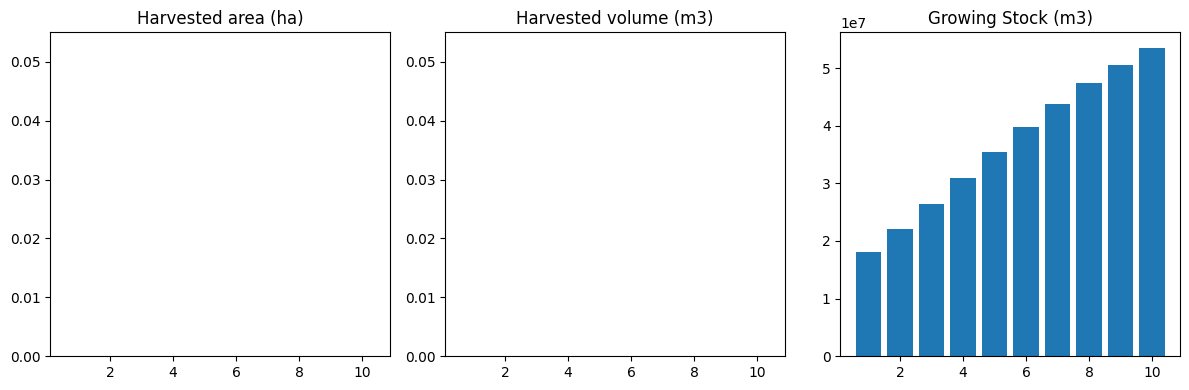

Plot saved to ./outputs/fig/redchris/redchris_min_ha_no_cons_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  0
The economic indicator (the provincial government revenues) is:  0
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


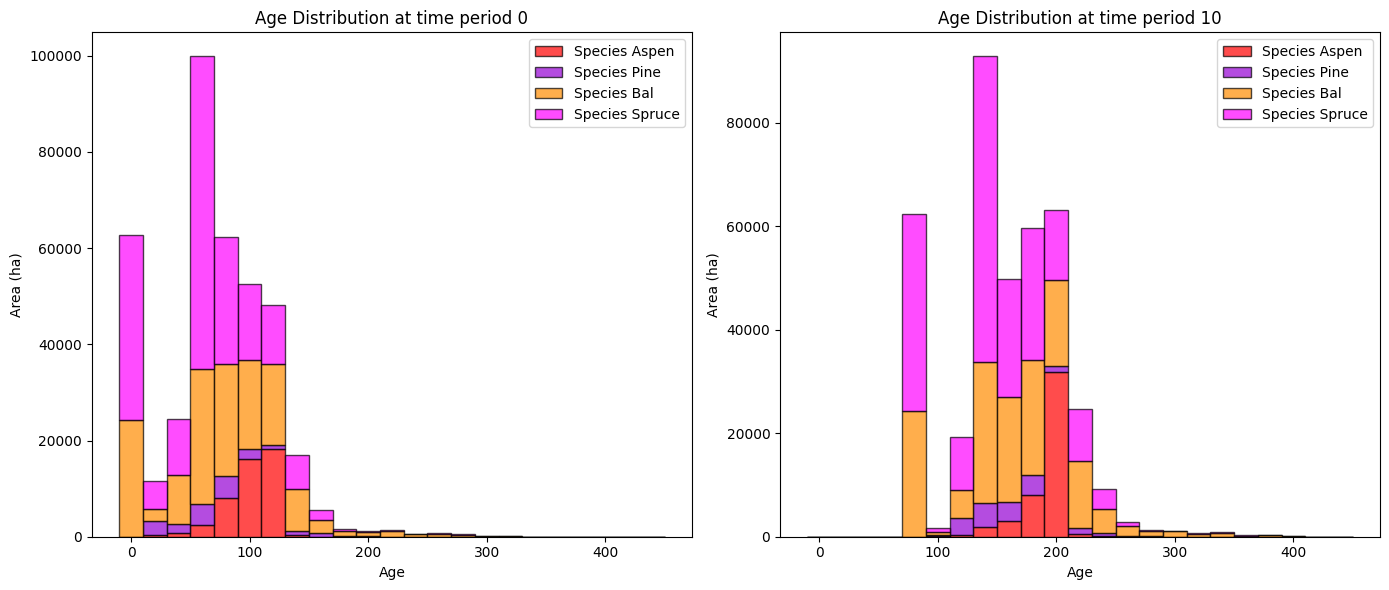

Plot saved to ./outputs/fig/redchris/redchris_min_ha_no_cons_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  44508.623748  43563.310060
Pine     602.782616   9389.986273   8787.203656
Bal     4315.588546  54242.845266  49927.256720
Spruce  1072.814408  42096.061799  41023.247392

Overall diversity has **increased** by 143301.02 hectares from time period 0 to time period 10.


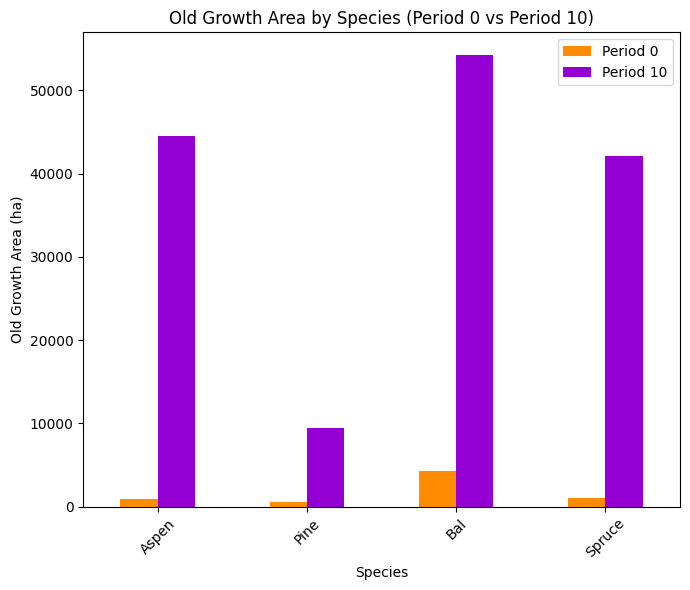

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_ha_no_cons_old_growth_comparison.pdf

Portion for time period 0:
Aspen: 0.2198
Pine: 0.0581
Bal: 0.4123
Spruce: 0.3099

Portion for time period 10:
Aspen: 0.1081
Pine: 0.0537
Bal: 0.4013
Spruce: 0.4369

Shannon Evennes Index for time period 0: 0.8848
Shannon Evennes Index for time period 10: 0.8120

Diversity has **decreased** by 7.28% from time 0 to time 10.


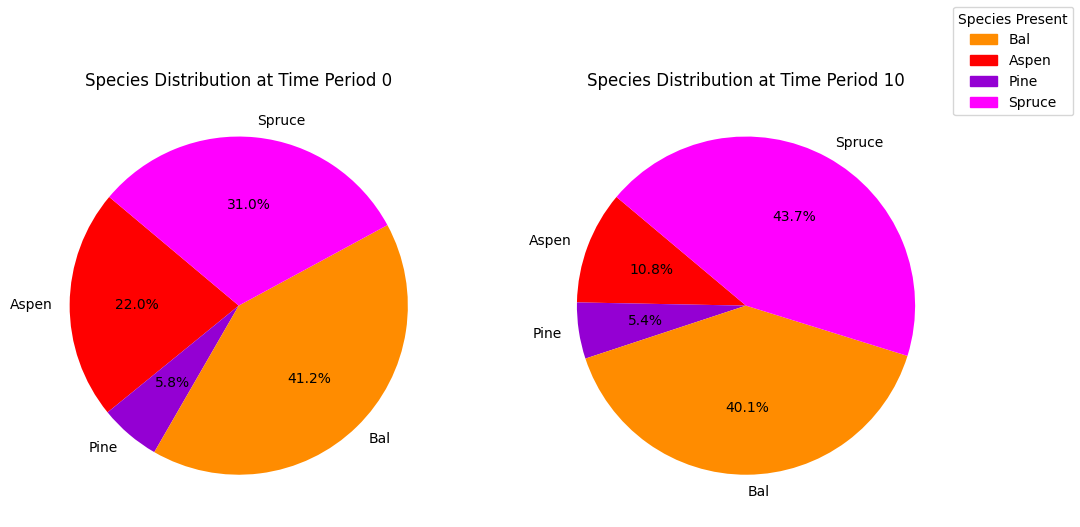

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_ha_no_cons_species_pie.pdf
running business as usual scenario for the Red Chris mining site,
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x97ce50eb
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-01, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.17s
Presolved: 1699 rows, 30866 columns, 420629 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s



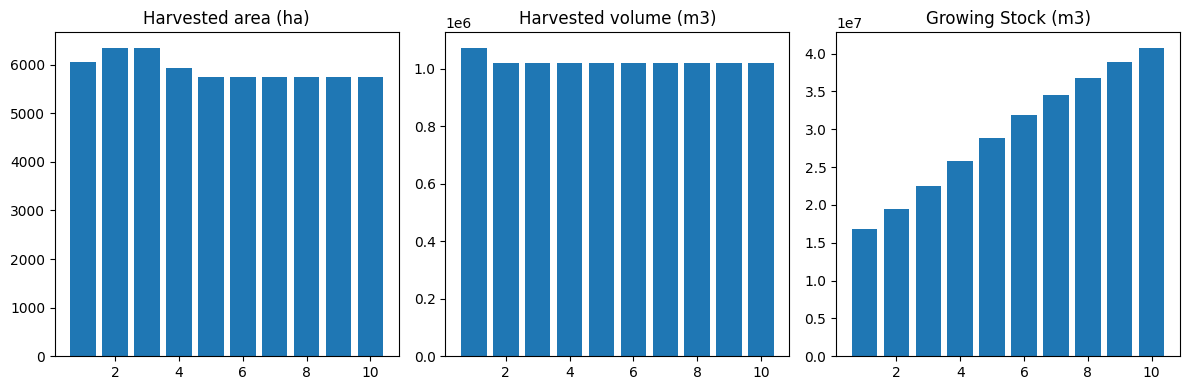

Plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  10831
The economic indicator (the provincial government revenues) is:  369393
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


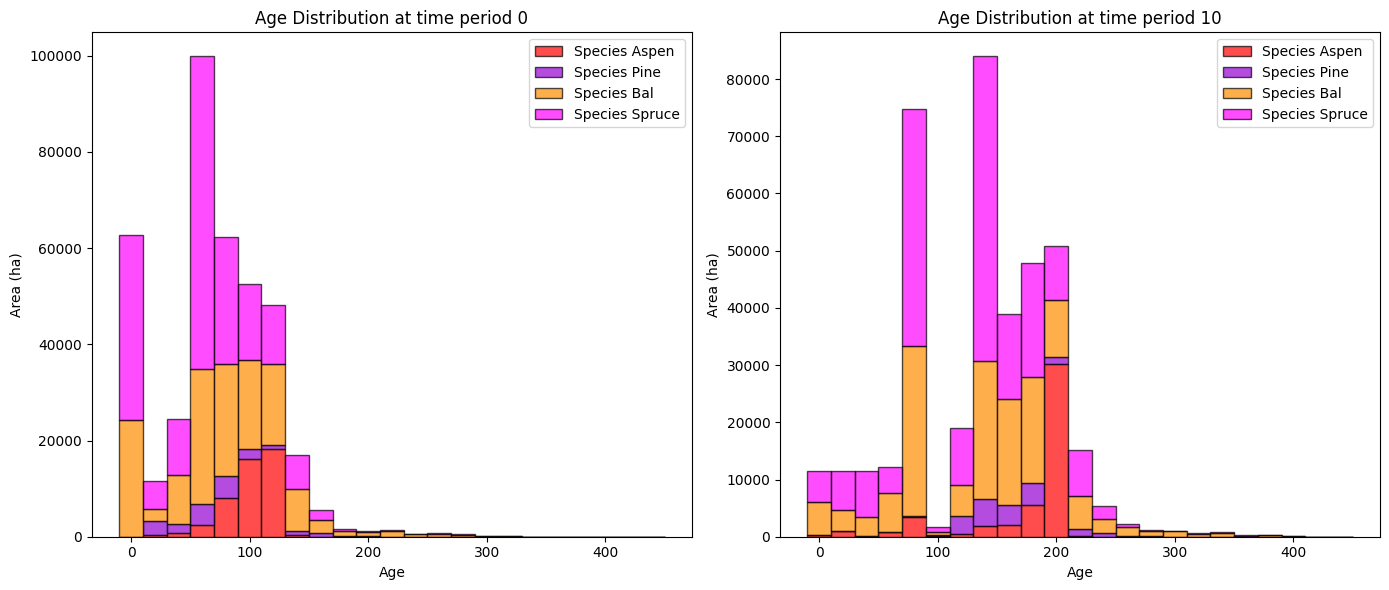

Plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  38766.465357  37821.151669
Pine     602.782616   9274.249263   8671.466647
Bal     4315.588546  35732.277284  31416.688738
Spruce  1072.814408  27525.137232  26452.322824

Overall diversity has **increased** by 104361.63 hectares from time period 0 to time period 10.


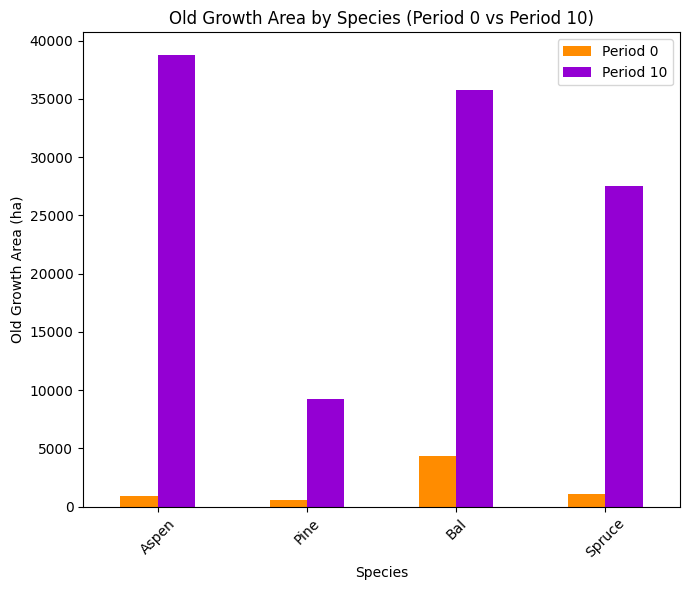

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_old_growth_comparison.pdf

Portion for time period 0:
Aspen: 0.2198
Pine: 0.0581
Bal: 0.4123
Spruce: 0.3099

Portion for time period 10:
Aspen: 0.1252
Pine: 0.0703
Bal: 0.4000
Spruce: 0.4045

Shannon Evennes Index for time period 0: 0.8848
Shannon Evennes Index for time period 10: 0.8507

Diversity has **decreased** by 3.41% from time 0 to time 10.


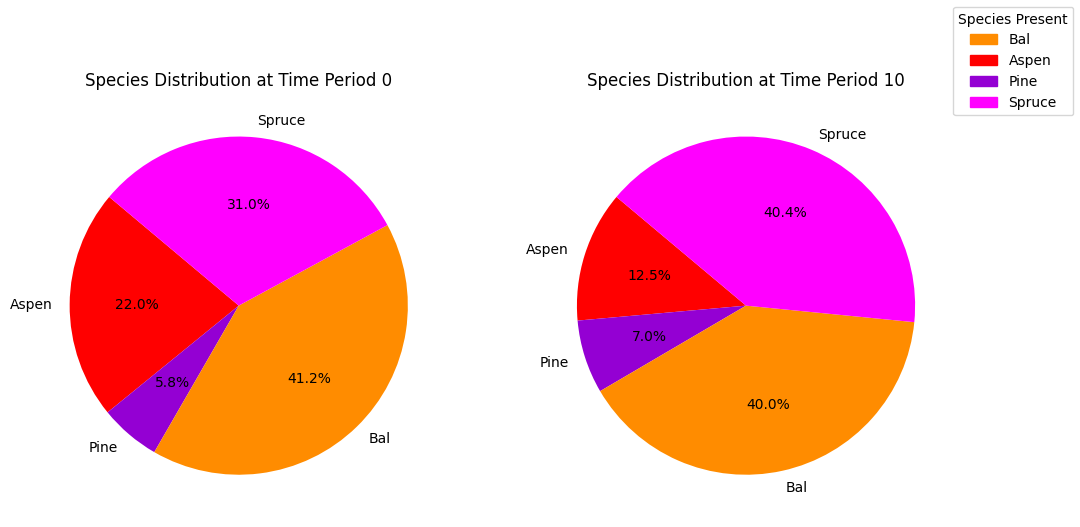

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_species_pie.pdf


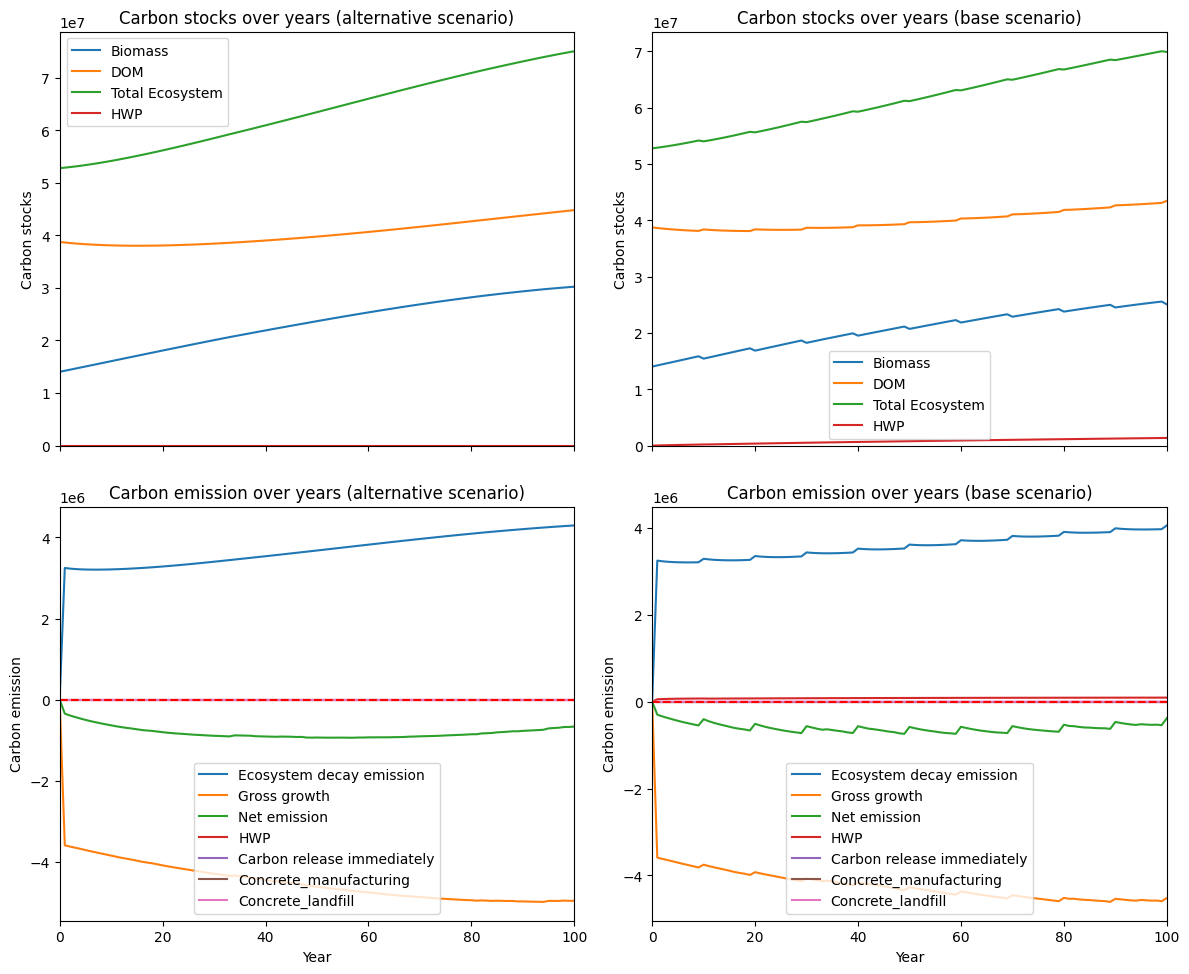

---------------------------------------------------------------------------------------
Net emission difference -3378786.593157001
Net emission base scenario -15685652.55028563
Net emission alternative scenario -12306865.95712863
dollar_per_ton is:  2.9596423817511384
Comparison of Old Growth Areas (Alternative - Base)
          0            10    Difference
Aspen   0.0   5742.158391   5742.158391
Pine    0.0    115.737010    115.737010
Bal     0.0  18510.567982  18510.567982
Spruce  0.0  14570.924567  14570.924567

Overall, the old growth area has **increased** by 38939.39 hectares in the alternative scenario compared to the base scenario.


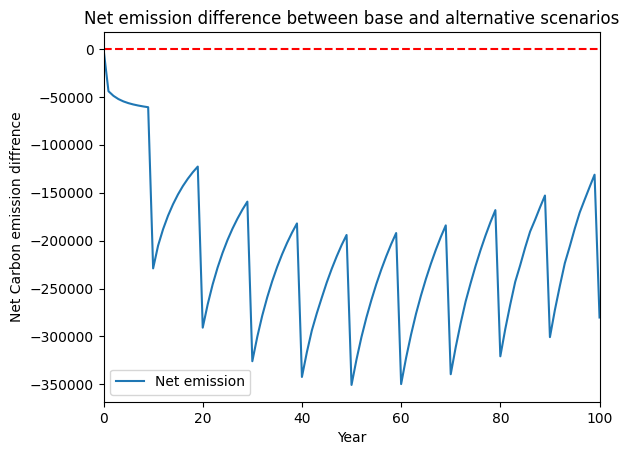

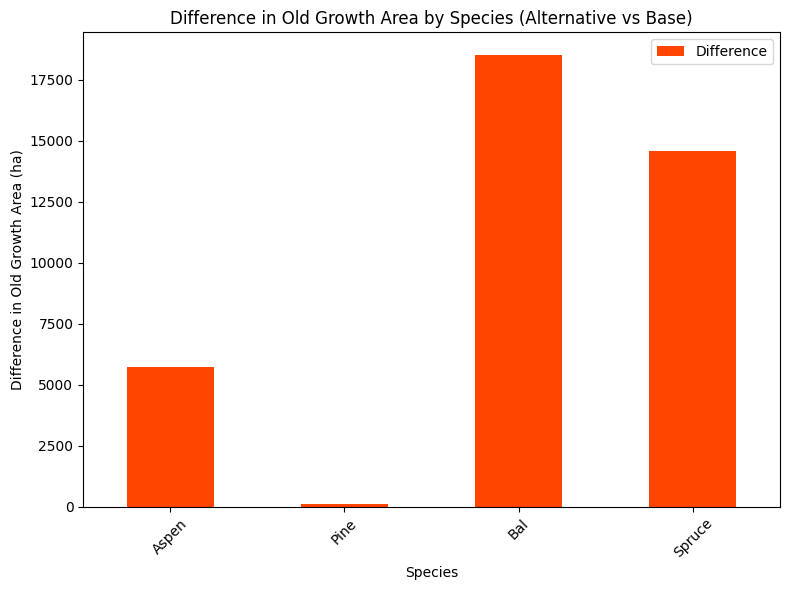

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/redchris/redchris_min_ha_kpi_age_difference.pdf


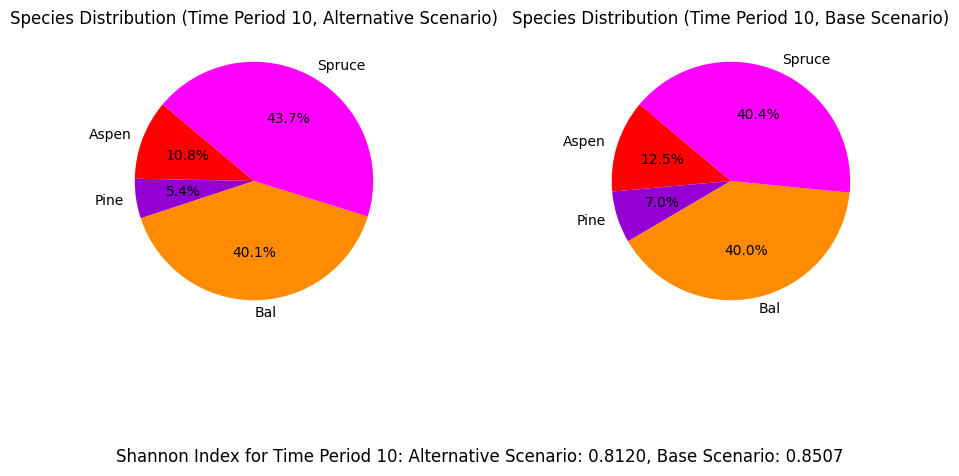

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_ha_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for redchris_min_ha_evenflow_cons...
running even flow constraints scenario
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3707 rows, 34533 columns and 445161 nonzeros
Model fingerprint: 0xd7051074
Coefficient statistics:
  Matrix range     [1e-02, 1e+06]
  Objective range  [2e-01, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 3707 rows and 34533 columns
Presolve time: 0.04s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

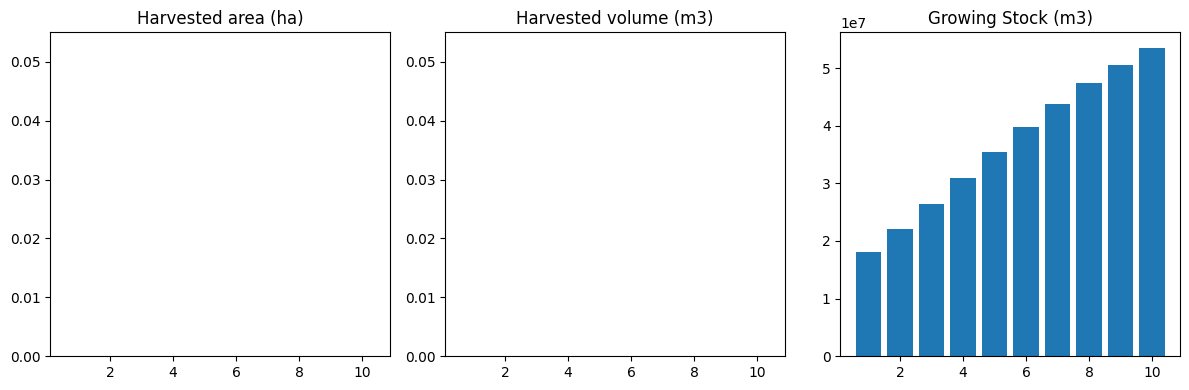

Plot saved to ./outputs/fig/redchris/redchris_min_ha_evenflow_cons_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  0
The economic indicator (the provincial government revenues) is:  0
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


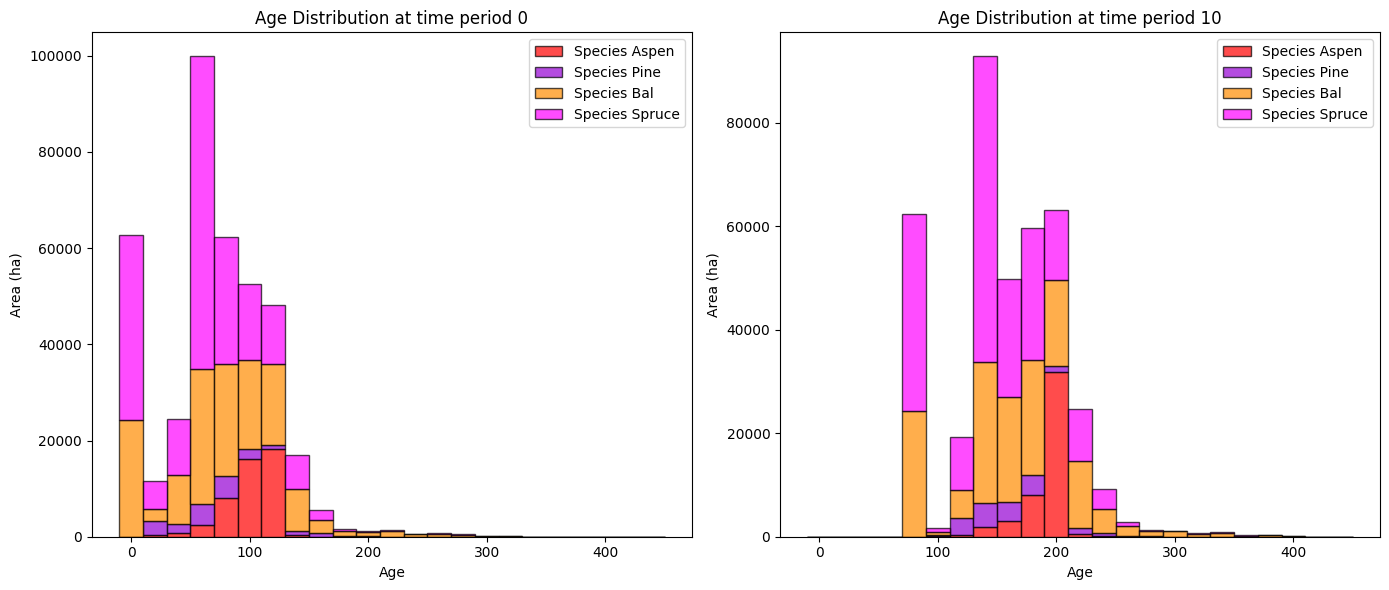

Plot saved to ./outputs/fig/redchris/redchris_min_ha_evenflow_cons_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  44508.623748  43563.310060
Pine     602.782616   9389.986273   8787.203656
Bal     4315.588546  54242.845266  49927.256720
Spruce  1072.814408  42096.061799  41023.247392

Overall diversity has **increased** by 143301.02 hectares from time period 0 to time period 10.


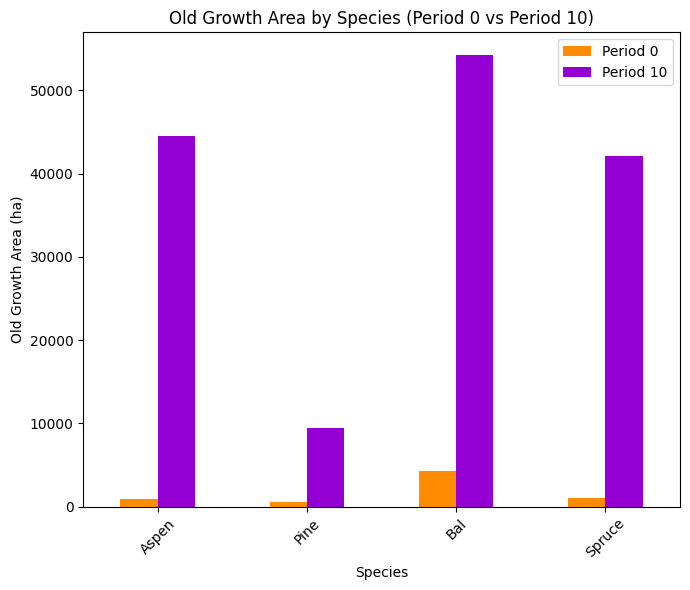

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_ha_evenflow_cons_old_growth_comparison.pdf

Portion for time period 0:
Aspen: 0.2198
Pine: 0.0581
Bal: 0.4123
Spruce: 0.3099

Portion for time period 10:
Aspen: 0.1081
Pine: 0.0537
Bal: 0.4013
Spruce: 0.4369

Shannon Evennes Index for time period 0: 0.8848
Shannon Evennes Index for time period 10: 0.8120

Diversity has **decreased** by 7.28% from time 0 to time 10.


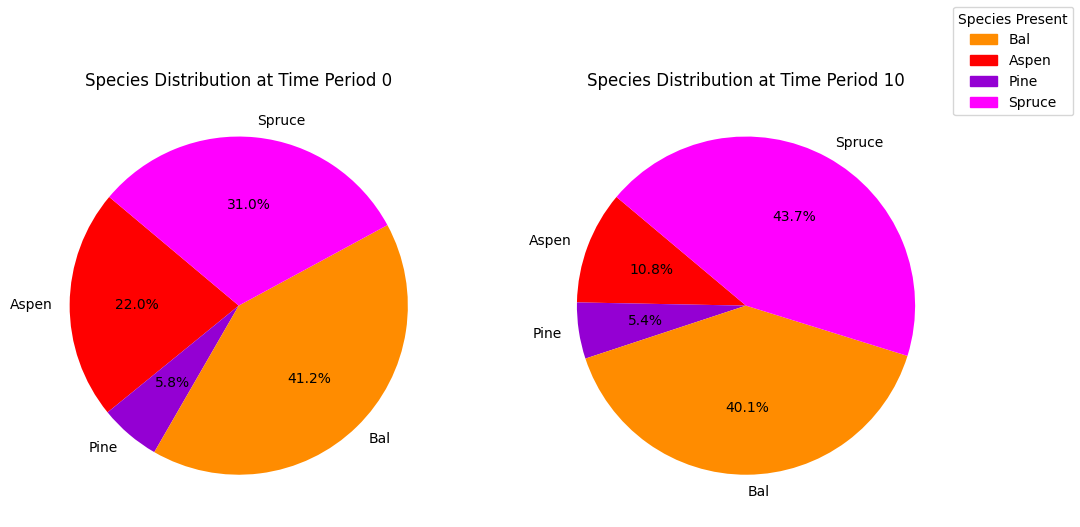

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_ha_evenflow_cons_species_pie.pdf
running business as usual scenario for the Red Chris mining site,
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x97ce50eb
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-01, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.18s
Presolved: 1699 rows, 30866 columns, 420629 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0

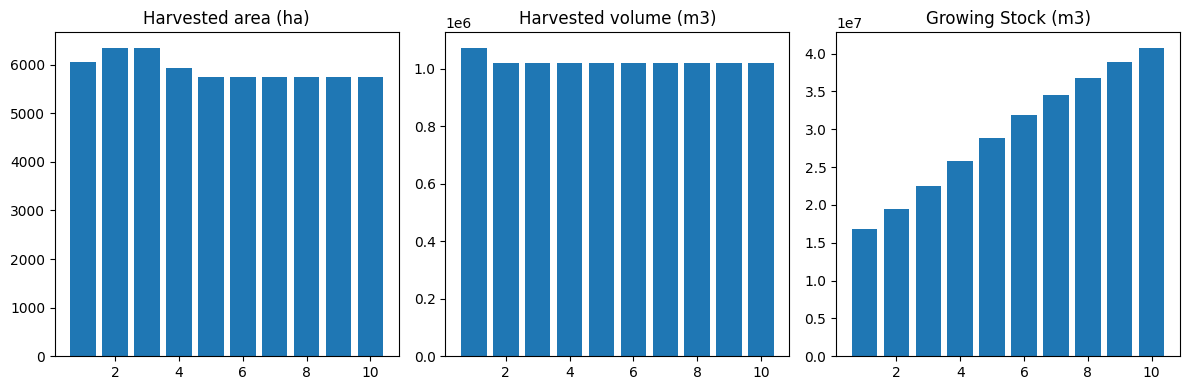

Plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  10831
The economic indicator (the provincial government revenues) is:  369393
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


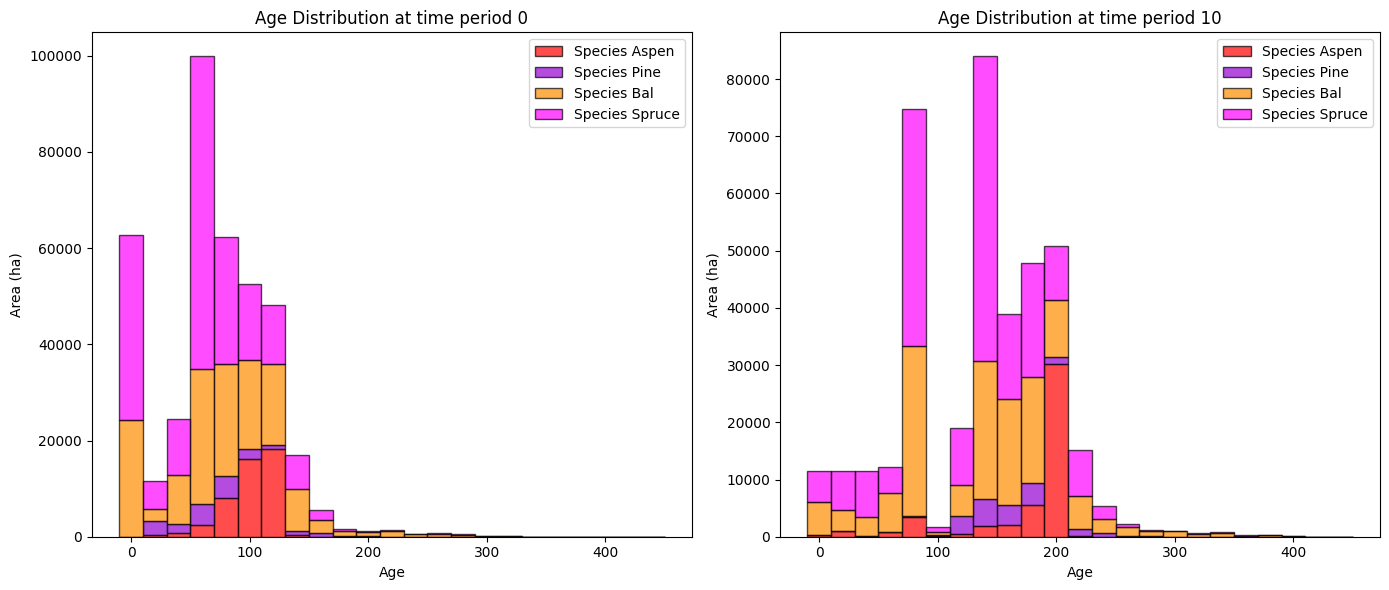

Plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  38766.465357  37821.151669
Pine     602.782616   9274.249263   8671.466647
Bal     4315.588546  35732.277284  31416.688738
Spruce  1072.814408  27525.137232  26452.322824

Overall diversity has **increased** by 104361.63 hectares from time period 0 to time period 10.


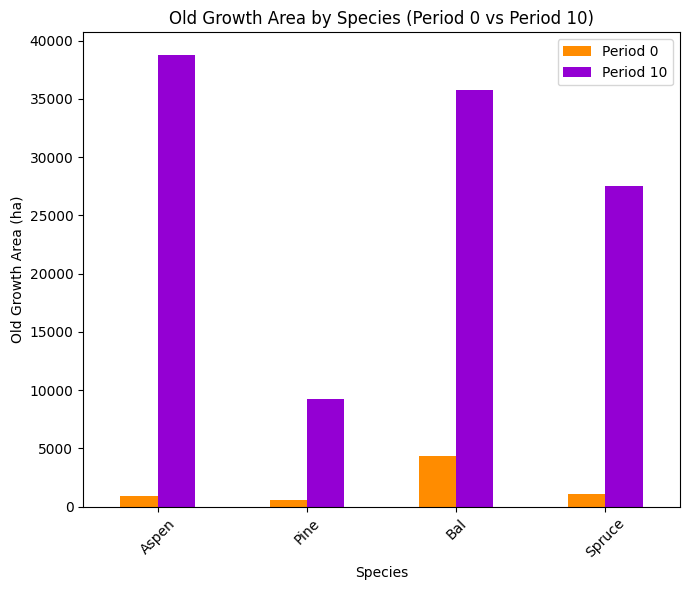

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_old_growth_comparison.pdf

Portion for time period 0:
Aspen: 0.2198
Pine: 0.0581
Bal: 0.4123
Spruce: 0.3099

Portion for time period 10:
Aspen: 0.1252
Pine: 0.0703
Bal: 0.4000
Spruce: 0.4045

Shannon Evennes Index for time period 0: 0.8848
Shannon Evennes Index for time period 10: 0.8507

Diversity has **decreased** by 3.41% from time 0 to time 10.


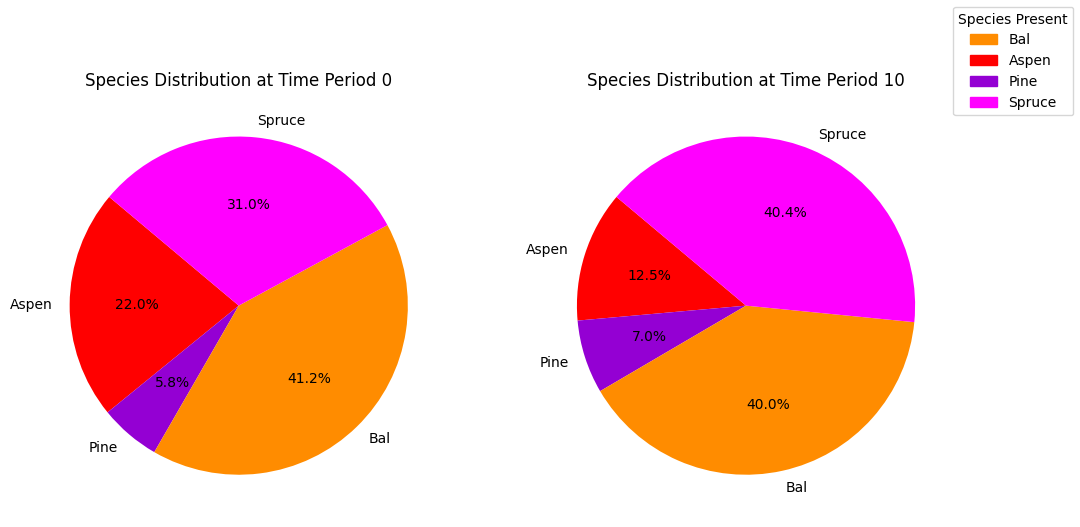

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_species_pie.pdf


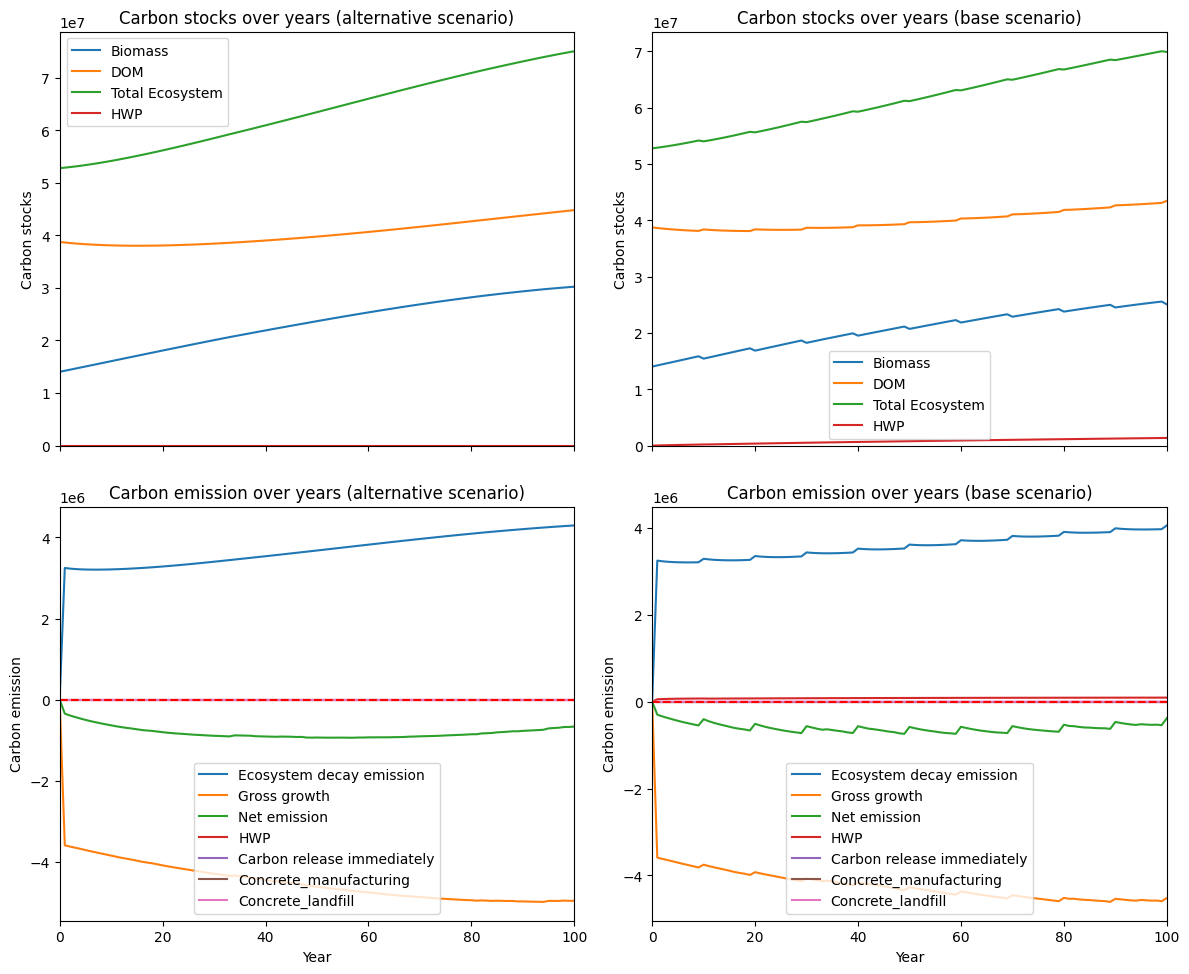

---------------------------------------------------------------------------------------
Net emission difference -3378786.593157001
Net emission base scenario -15685652.55028563
Net emission alternative scenario -12306865.95712863
dollar_per_ton is:  2.9596423817511384
Comparison of Old Growth Areas (Alternative - Base)
          0            10    Difference
Aspen   0.0   5742.158391   5742.158391
Pine    0.0    115.737010    115.737010
Bal     0.0  18510.567982  18510.567982
Spruce  0.0  14570.924567  14570.924567

Overall, the old growth area has **increased** by 38939.39 hectares in the alternative scenario compared to the base scenario.


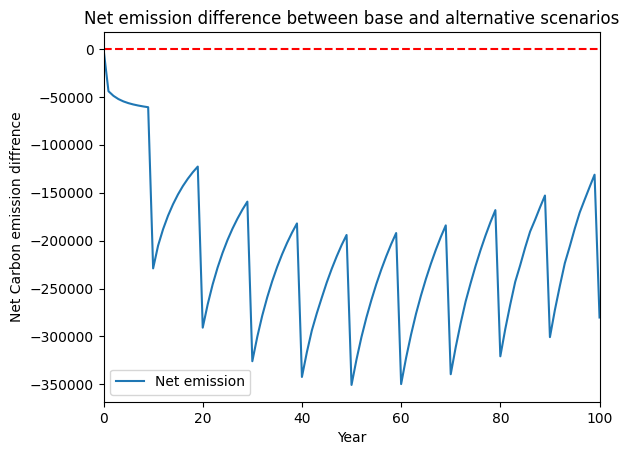

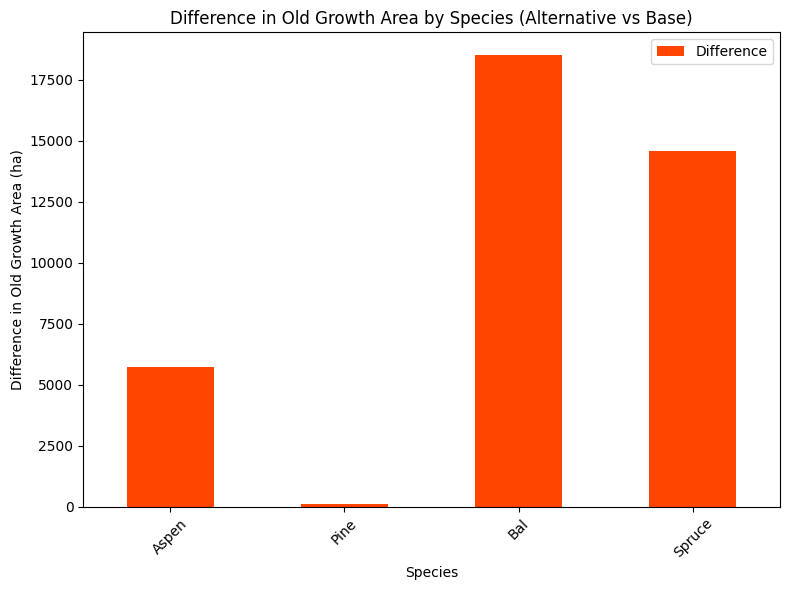

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/redchris/redchris_min_ha_kpi_age_difference.pdf


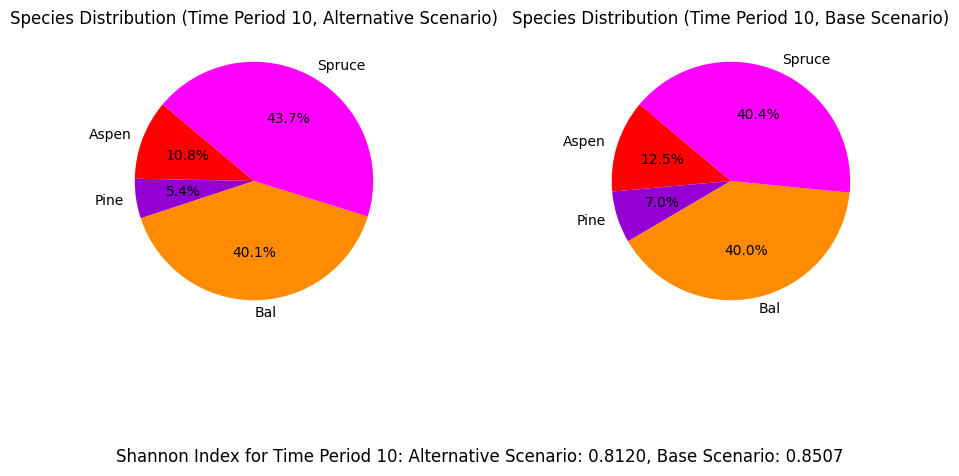

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_ha_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for redchris_min_ha_bau_redchrs...
running business as usual scenario for the Red Chris mining site,
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x97ce50eb
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-01, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.18s
Presolved: 1699 rows, 30866 column

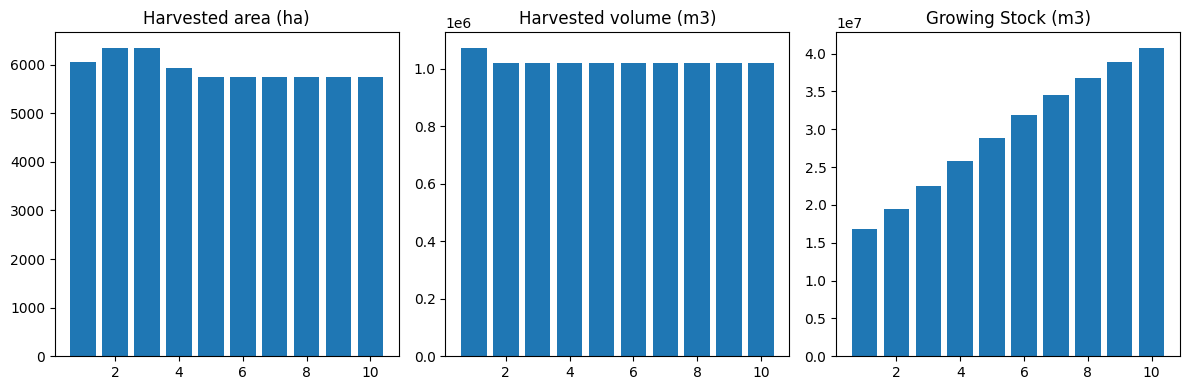

Plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  10831
The economic indicator (the provincial government revenues) is:  369393
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


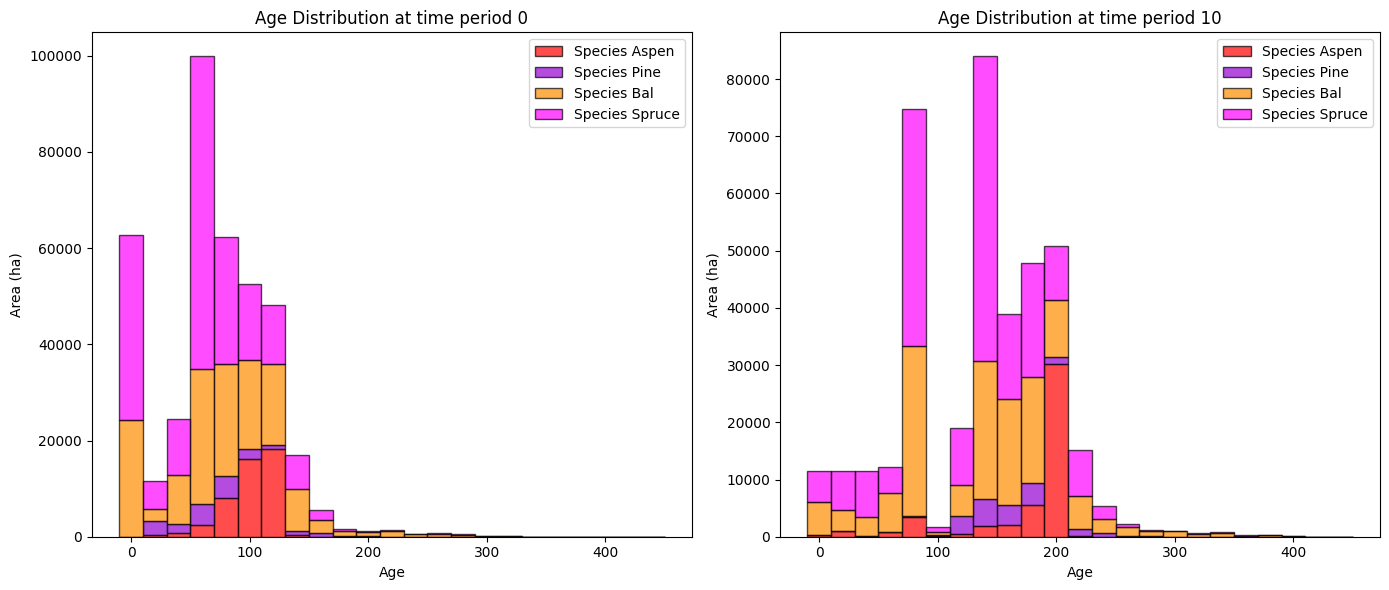

Plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  38766.465357  37821.151669
Pine     602.782616   9274.249263   8671.466647
Bal     4315.588546  35732.277284  31416.688738
Spruce  1072.814408  27525.137232  26452.322824

Overall diversity has **increased** by 104361.63 hectares from time period 0 to time period 10.


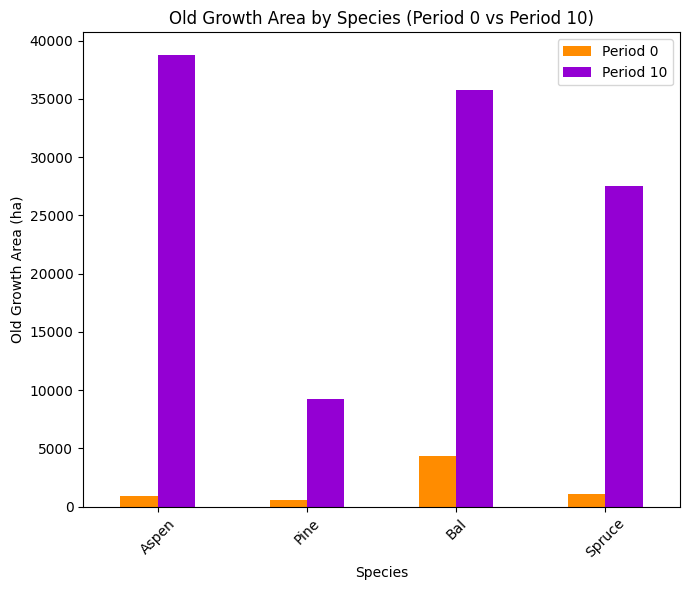

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_old_growth_comparison.pdf

Portion for time period 0:
Aspen: 0.2198
Pine: 0.0581
Bal: 0.4123
Spruce: 0.3099

Portion for time period 10:
Aspen: 0.1252
Pine: 0.0703
Bal: 0.4000
Spruce: 0.4045

Shannon Evennes Index for time period 0: 0.8848
Shannon Evennes Index for time period 10: 0.8507

Diversity has **decreased** by 3.41% from time 0 to time 10.


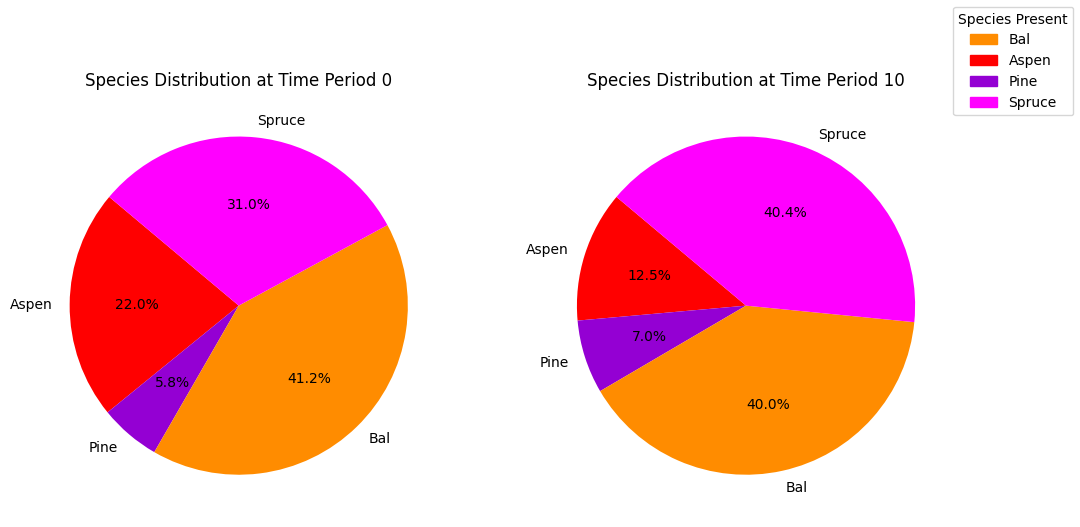

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_species_pie.pdf
running business as usual scenario for the Red Chris mining site,
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x97ce50eb
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-01, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.18s
Presolved: 1699 rows, 30866 columns, 420629 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.0

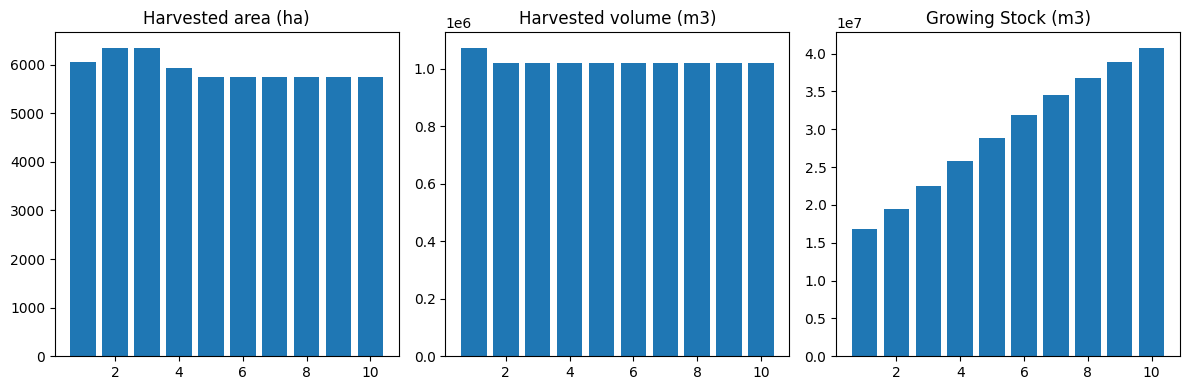

Plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  10831
The economic indicator (the provincial government revenues) is:  369393
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


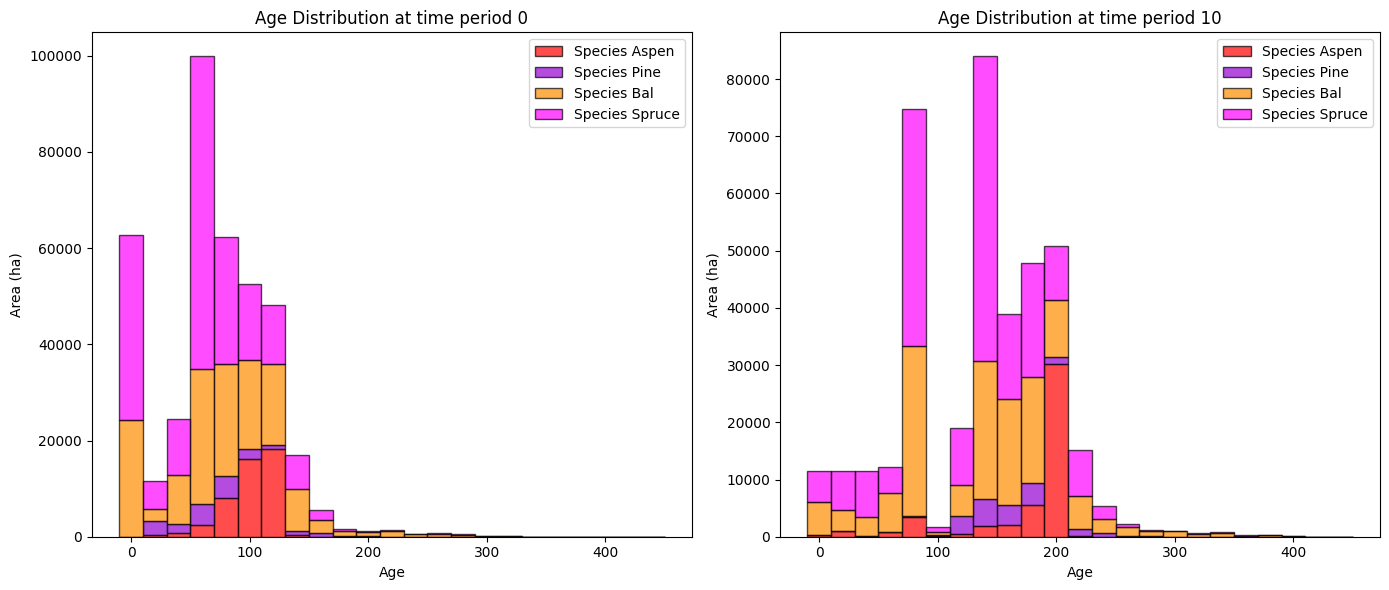

Plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  38766.465357  37821.151669
Pine     602.782616   9274.249263   8671.466647
Bal     4315.588546  35732.277284  31416.688738
Spruce  1072.814408  27525.137232  26452.322824

Overall diversity has **increased** by 104361.63 hectares from time period 0 to time period 10.


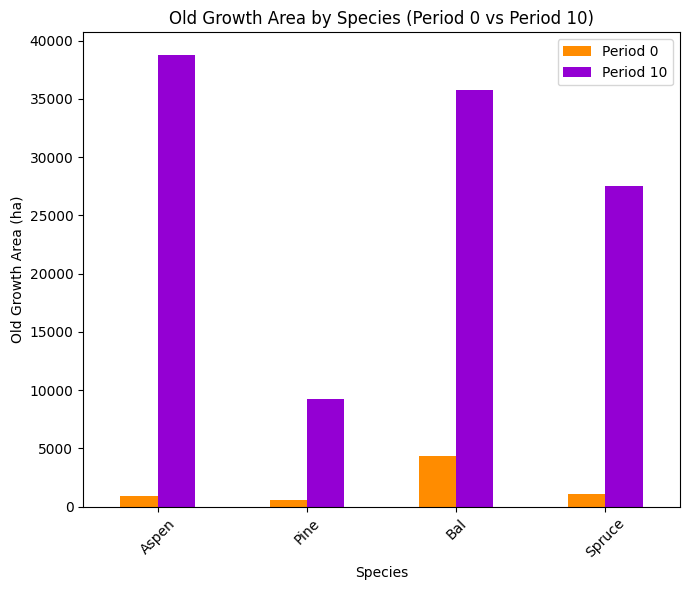

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_old_growth_comparison.pdf

Portion for time period 0:
Aspen: 0.2198
Pine: 0.0581
Bal: 0.4123
Spruce: 0.3099

Portion for time period 10:
Aspen: 0.1252
Pine: 0.0703
Bal: 0.4000
Spruce: 0.4045

Shannon Evennes Index for time period 0: 0.8848
Shannon Evennes Index for time period 10: 0.8507

Diversity has **decreased** by 3.41% from time 0 to time 10.


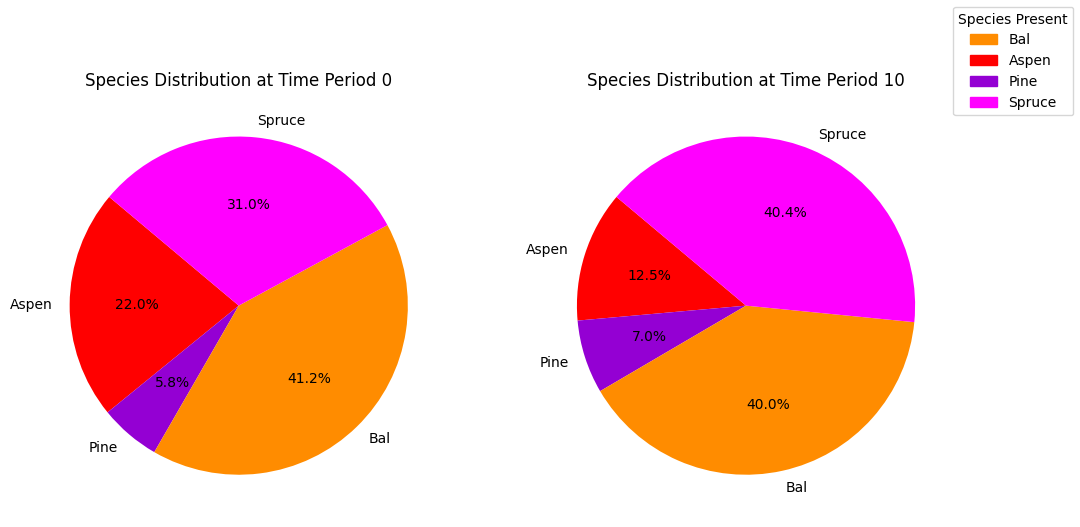

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_species_pie.pdf


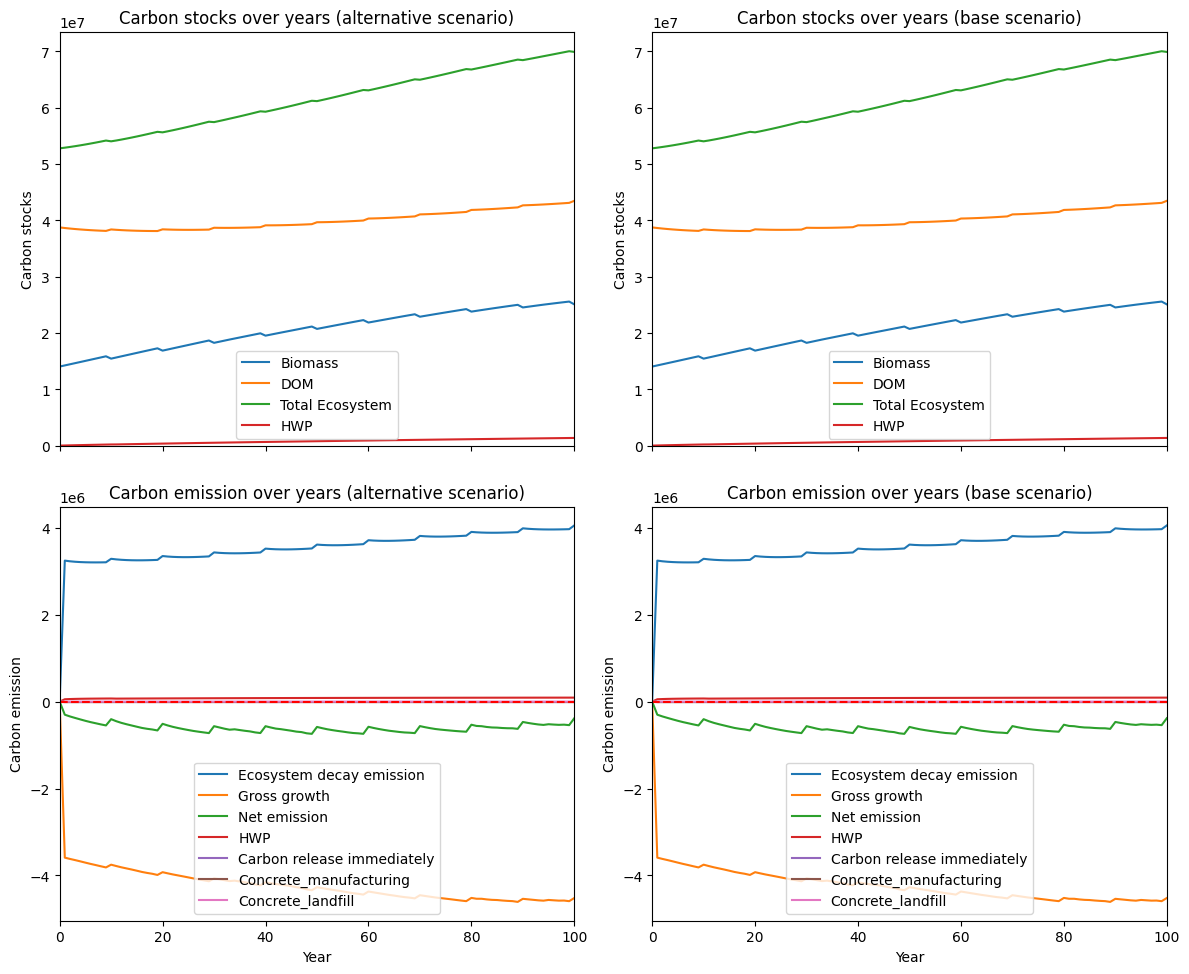

---------------------------------------------------------------------------------------
Net emission difference 0.0
Net emission base scenario -12306865.95712863
Net emission alternative scenario -12306865.95712863
dollar_per_ton is:  inf
Comparison of Old Growth Areas (Alternative - Base)
          0   10  Difference
Aspen   0.0  0.0         0.0
Pine    0.0  0.0         0.0
Bal     0.0  0.0         0.0
Spruce  0.0  0.0         0.0

Overall, the old growth area has **increased** by 0.00 hectares in the alternative scenario compared to the base scenario.


/media/data/project/eghasemi/nbds_mining/util_opt.py:1211: RuntimeWarning: divide by zero encountered in scalar divide
  dollar_per_ton = abs(budget_input / dif_scenario.iloc[:25]['Net emission'].sum())


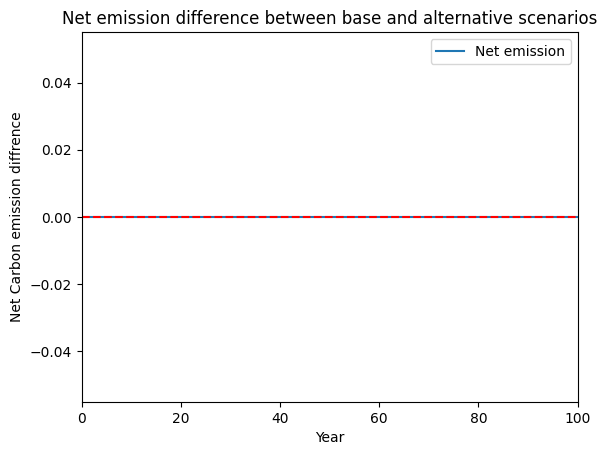

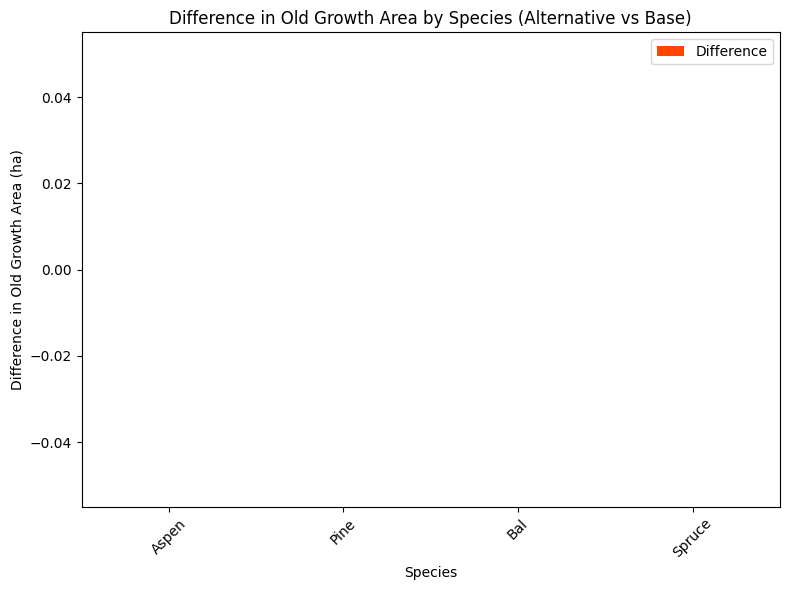

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/redchris/redchris_min_ha_kpi_age_difference.pdf


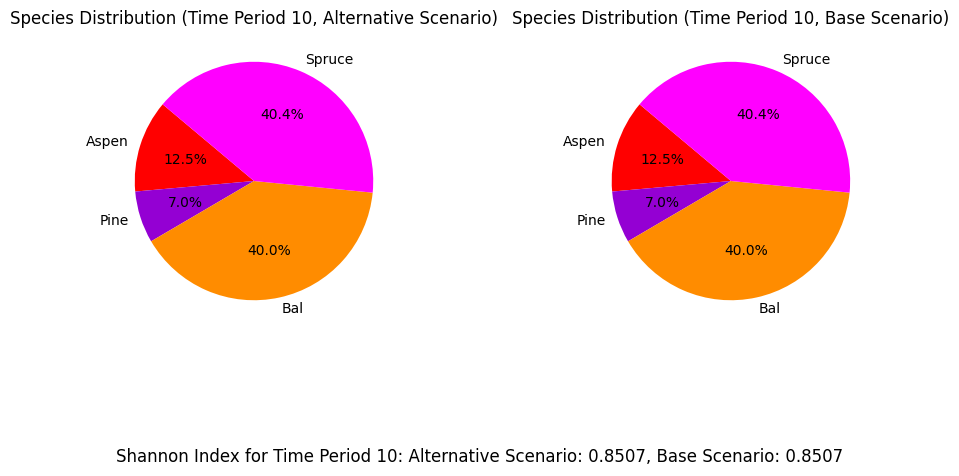

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_ha_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for redchris_min_ha_redchrs_AAC_90%...
running the scenario for the Red Chris mining site (90%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x29fb1203
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-01, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.17s
Presolved: 1699 rows, 30867 column

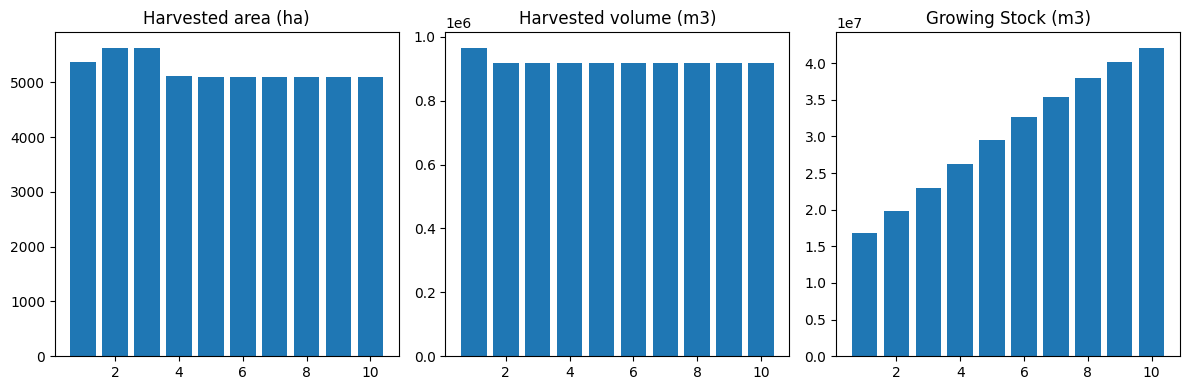

Plot saved to ./outputs/fig/redchris/redchris_min_ha_redchrs_AAC_90%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  9748
The economic indicator (the provincial government revenues) is:  332454
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


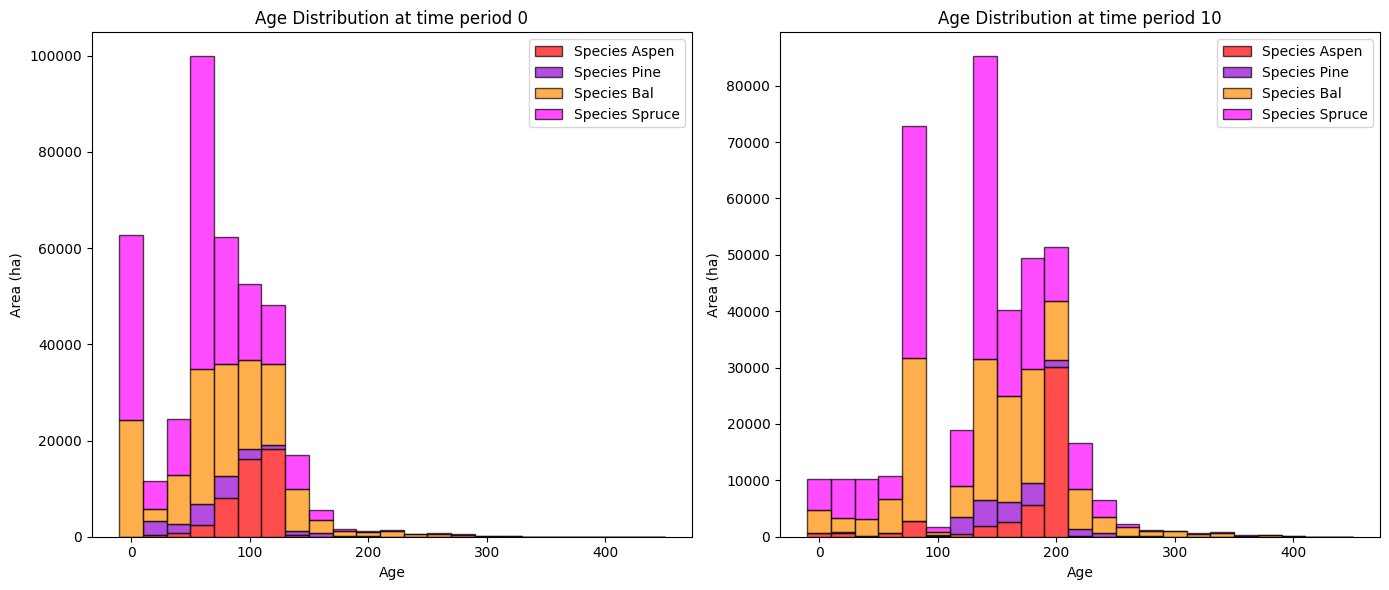

Plot saved to ./outputs/fig/redchris/redchris_min_ha_redchrs_AAC_90%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  39578.014662  38632.700974
Pine     602.782616   9365.994365   8763.211748
Bal     4315.588546  38761.499918  34445.911372
Spruce  1072.814408  28518.794596  27445.980188

Overall diversity has **increased** by 109287.80 hectares from time period 0 to time period 10.


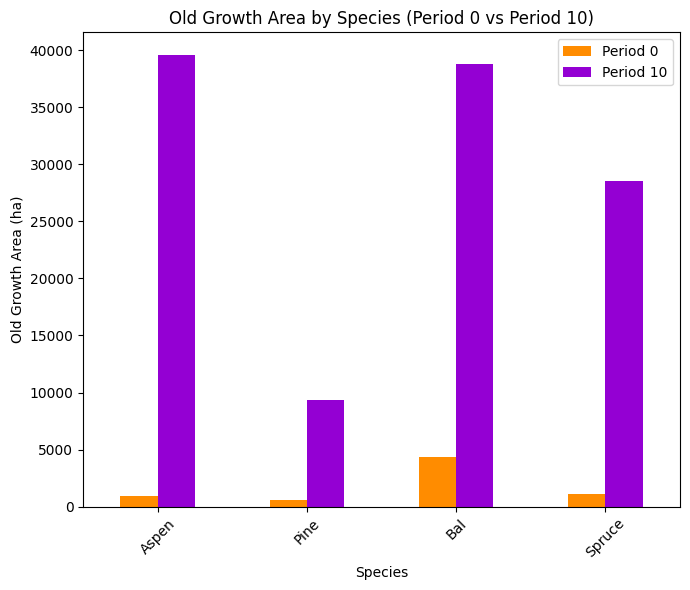

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_ha_redchrs_AAC_90%_old_growth_comparison.pdf

Portion for time period 0:
Aspen: 0.2198
Pine: 0.0581
Bal: 0.4123
Spruce: 0.3099

Portion for time period 10:
Aspen: 0.1228
Pine: 0.0683
Bal: 0.4106
Spruce: 0.3983

Shannon Evennes Index for time period 0: 0.8848
Shannon Evennes Index for time period 10: 0.8461

Diversity has **decreased** by 3.88% from time 0 to time 10.


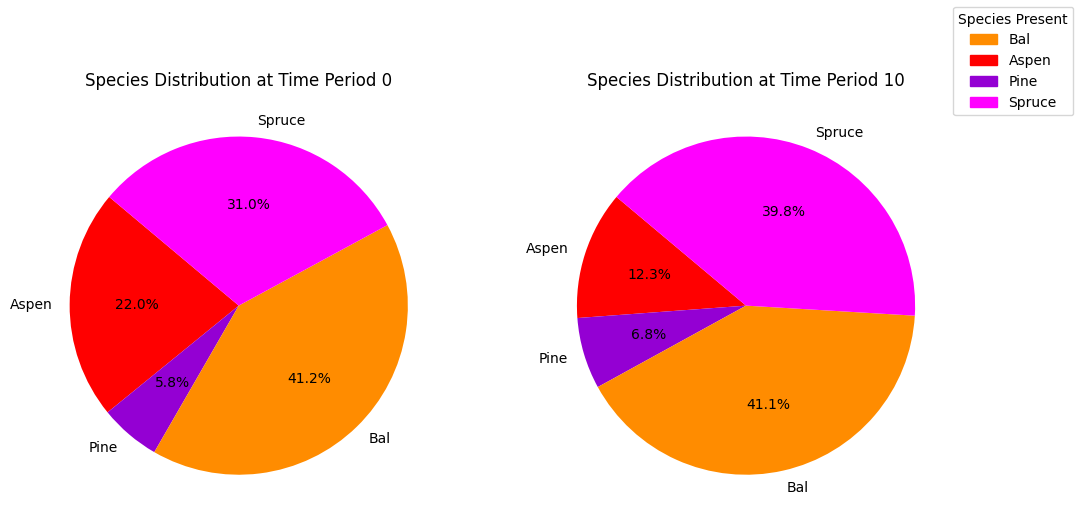

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_ha_redchrs_AAC_90%_species_pie.pdf
running business as usual scenario for the Red Chris mining site,
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x97ce50eb
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-01, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.17s
Presolved: 1699 rows, 30866 columns, 420629 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time:

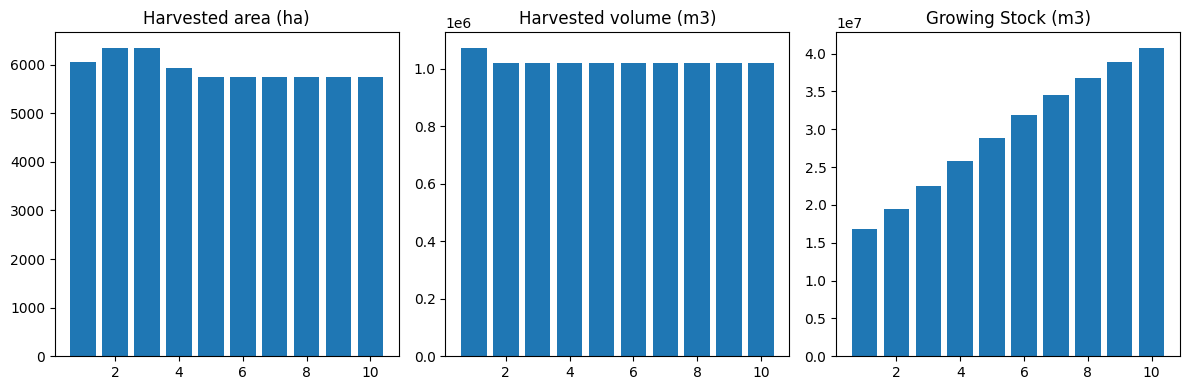

Plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  10831
The economic indicator (the provincial government revenues) is:  369393
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


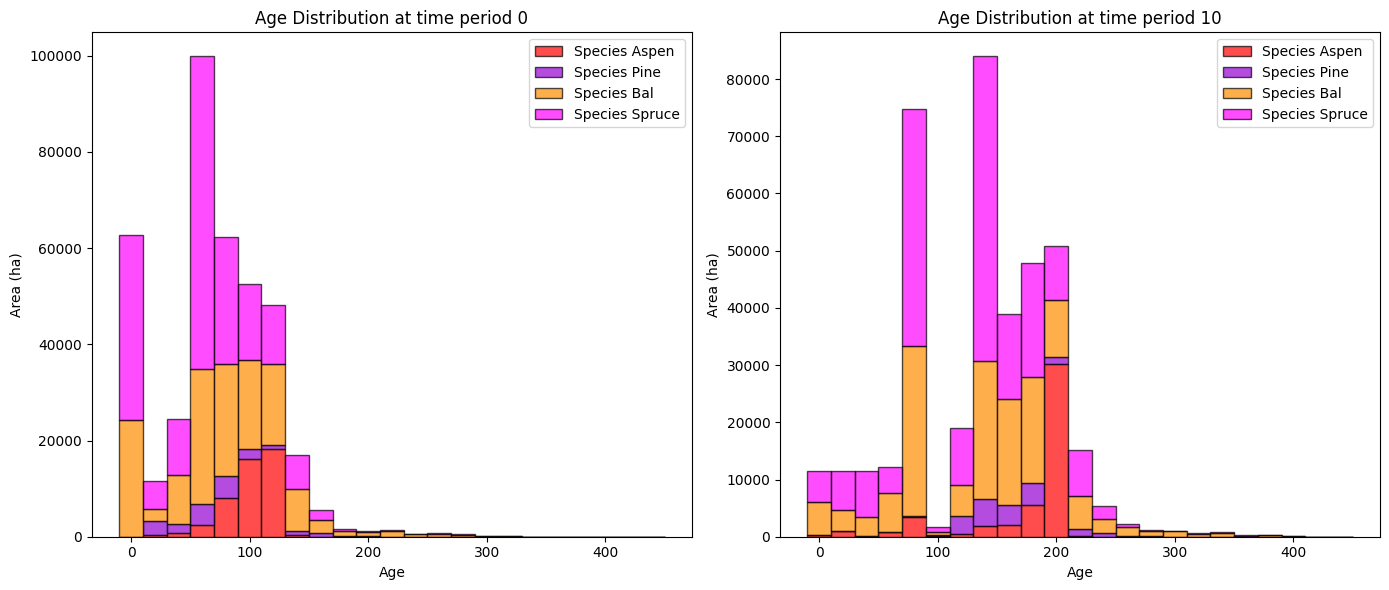

Plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  38766.465357  37821.151669
Pine     602.782616   9274.249263   8671.466647
Bal     4315.588546  35732.277284  31416.688738
Spruce  1072.814408  27525.137232  26452.322824

Overall diversity has **increased** by 104361.63 hectares from time period 0 to time period 10.


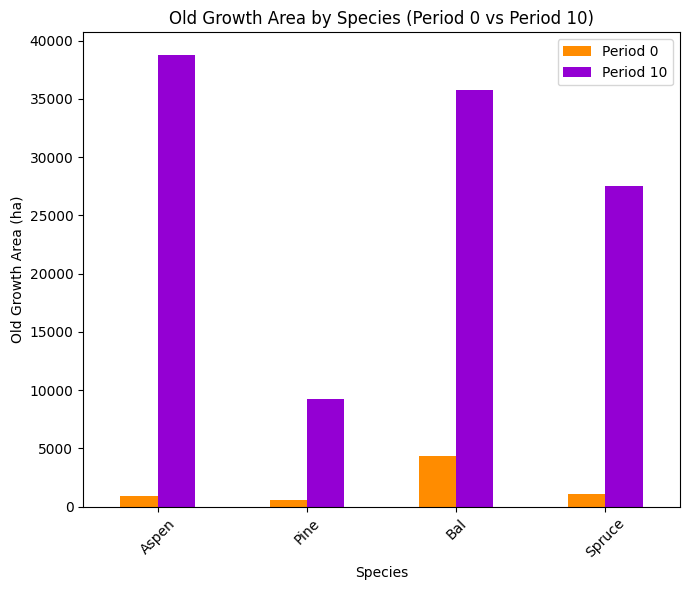

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_old_growth_comparison.pdf

Portion for time period 0:
Aspen: 0.2198
Pine: 0.0581
Bal: 0.4123
Spruce: 0.3099

Portion for time period 10:
Aspen: 0.1252
Pine: 0.0703
Bal: 0.4000
Spruce: 0.4045

Shannon Evennes Index for time period 0: 0.8848
Shannon Evennes Index for time period 10: 0.8507

Diversity has **decreased** by 3.41% from time 0 to time 10.


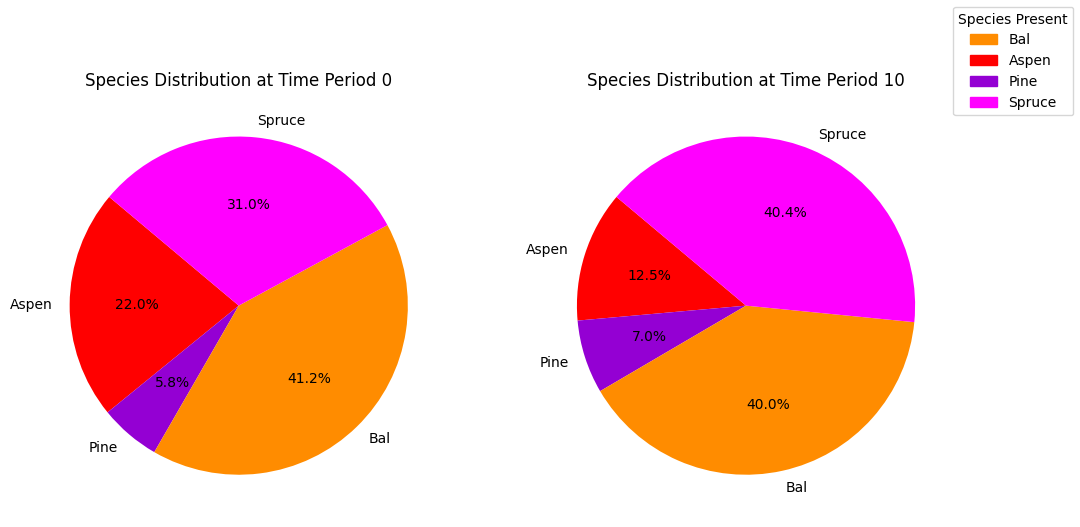

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_species_pie.pdf


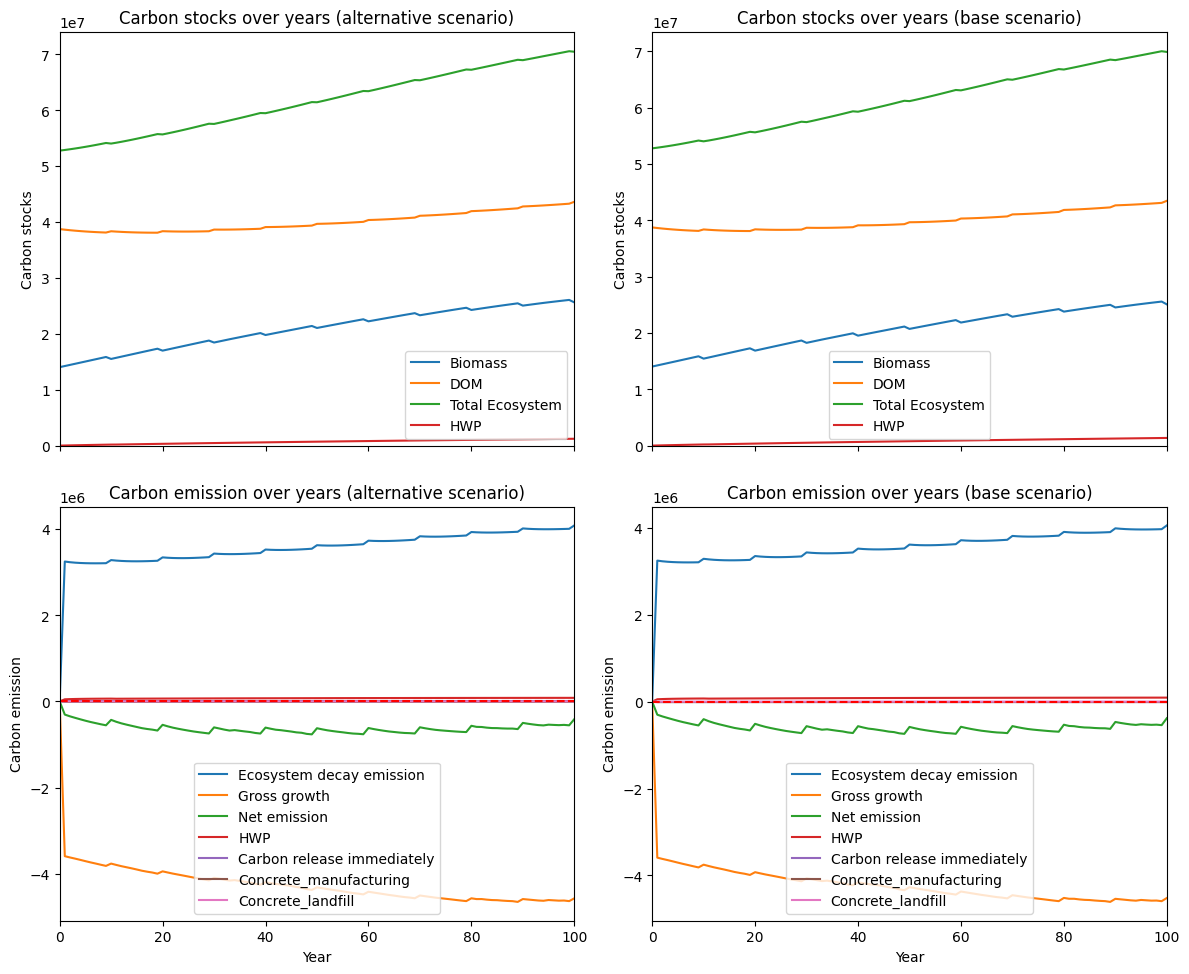

---------------------------------------------------------------------------------------
Net emission difference -361482.52423506655
Net emission base scenario -12668348.481363695
Net emission alternative scenario -12306865.95712863
dollar_per_ton is:  27.66385462522983
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Aspen   0.0   811.549305   811.549305
Pine    0.0    91.745102    91.745102
Bal     0.0  3029.222634  3029.222634
Spruce  0.0   993.657364   993.657364

Overall, the old growth area has **increased** by 4926.17 hectares in the alternative scenario compared to the base scenario.


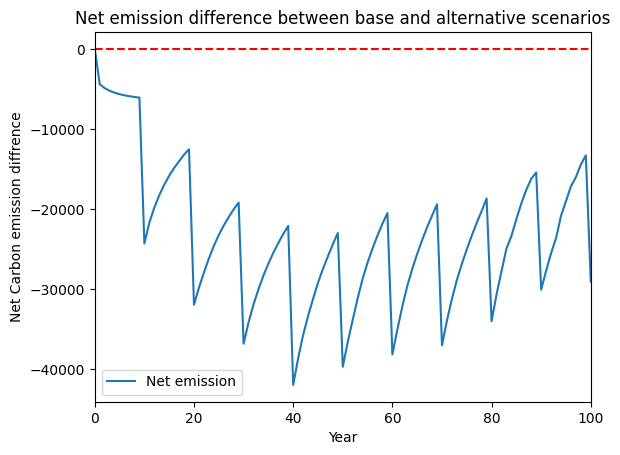

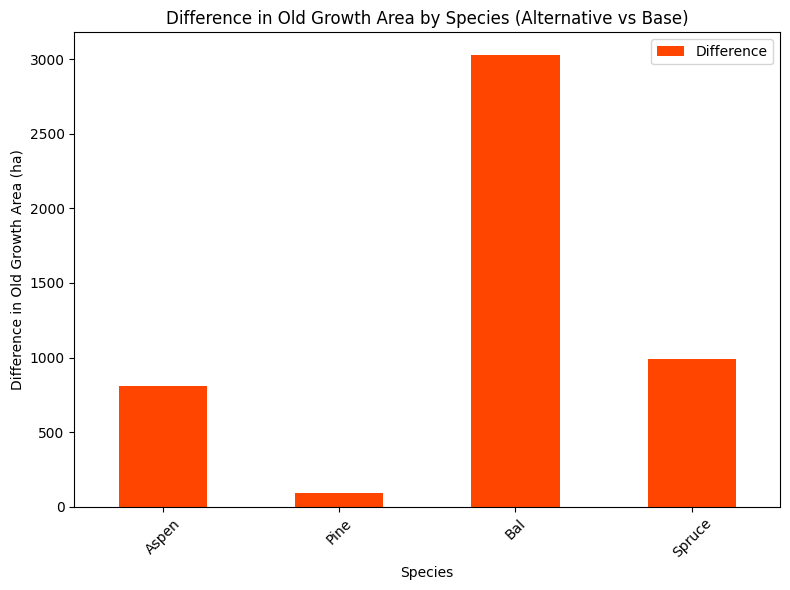

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/redchris/redchris_min_ha_kpi_age_difference.pdf


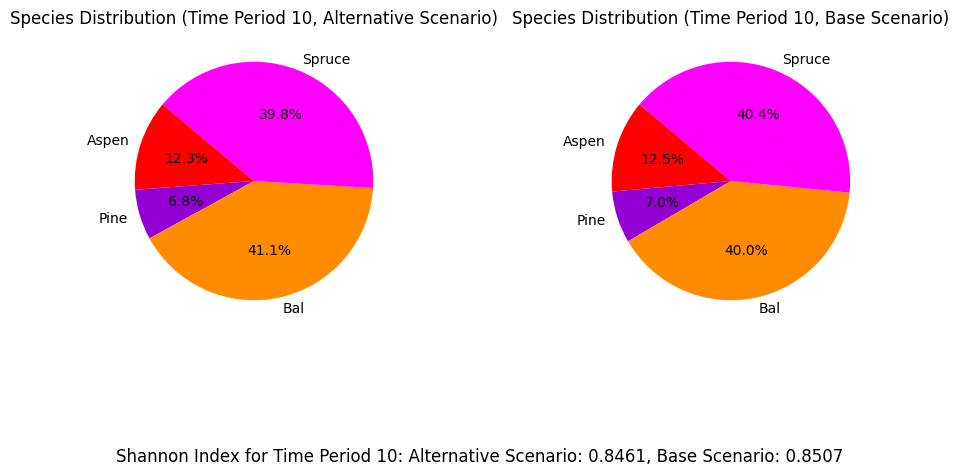

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_ha_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for redchris_min_ha_redchrs_AAC_80%...
running the scenario for the Red Chris mining site (80%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x7c1f5b22
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-01, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.16s
Presolved: 1699 rows, 30867 column

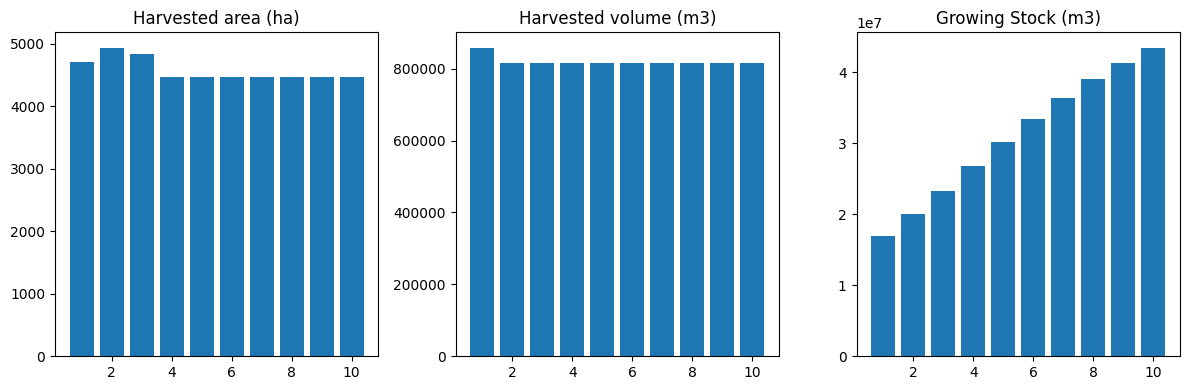

Plot saved to ./outputs/fig/redchris/redchris_min_ha_redchrs_AAC_80%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  8665
The economic indicator (the provincial government revenues) is:  295514
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


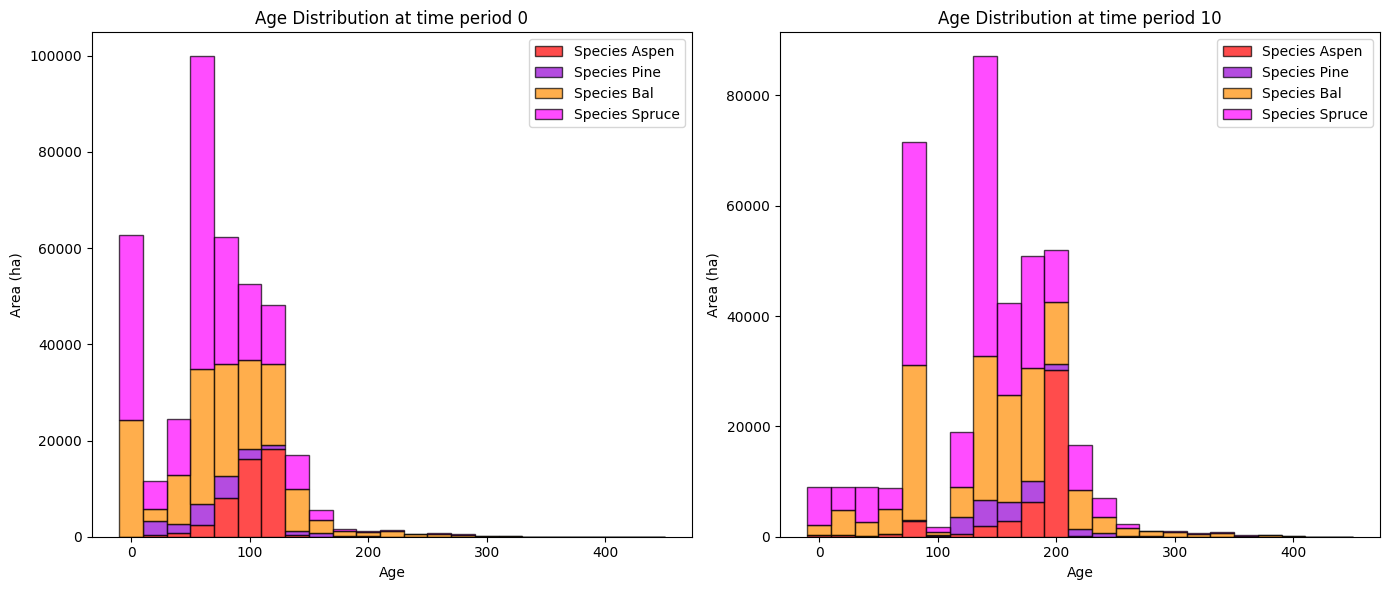

Plot saved to ./outputs/fig/redchris/redchris_min_ha_redchrs_AAC_80%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  40316.557382  39371.243694
Pine     602.782616   9386.299735   8783.517119
Bal     4315.588546  39832.790222  35517.201676
Spruce  1072.814408  29541.605305  28468.790897

Overall diversity has **increased** by 112140.75 hectares from time period 0 to time period 10.


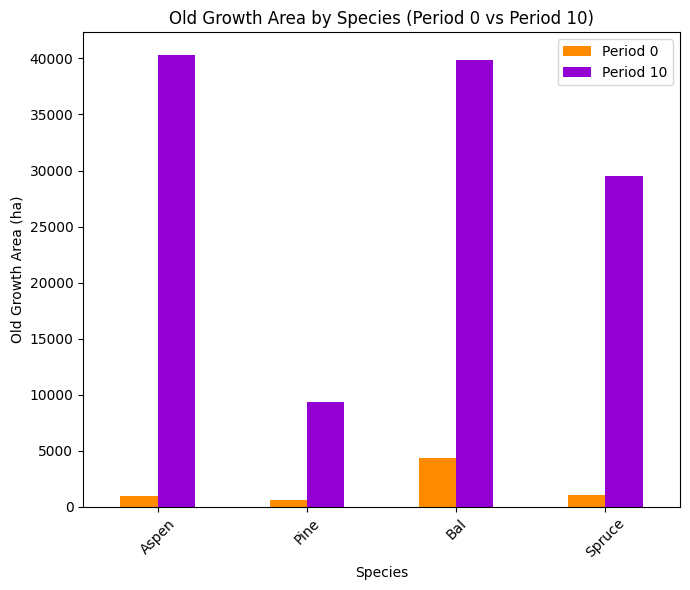

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_ha_redchrs_AAC_80%_old_growth_comparison.pdf

Portion for time period 0:
Aspen: 0.2198
Pine: 0.0581
Bal: 0.4123
Spruce: 0.3099

Portion for time period 10:
Aspen: 0.1230
Pine: 0.0661
Bal: 0.4102
Spruce: 0.4006

Shannon Evennes Index for time period 0: 0.8848
Shannon Evennes Index for time period 10: 0.8435

Diversity has **decreased** by 4.13% from time 0 to time 10.


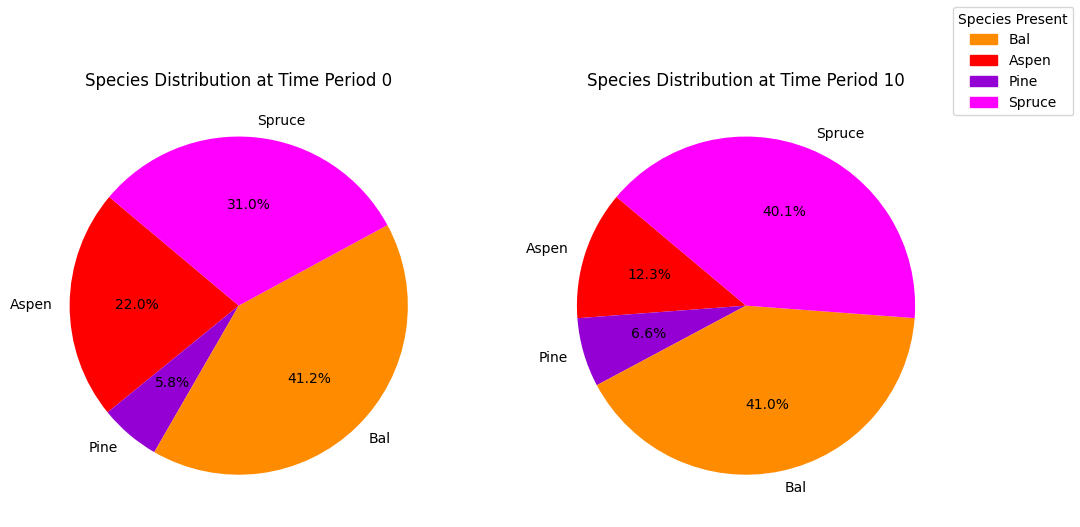

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_ha_redchrs_AAC_80%_species_pie.pdf
running business as usual scenario for the Red Chris mining site,
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x97ce50eb
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-01, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.23s
Presolved: 1699 rows, 30866 columns, 420629 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time:

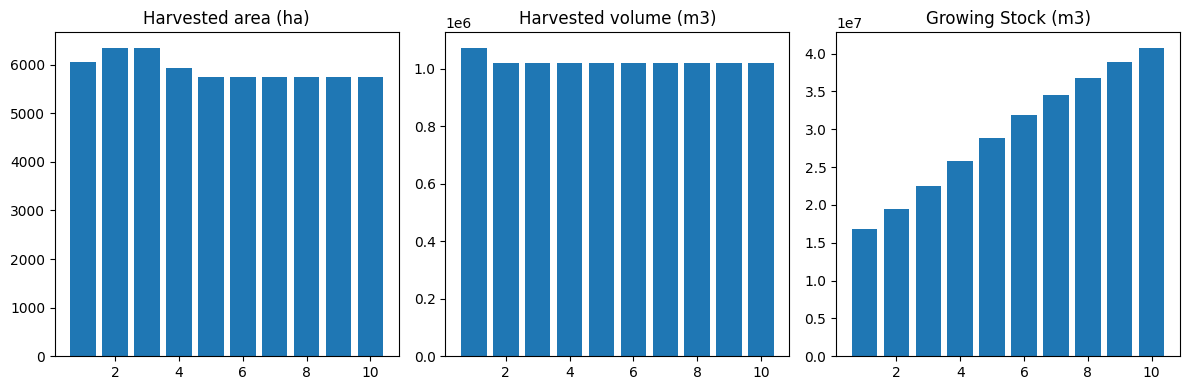

Plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  10831
The economic indicator (the provincial government revenues) is:  369393
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


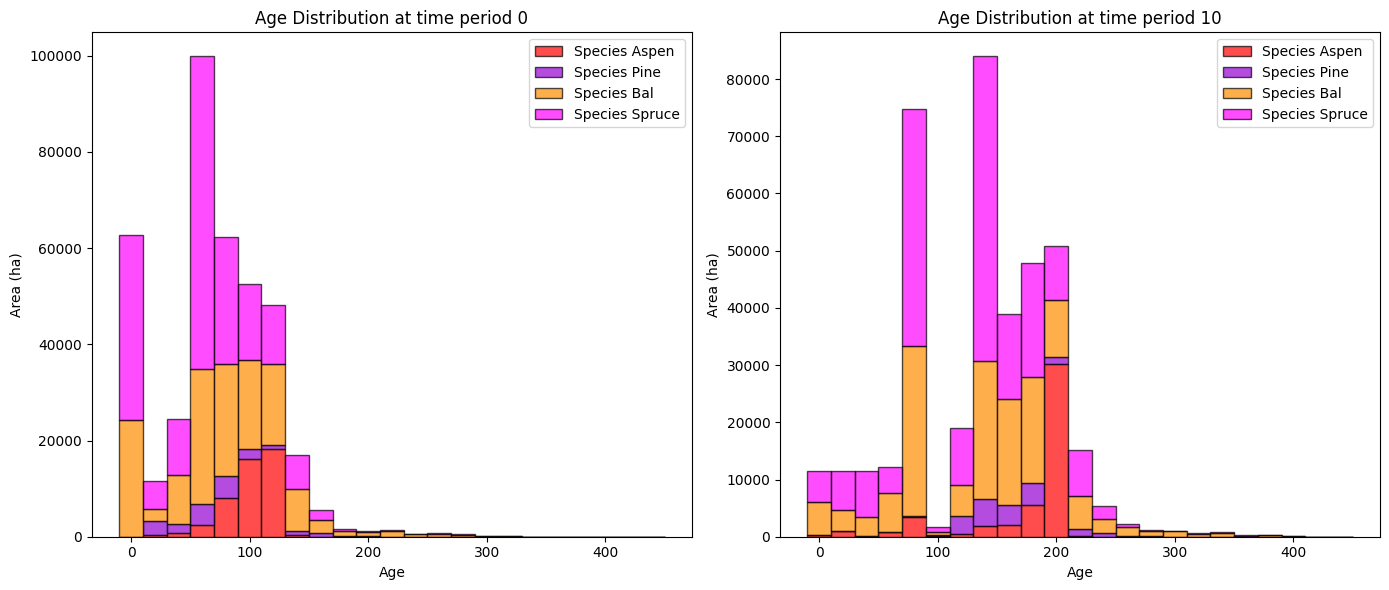

Plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  38766.465357  37821.151669
Pine     602.782616   9274.249263   8671.466647
Bal     4315.588546  35732.277284  31416.688738
Spruce  1072.814408  27525.137232  26452.322824

Overall diversity has **increased** by 104361.63 hectares from time period 0 to time period 10.


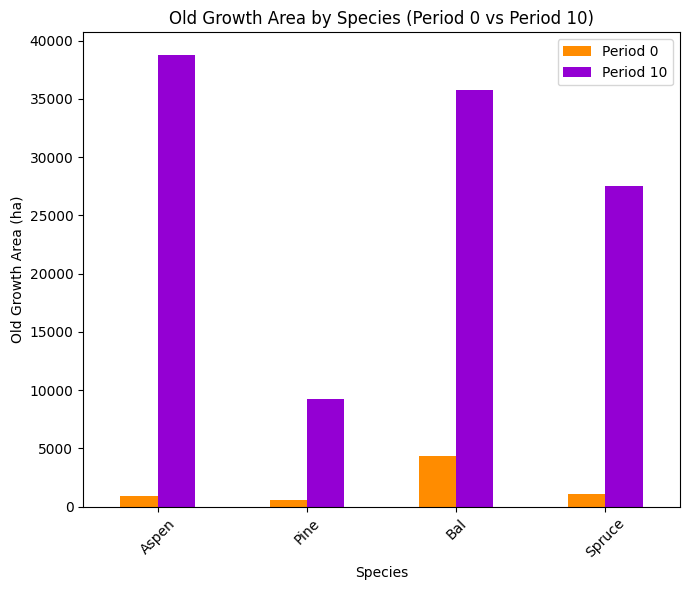

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_old_growth_comparison.pdf

Portion for time period 0:
Aspen: 0.2198
Pine: 0.0581
Bal: 0.4123
Spruce: 0.3099

Portion for time period 10:
Aspen: 0.1252
Pine: 0.0703
Bal: 0.4000
Spruce: 0.4045

Shannon Evennes Index for time period 0: 0.8848
Shannon Evennes Index for time period 10: 0.8507

Diversity has **decreased** by 3.41% from time 0 to time 10.


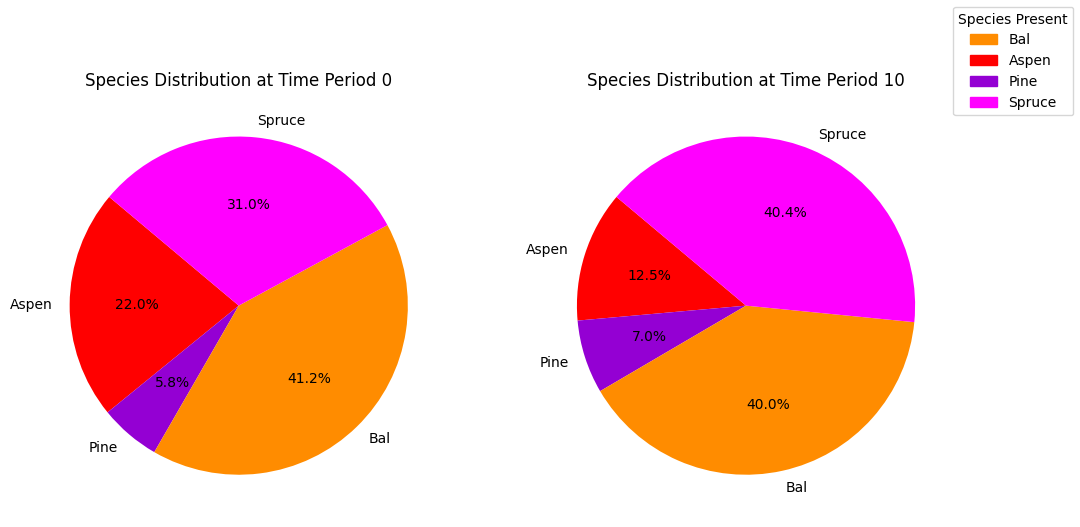

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_species_pie.pdf


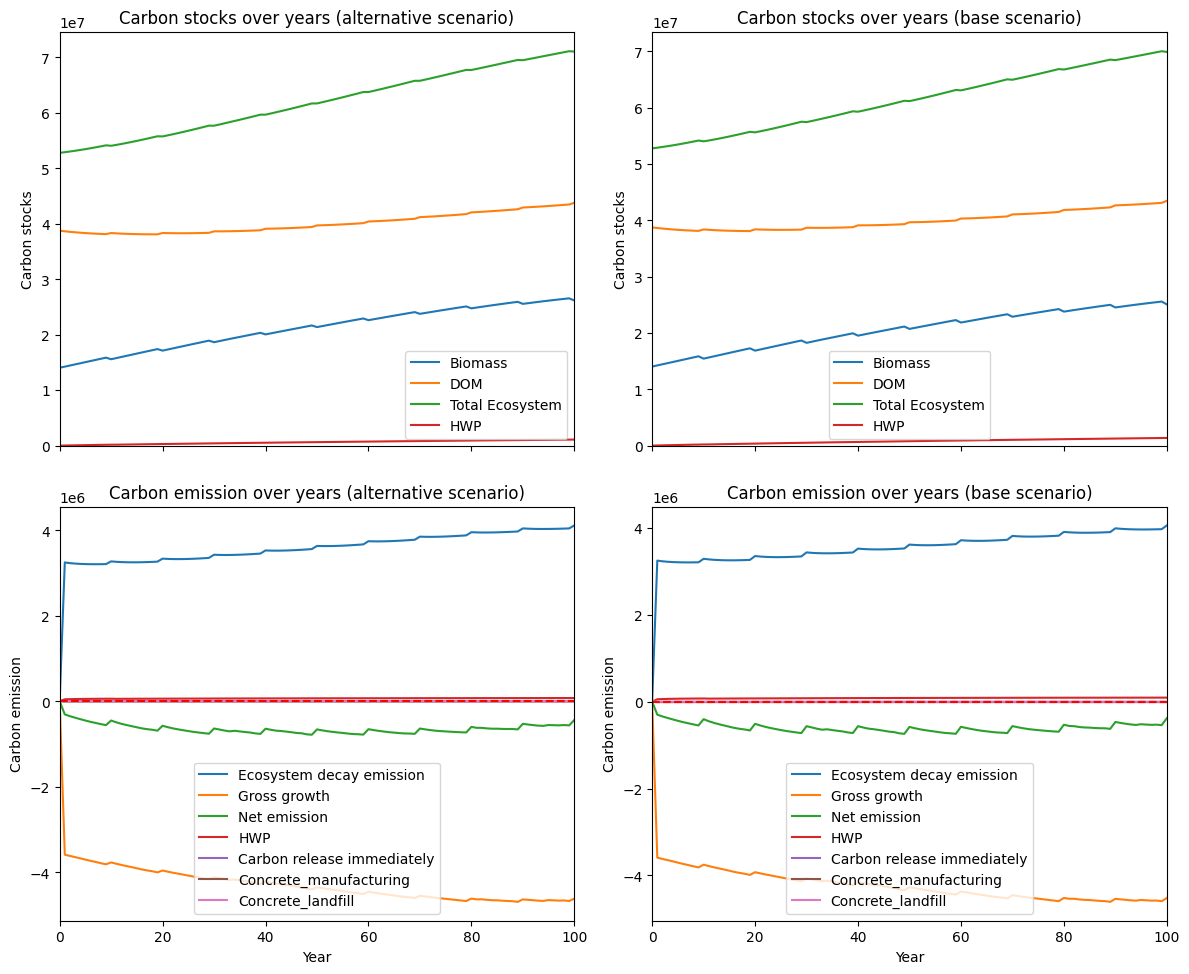

---------------------------------------------------------------------------------------
Net emission difference -726710.930816117
Net emission base scenario -13033576.887944747
Net emission alternative scenario -12306865.95712863
dollar_per_ton is:  13.760629675364475
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Aspen   0.0  1550.092024  1550.092024
Pine    0.0   112.050472   112.050472
Bal     0.0  4100.512938  4100.512938
Spruce  0.0  2016.468073  2016.468073

Overall, the old growth area has **increased** by 7779.12 hectares in the alternative scenario compared to the base scenario.


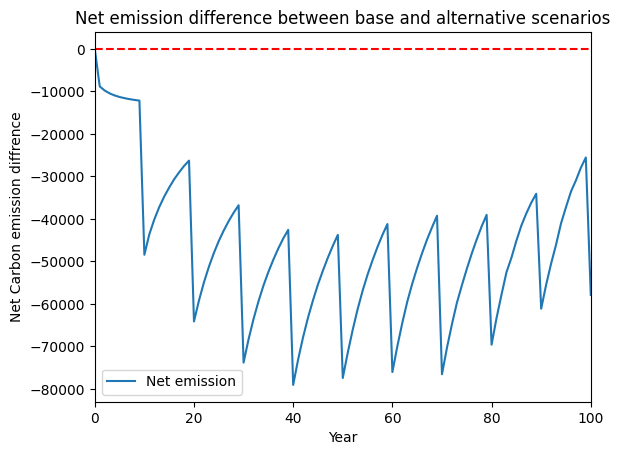

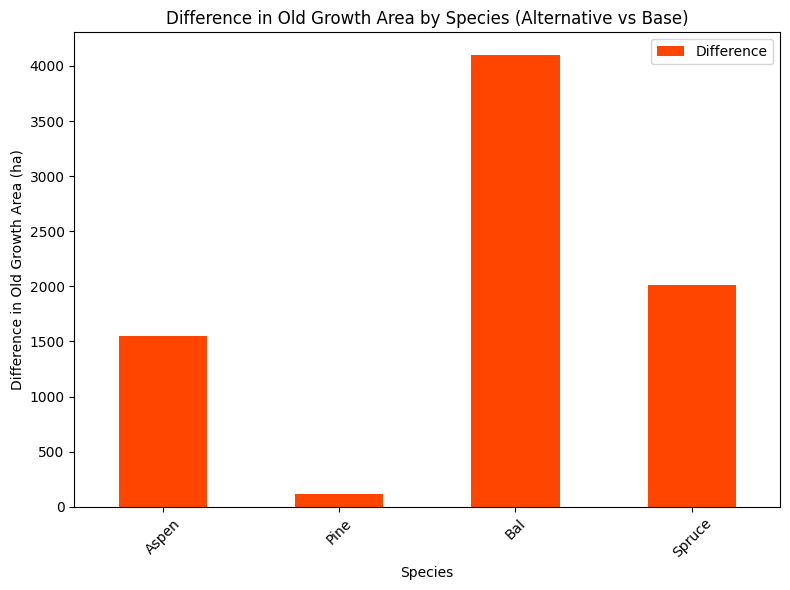

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/redchris/redchris_min_ha_kpi_age_difference.pdf


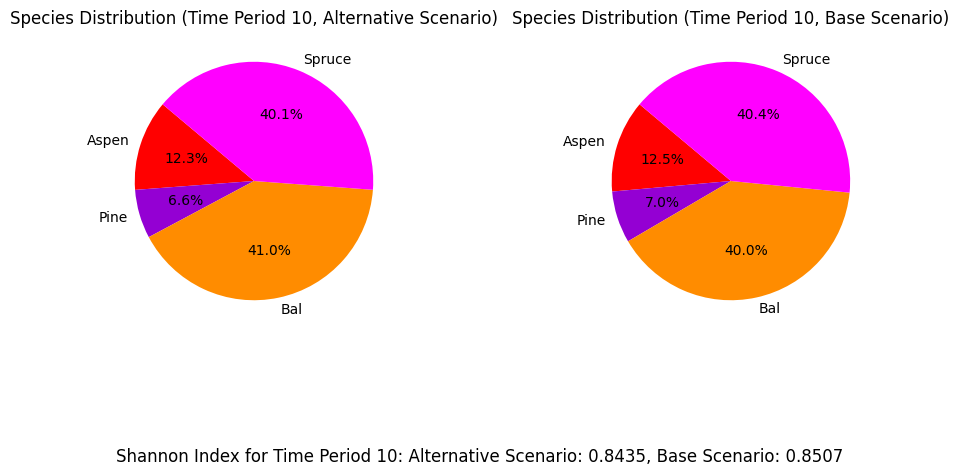

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_ha_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for redchris_min_ha_redchrs_AAC_70%...
running the scenario for the Red Chris mining site (70%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0xf9afafba
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-01, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.18s
Presolved: 1699 rows, 30867 column

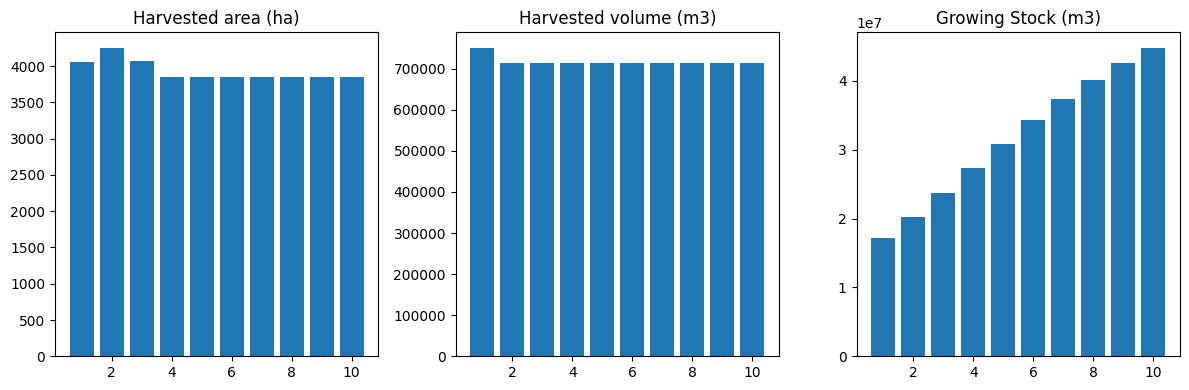

Plot saved to ./outputs/fig/redchris/redchris_min_ha_redchrs_AAC_70%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  7582
The economic indicator (the provincial government revenues) is:  258575
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


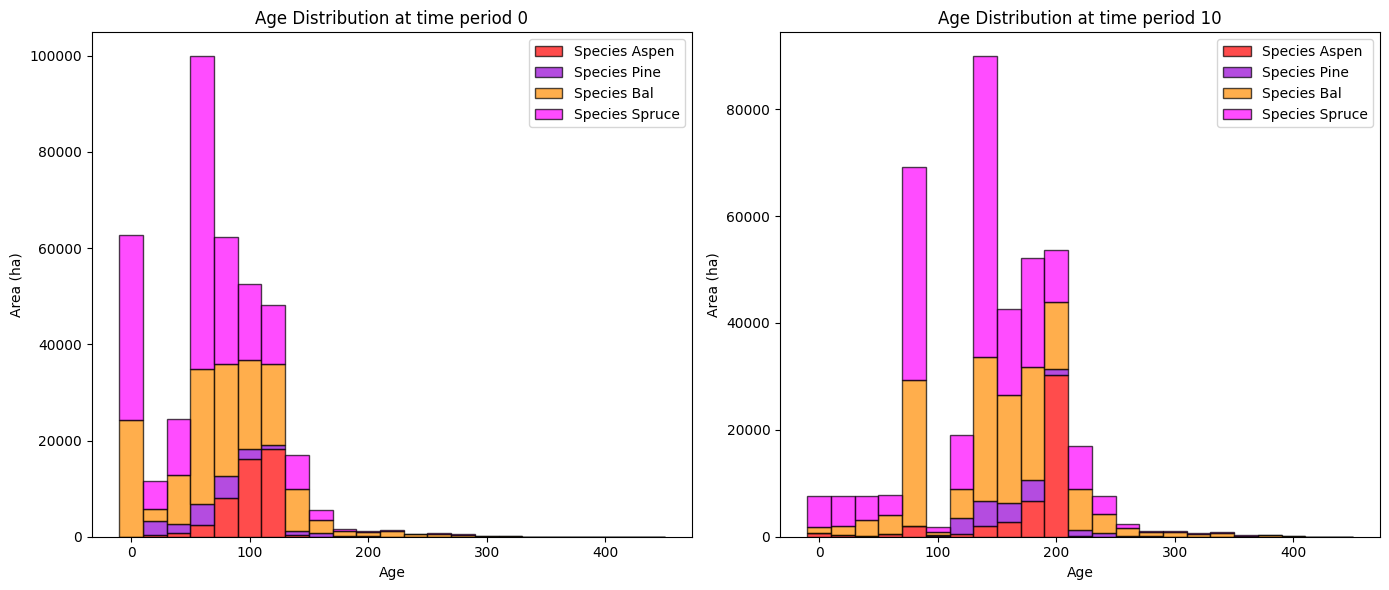

Plot saved to ./outputs/fig/redchris/redchris_min_ha_redchrs_AAC_70%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  40856.542310  39911.228622
Pine     602.782616   9369.680902   8766.898286
Bal     4315.588546  42534.432447  38218.843901
Spruce  1072.814408  29753.425642  28680.611234

Overall diversity has **increased** by 115577.58 hectares from time period 0 to time period 10.


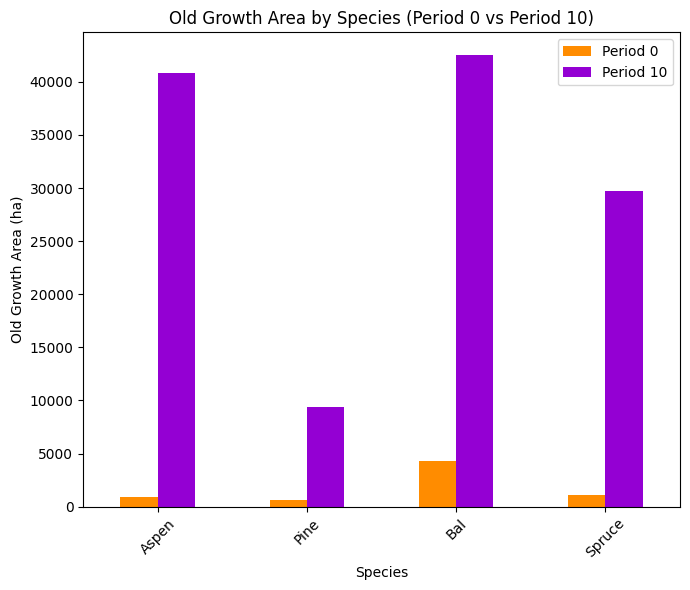

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_ha_redchrs_AAC_70%_old_growth_comparison.pdf

Portion for time period 0:
Aspen: 0.2198
Pine: 0.0581
Bal: 0.4123
Spruce: 0.3099

Portion for time period 10:
Aspen: 0.1188
Pine: 0.0641
Bal: 0.4191
Spruce: 0.3980

Shannon Evennes Index for time period 0: 0.8848
Shannon Evennes Index for time period 10: 0.8370

Diversity has **decreased** by 4.79% from time 0 to time 10.


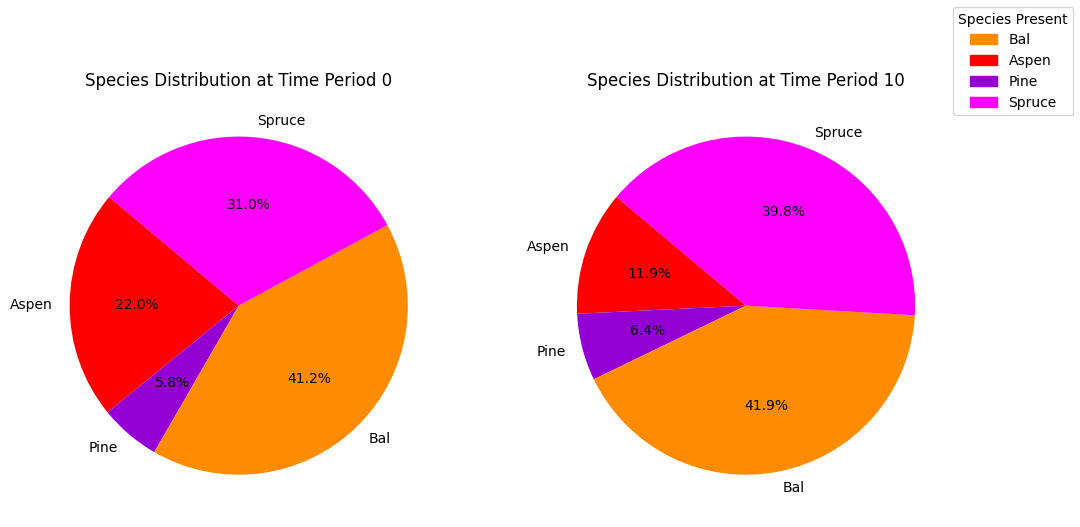

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_ha_redchrs_AAC_70%_species_pie.pdf
running business as usual scenario for the Red Chris mining site,
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x97ce50eb
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-01, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.18s
Presolved: 1699 rows, 30866 columns, 420629 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time:

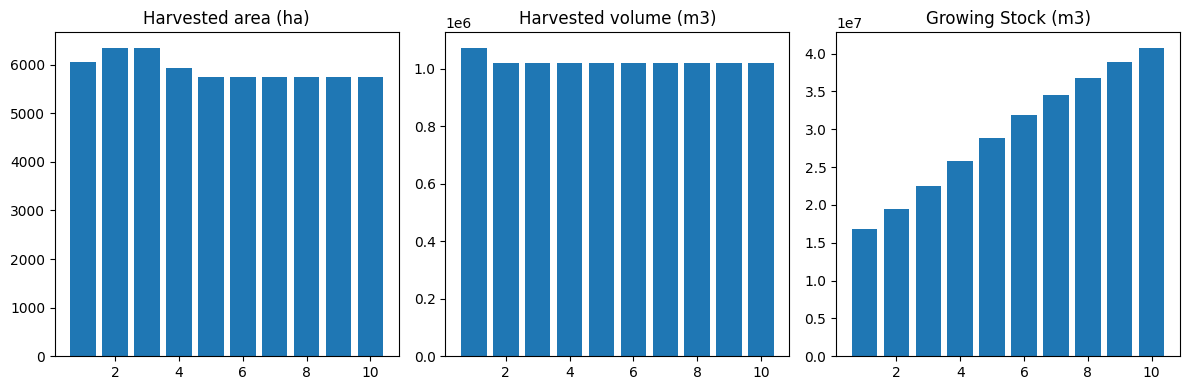

Plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  10831
The economic indicator (the provincial government revenues) is:  369393
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


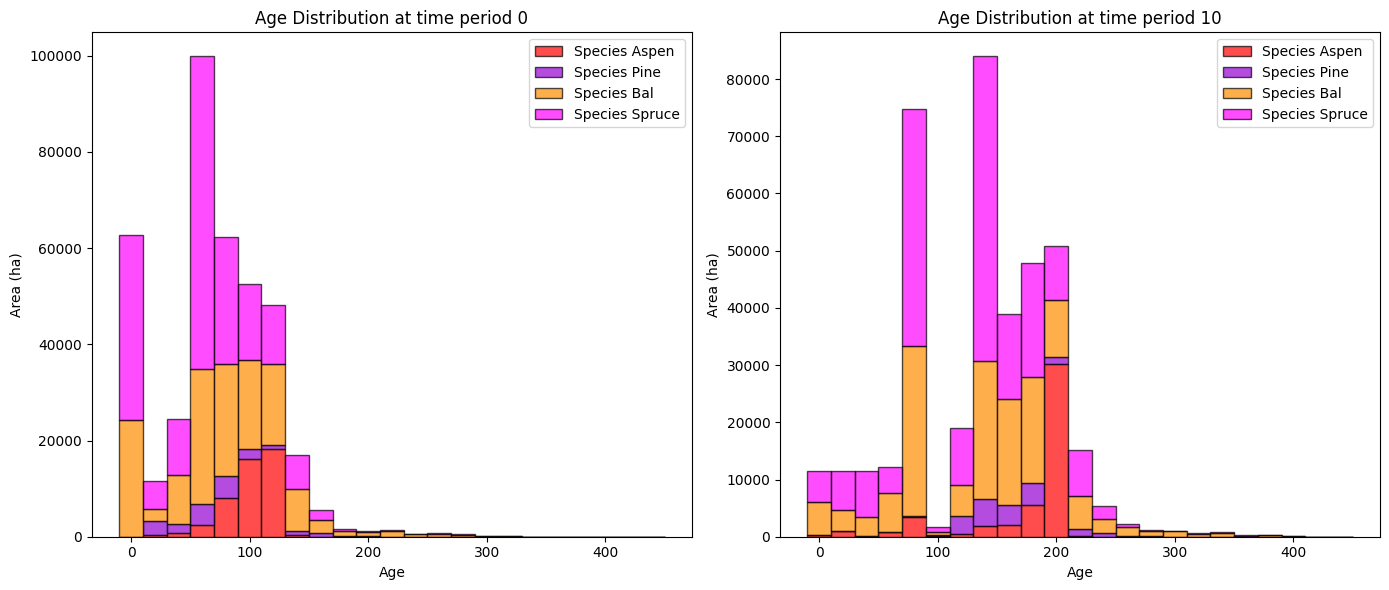

Plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  38766.465357  37821.151669
Pine     602.782616   9274.249263   8671.466647
Bal     4315.588546  35732.277284  31416.688738
Spruce  1072.814408  27525.137232  26452.322824

Overall diversity has **increased** by 104361.63 hectares from time period 0 to time period 10.


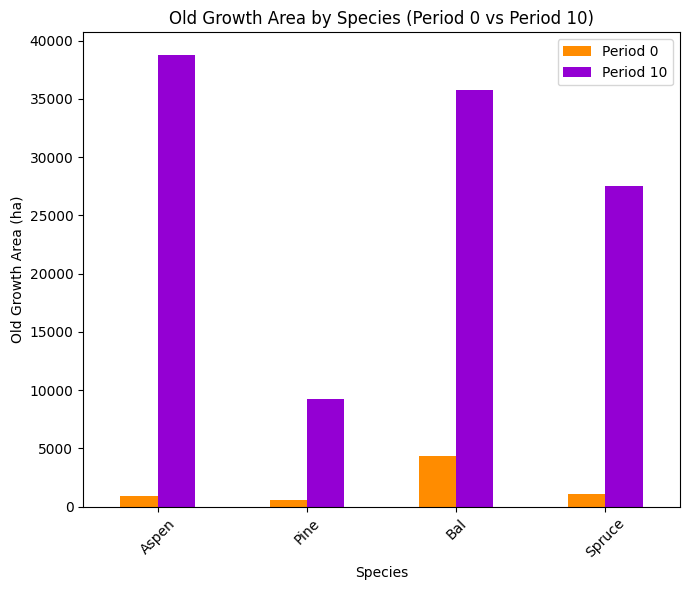

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_old_growth_comparison.pdf

Portion for time period 0:
Aspen: 0.2198
Pine: 0.0581
Bal: 0.4123
Spruce: 0.3099

Portion for time period 10:
Aspen: 0.1252
Pine: 0.0703
Bal: 0.4000
Spruce: 0.4045

Shannon Evennes Index for time period 0: 0.8848
Shannon Evennes Index for time period 10: 0.8507

Diversity has **decreased** by 3.41% from time 0 to time 10.


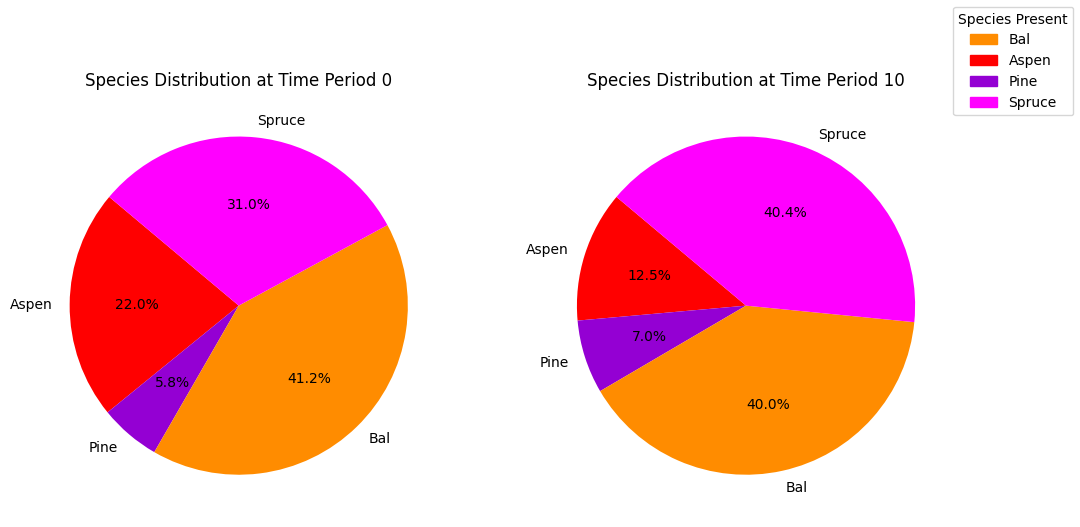

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_species_pie.pdf


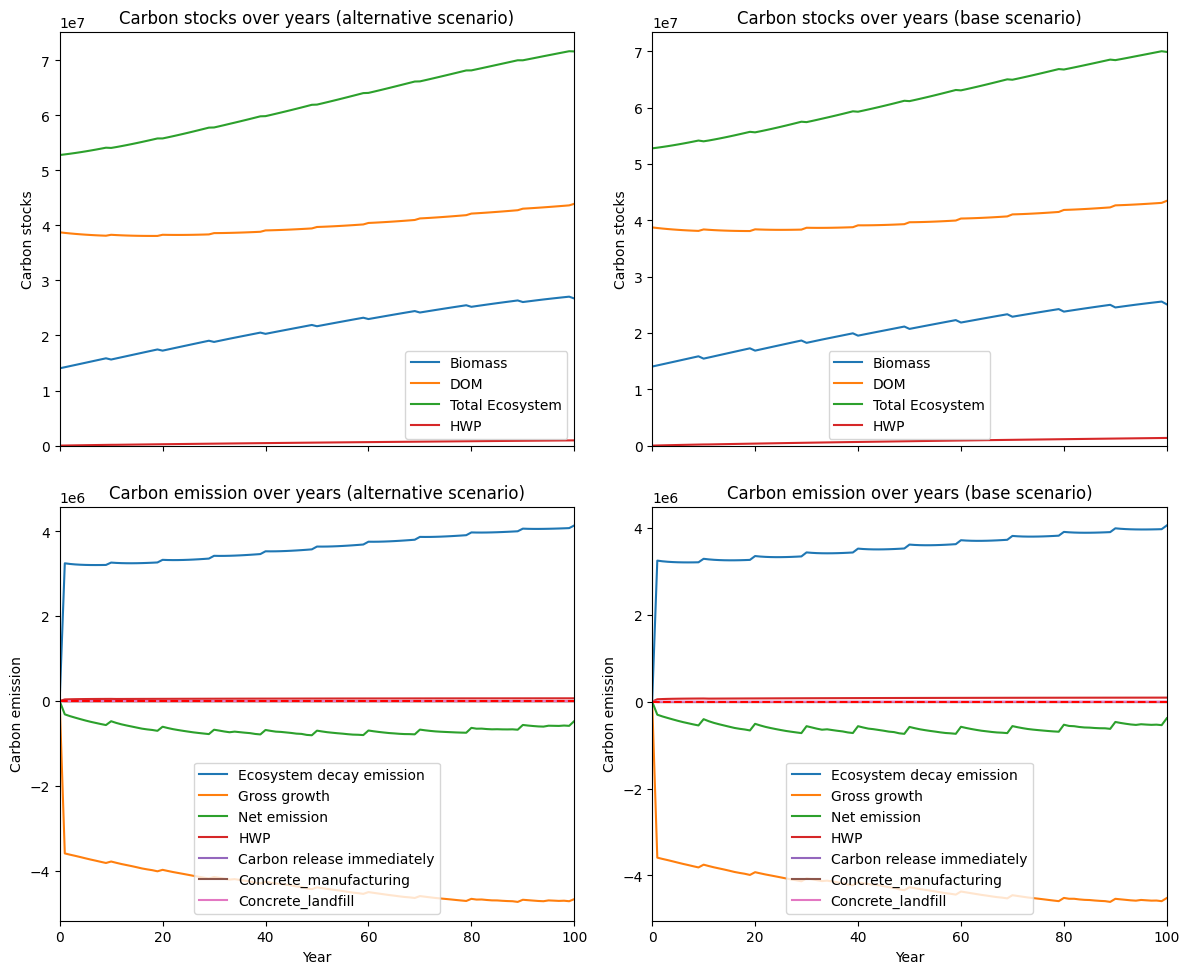

---------------------------------------------------------------------------------------
Net emission difference -1077674.7647531503
Net emission base scenario -13384540.721881779
Net emission alternative scenario -12306865.95712863
dollar_per_ton is:  9.279237416578626
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Aspen   0.0  2090.076953  2090.076953
Pine    0.0    95.431639    95.431639
Bal     0.0  6802.155162  6802.155162
Spruce  0.0  2228.288410  2228.288410

Overall, the old growth area has **increased** by 11215.95 hectares in the alternative scenario compared to the base scenario.


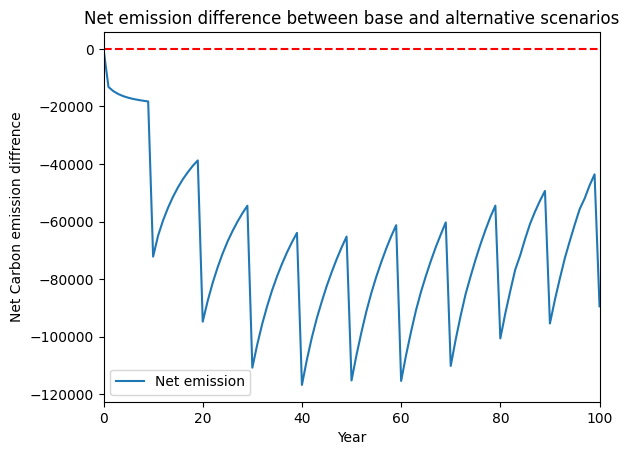

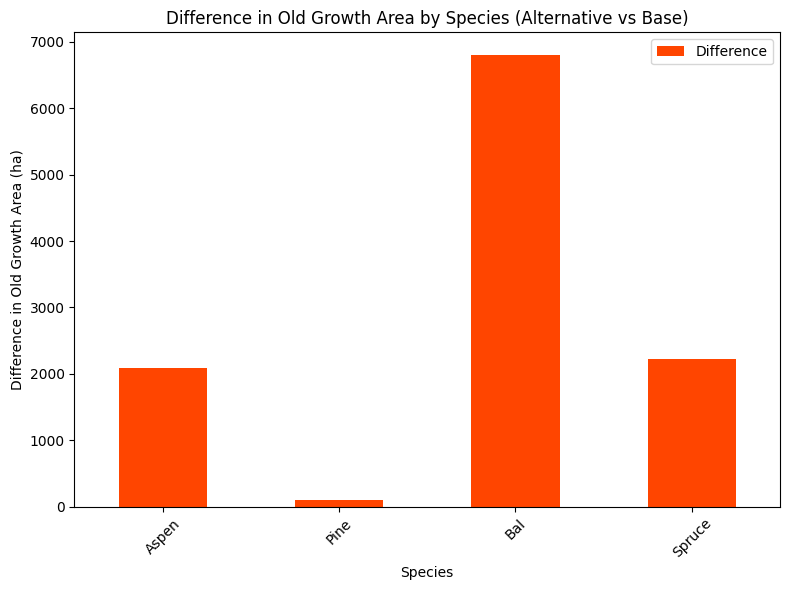

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/redchris/redchris_min_ha_kpi_age_difference.pdf


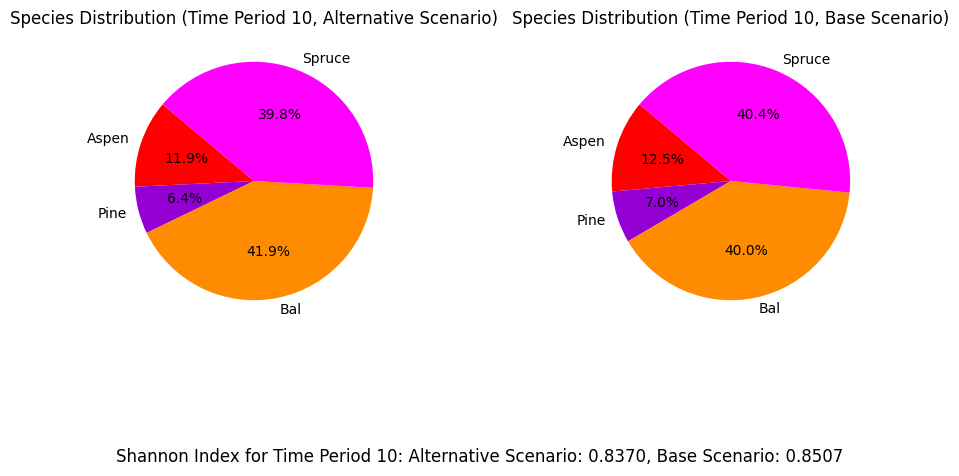

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_ha_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for redchris_min_ha_redchrs_AAC_60%...
running the scenario for the Red Chris mining site (60%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x02e1d640
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-01, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.19s
Presolved: 1699 rows, 30867 column

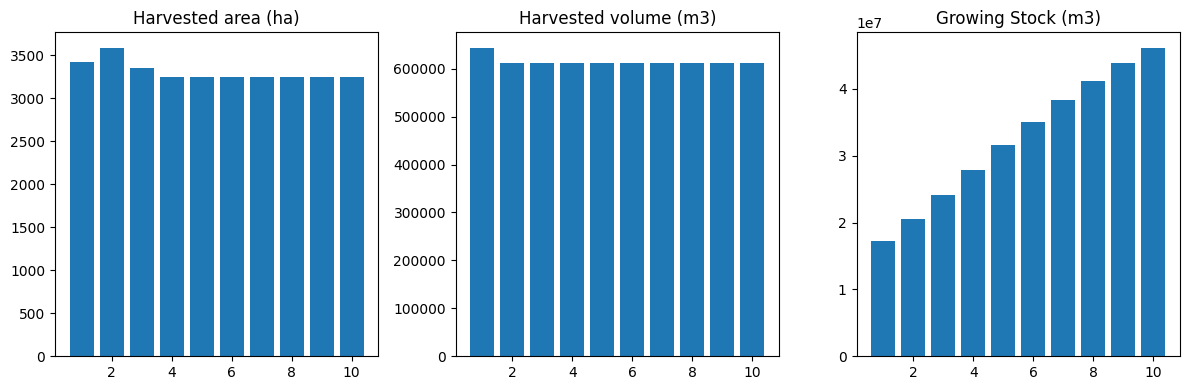

Plot saved to ./outputs/fig/redchris/redchris_min_ha_redchrs_AAC_60%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  6499
The economic indicator (the provincial government revenues) is:  221636
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


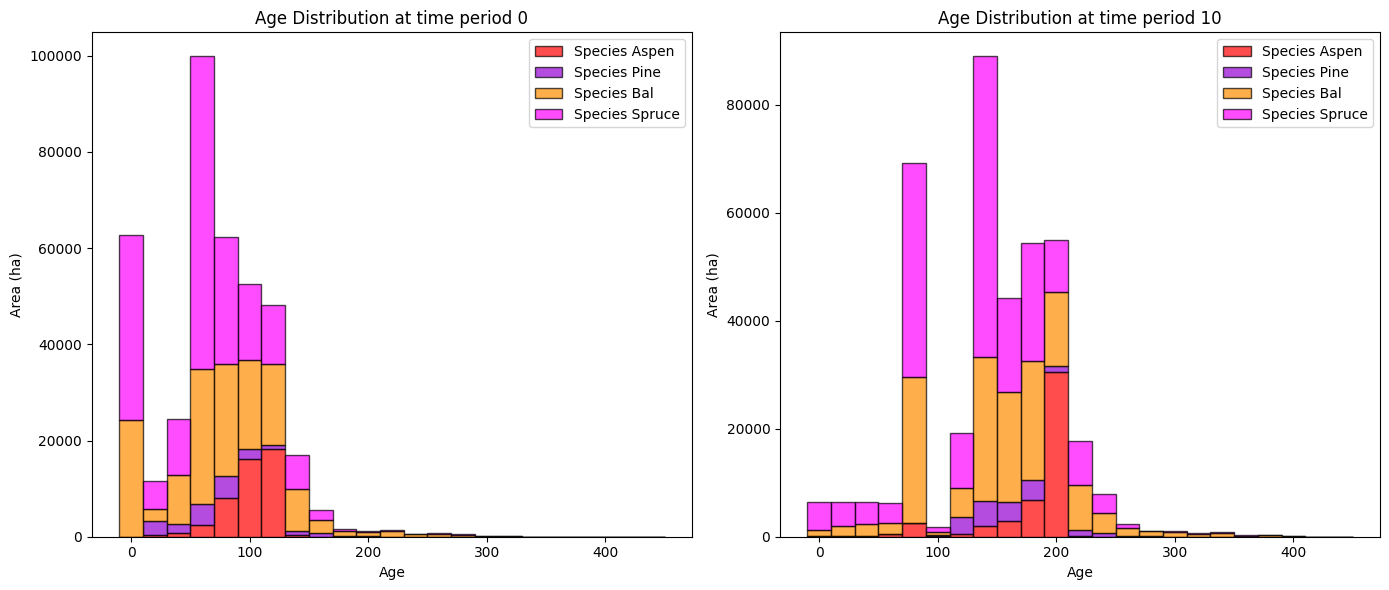

Plot saved to ./outputs/fig/redchris/redchris_min_ha_redchrs_AAC_60%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  41105.598949  40160.285261
Pine     602.782616   9389.986273   8787.203656
Bal     4315.588546  44864.227363  40548.638817
Spruce  1072.814408  31124.063702  30051.249294

Overall diversity has **increased** by 119547.38 hectares from time period 0 to time period 10.


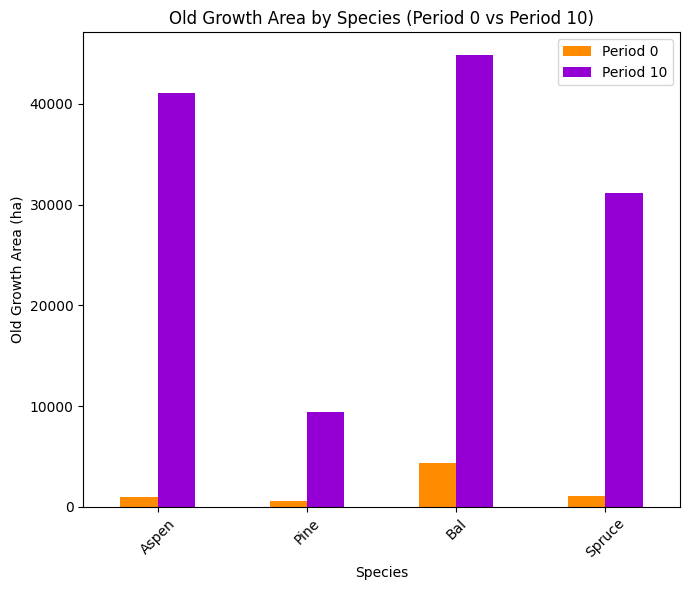

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_ha_redchrs_AAC_60%_old_growth_comparison.pdf

Portion for time period 0:
Aspen: 0.2198
Pine: 0.0581
Bal: 0.4123
Spruce: 0.3099

Portion for time period 10:
Aspen: 0.1182
Pine: 0.0623
Bal: 0.4187
Spruce: 0.4008

Shannon Evennes Index for time period 0: 0.8848
Shannon Evennes Index for time period 10: 0.8341

Diversity has **decreased** by 5.07% from time 0 to time 10.


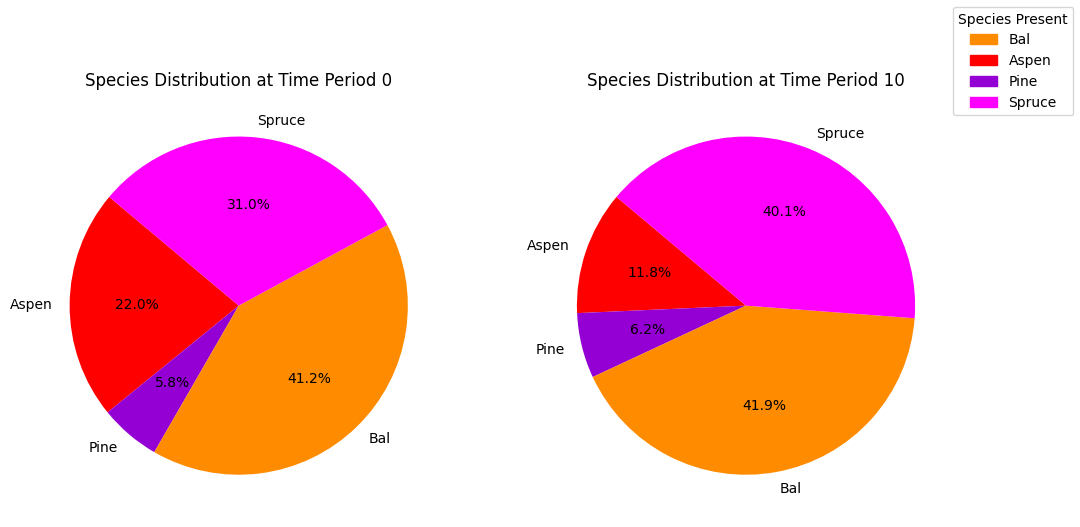

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_ha_redchrs_AAC_60%_species_pie.pdf
running business as usual scenario for the Red Chris mining site,
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x97ce50eb
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-01, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.18s
Presolved: 1699 rows, 30866 columns, 420629 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time:

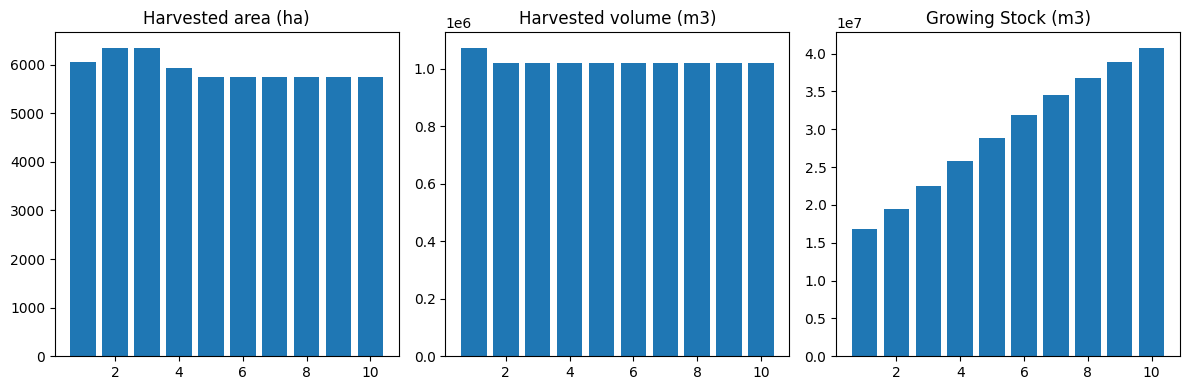

Plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  10831
The economic indicator (the provincial government revenues) is:  369393
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


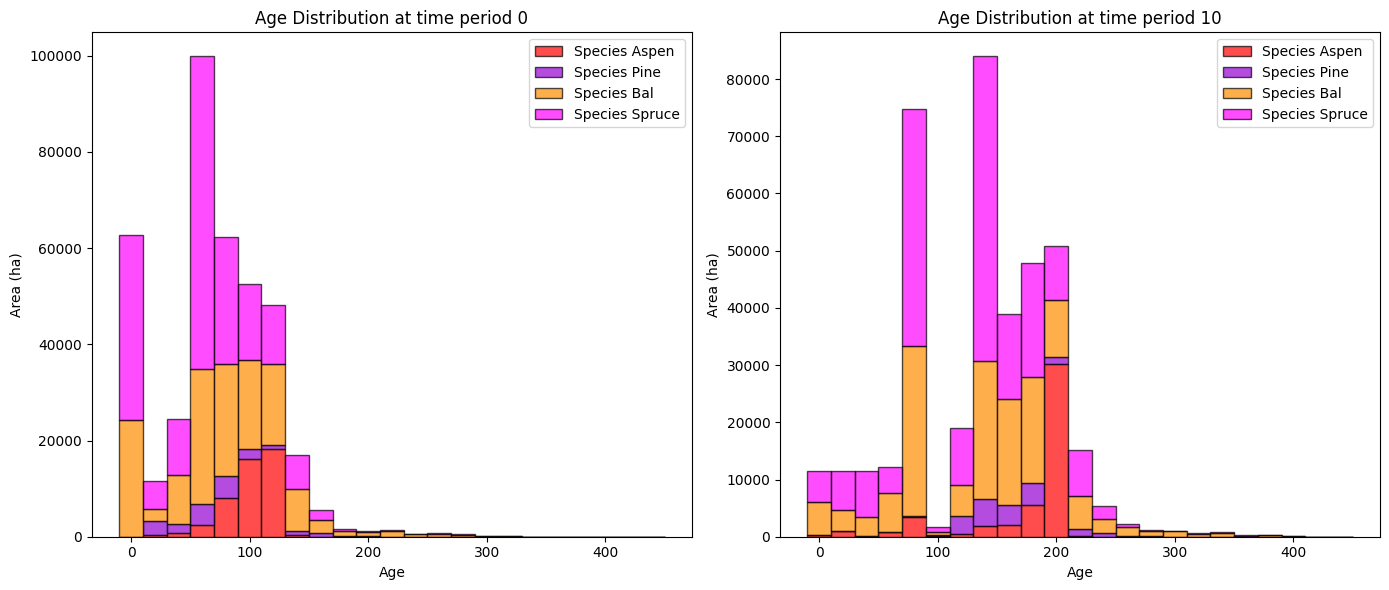

Plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  38766.465357  37821.151669
Pine     602.782616   9274.249263   8671.466647
Bal     4315.588546  35732.277284  31416.688738
Spruce  1072.814408  27525.137232  26452.322824

Overall diversity has **increased** by 104361.63 hectares from time period 0 to time period 10.


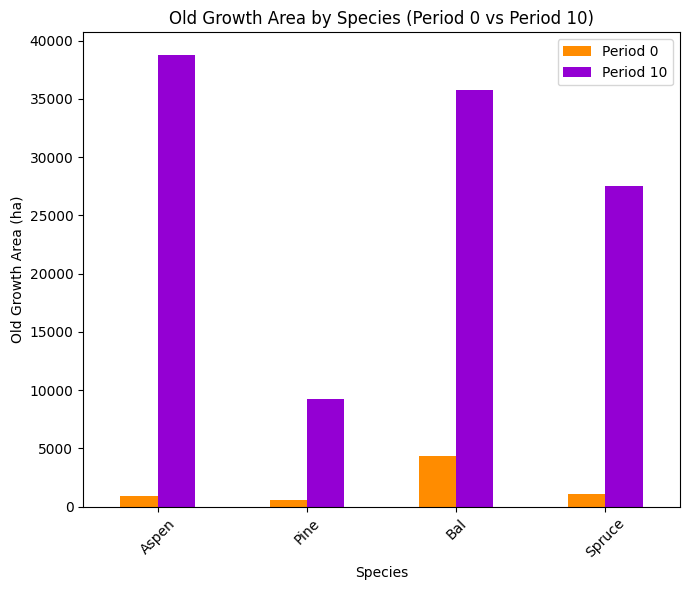

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_old_growth_comparison.pdf

Portion for time period 0:
Aspen: 0.2198
Pine: 0.0581
Bal: 0.4123
Spruce: 0.3099

Portion for time period 10:
Aspen: 0.1252
Pine: 0.0703
Bal: 0.4000
Spruce: 0.4045

Shannon Evennes Index for time period 0: 0.8848
Shannon Evennes Index for time period 10: 0.8507

Diversity has **decreased** by 3.41% from time 0 to time 10.


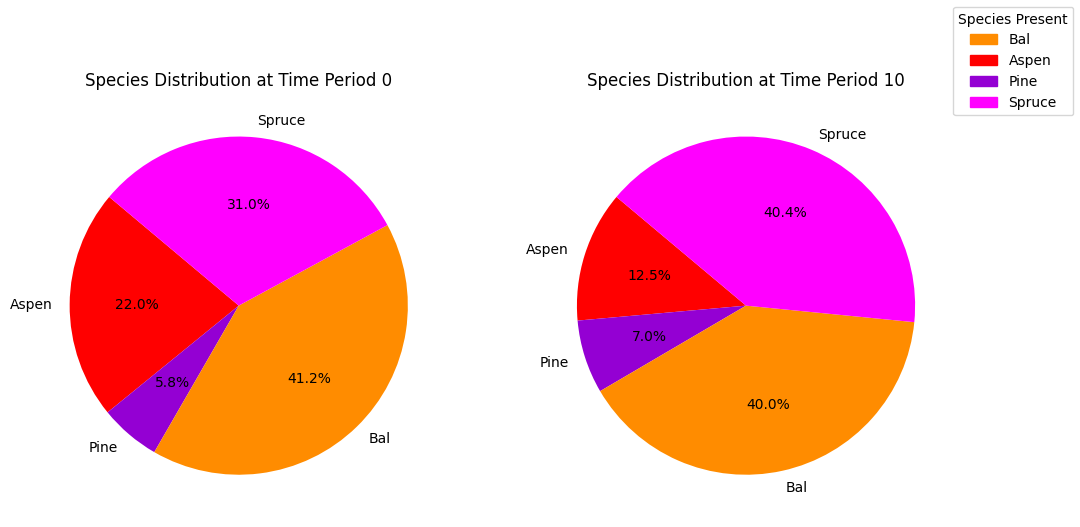

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_species_pie.pdf


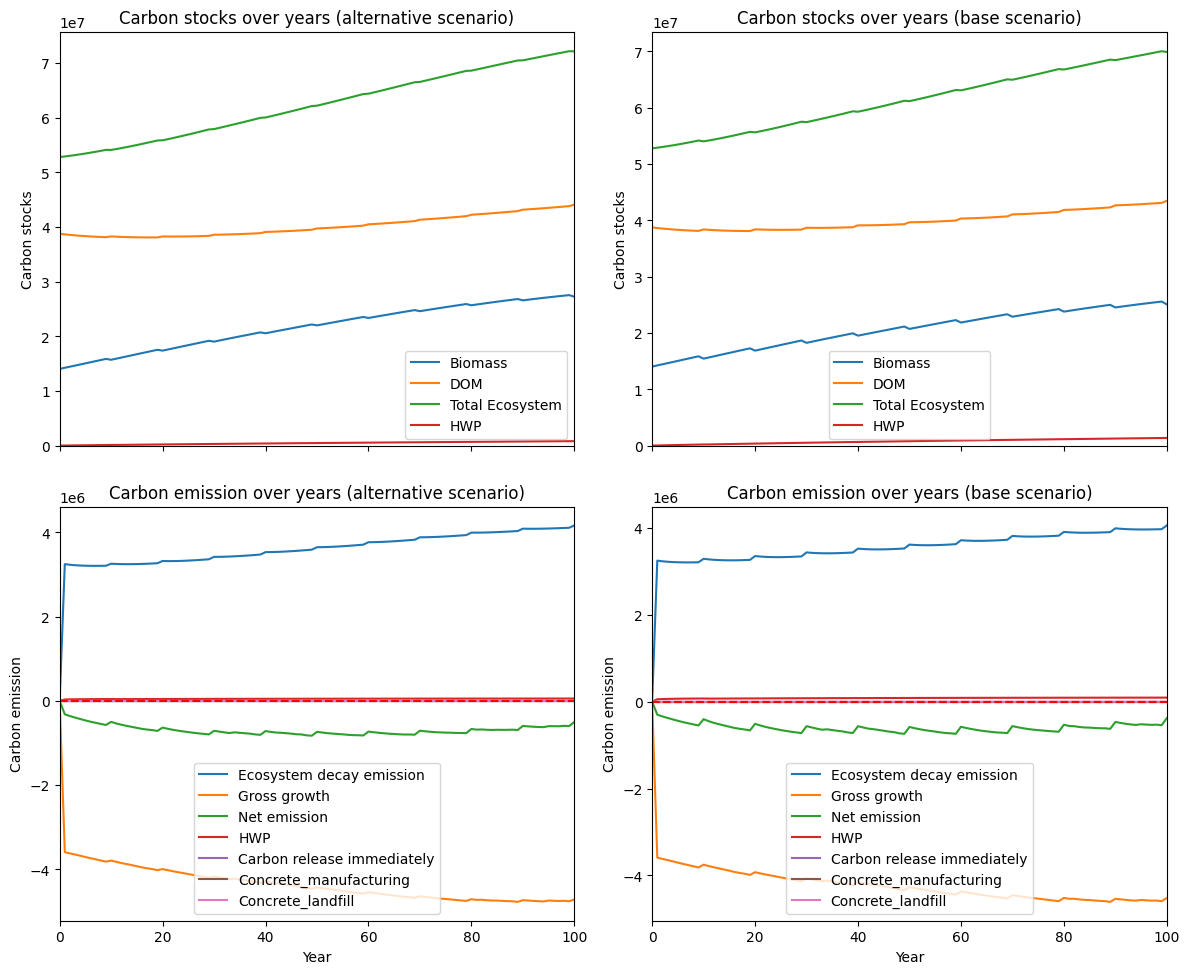

---------------------------------------------------------------------------------------
Net emission difference -1416337.4930128218
Net emission base scenario -13723203.45014145
Net emission alternative scenario -12306865.95712863
dollar_per_ton is:  7.06046408383081
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Aspen   0.0  2339.133592  2339.133592
Pine    0.0   115.737010   115.737010
Bal     0.0  9131.950079  9131.950079
Spruce  0.0  3598.926470  3598.926470

Overall, the old growth area has **increased** by 15185.75 hectares in the alternative scenario compared to the base scenario.


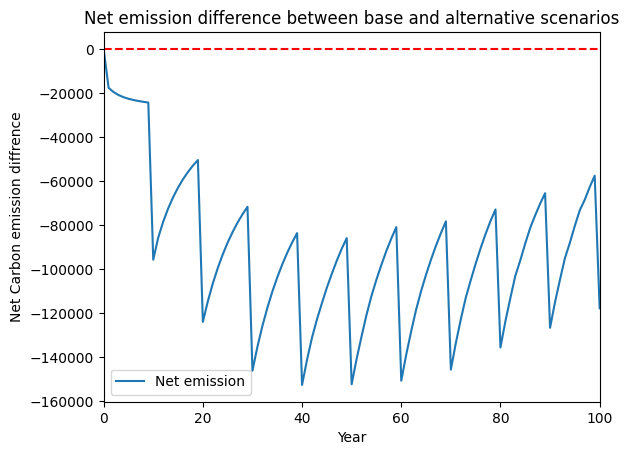

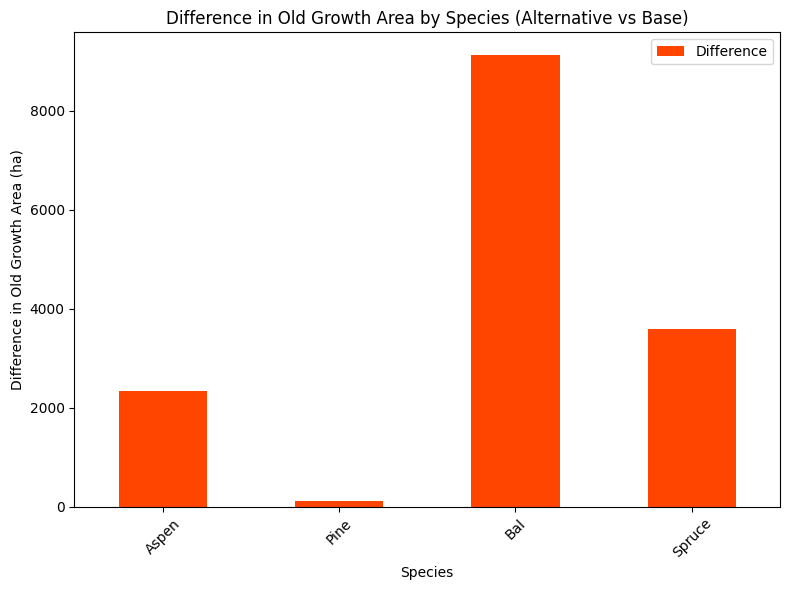

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/redchris/redchris_min_ha_kpi_age_difference.pdf


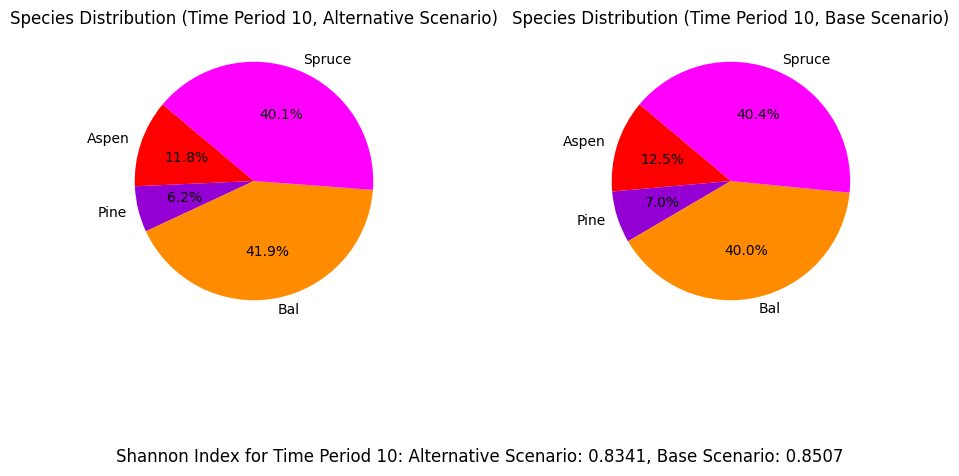

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_ha_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for redchris_min_ha_redchrs_AAC_50%...
running the scenario for the Red Chris mining site (50%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x492da32d
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-01, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.18s
Presolved: 1699 rows, 30867 column

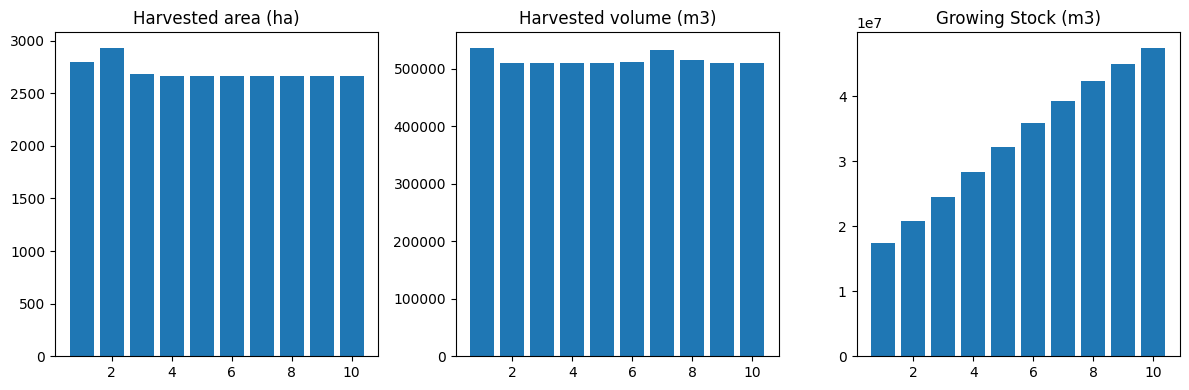

Plot saved to ./outputs/fig/redchris/redchris_min_ha_redchrs_AAC_50%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  5449
The economic indicator (the provincial government revenues) is:  185826
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


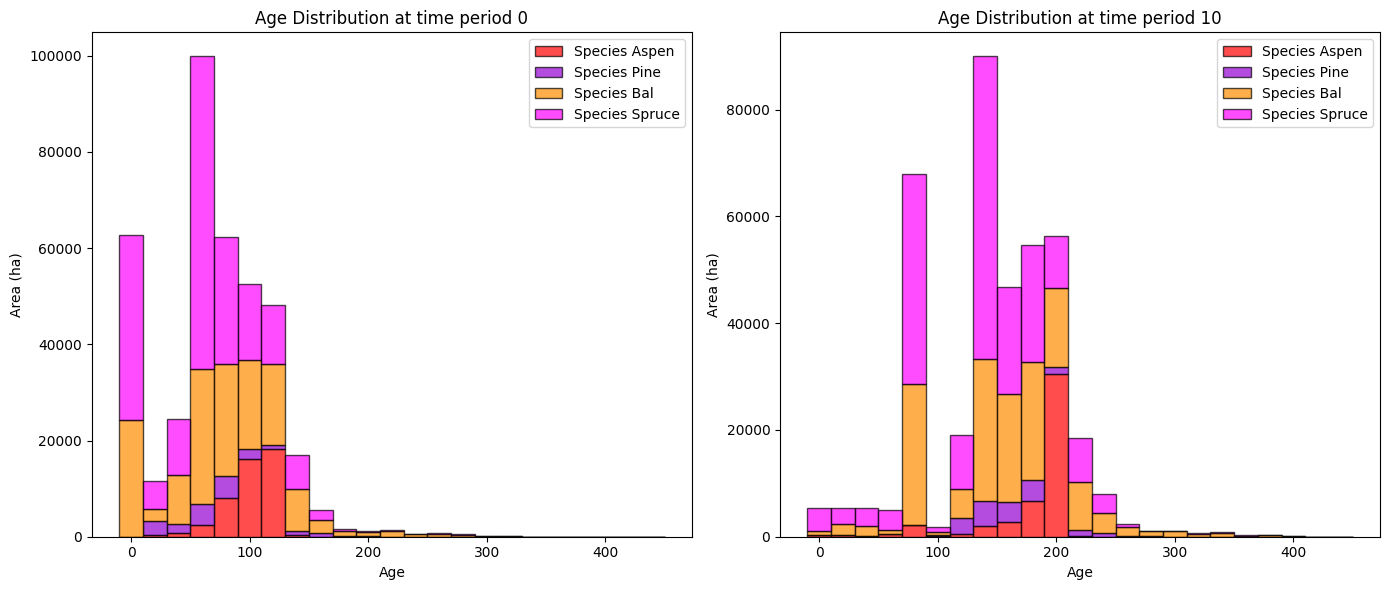

Plot saved to ./outputs/fig/redchris/redchris_min_ha_redchrs_AAC_50%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  41142.000914  40196.687226
Pine     602.782616   9389.986273   8787.203656
Bal     4315.588546  47137.582745  42821.994199
Spruce  1072.814408  32139.330714  31066.516307

Overall diversity has **increased** by 122872.40 hectares from time period 0 to time period 10.


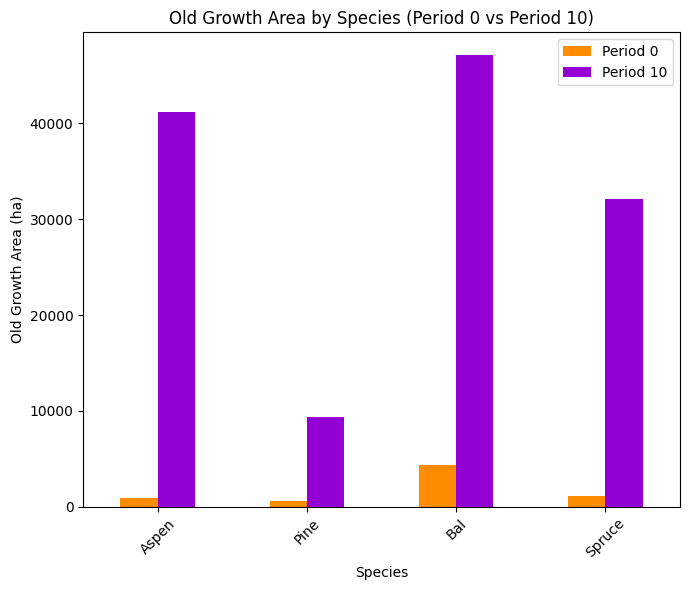

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_ha_redchrs_AAC_50%_old_growth_comparison.pdf

Portion for time period 0:
Aspen: 0.2198
Pine: 0.0581
Bal: 0.4123
Spruce: 0.3099

Portion for time period 10:
Aspen: 0.1138
Pine: 0.0606
Bal: 0.4174
Spruce: 0.4082

Shannon Evennes Index for time period 0: 0.8848
Shannon Evennes Index for time period 10: 0.8279

Diversity has **decreased** by 5.70% from time 0 to time 10.


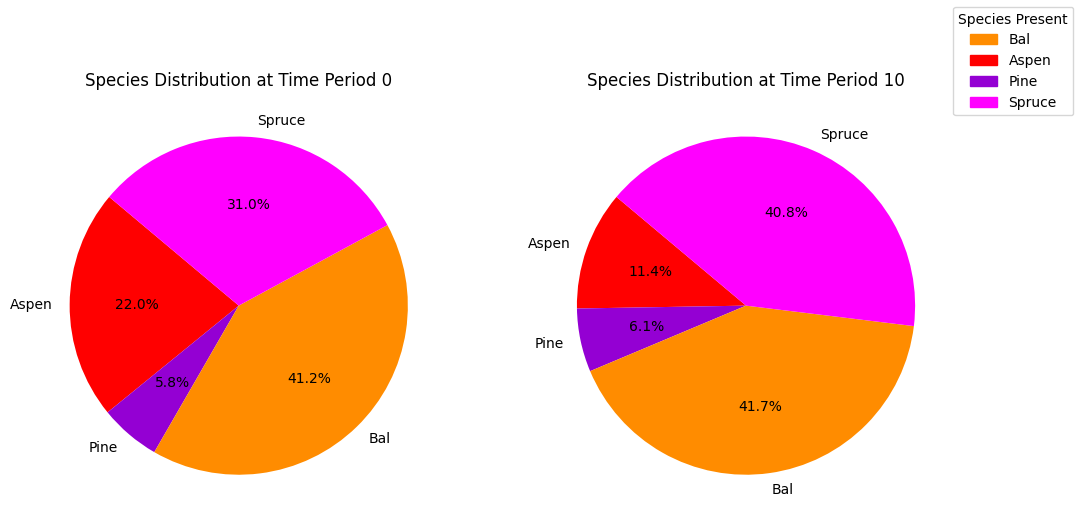

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_ha_redchrs_AAC_50%_species_pie.pdf
running business as usual scenario for the Red Chris mining site,
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x97ce50eb
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-01, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.19s
Presolved: 1699 rows, 30866 columns, 420629 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time:

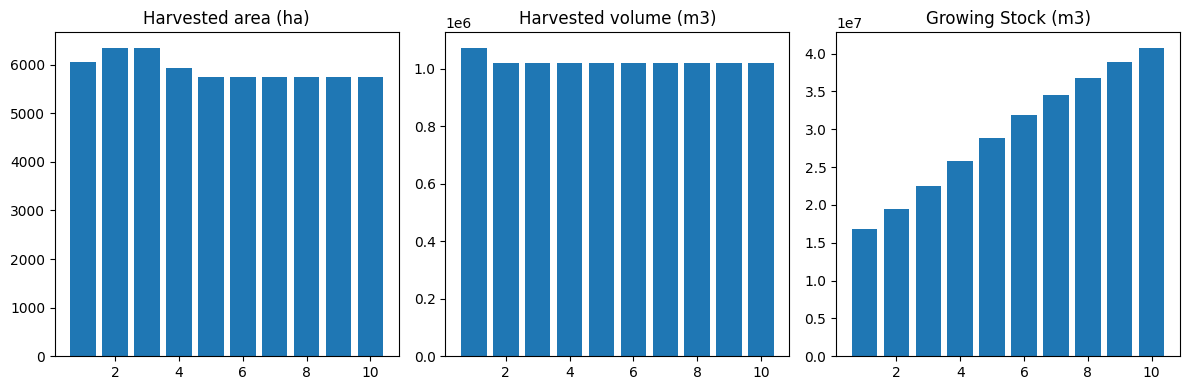

Plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  10831
The economic indicator (the provincial government revenues) is:  369393
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


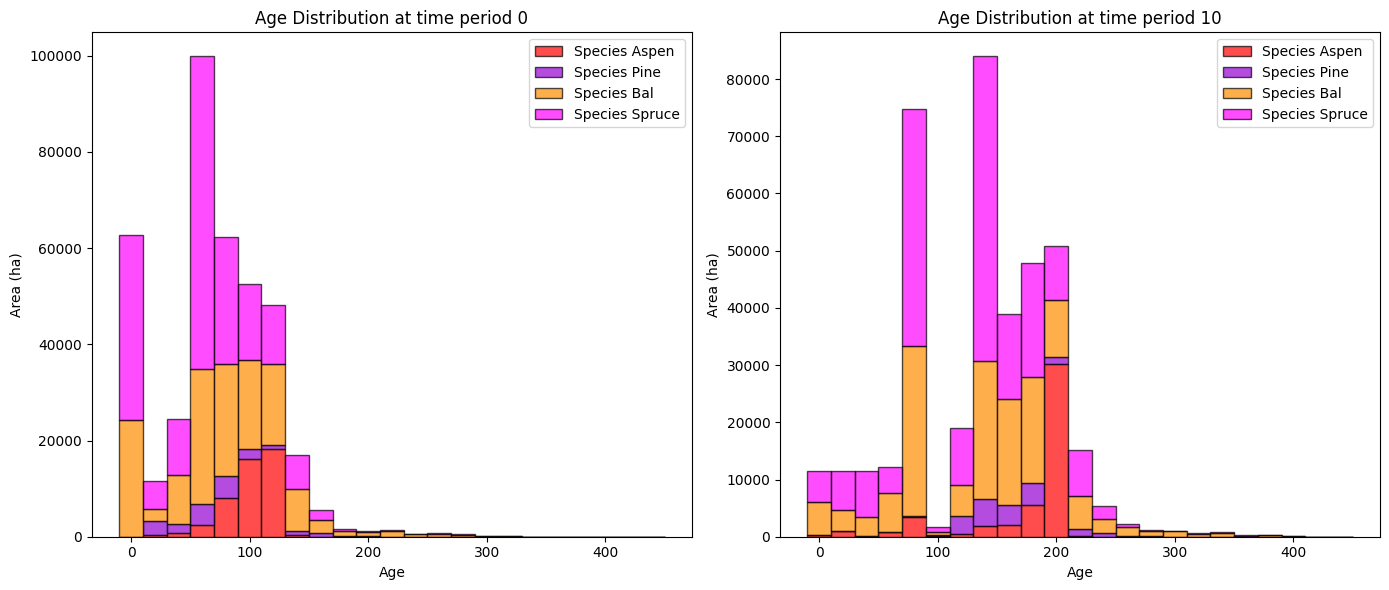

Plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  38766.465357  37821.151669
Pine     602.782616   9274.249263   8671.466647
Bal     4315.588546  35732.277284  31416.688738
Spruce  1072.814408  27525.137232  26452.322824

Overall diversity has **increased** by 104361.63 hectares from time period 0 to time period 10.


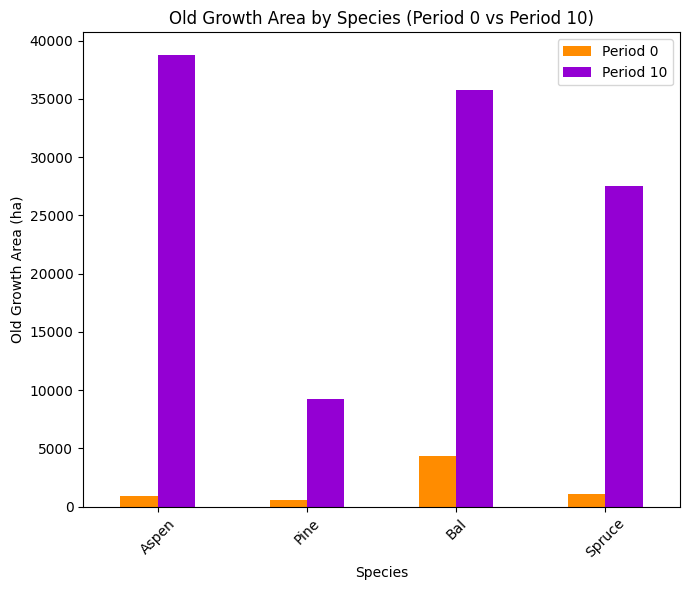

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_old_growth_comparison.pdf

Portion for time period 0:
Aspen: 0.2198
Pine: 0.0581
Bal: 0.4123
Spruce: 0.3099

Portion for time period 10:
Aspen: 0.1252
Pine: 0.0703
Bal: 0.4000
Spruce: 0.4045

Shannon Evennes Index for time period 0: 0.8848
Shannon Evennes Index for time period 10: 0.8507

Diversity has **decreased** by 3.41% from time 0 to time 10.


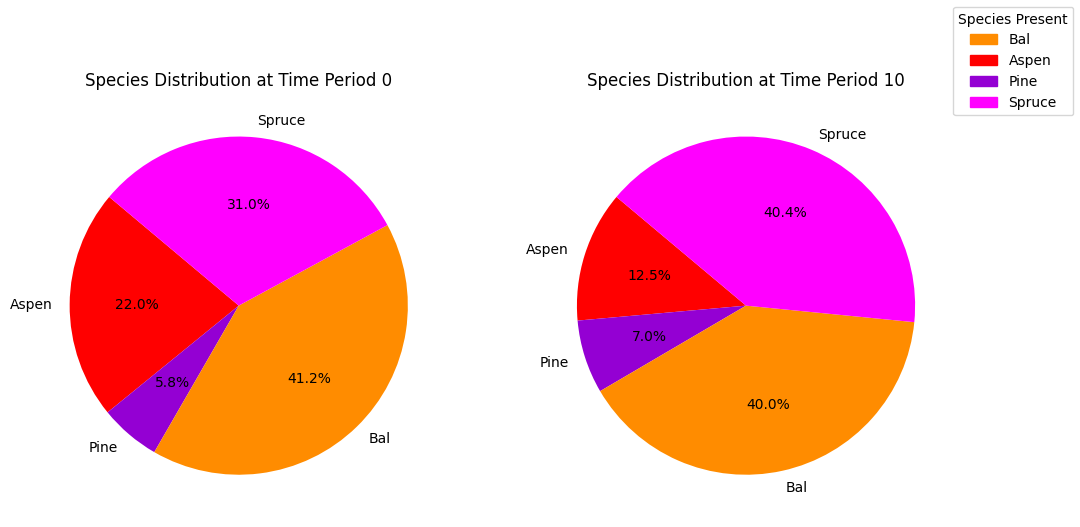

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_species_pie.pdf
Saved cbm_output_1 and cbm_output_2 as pickle files.


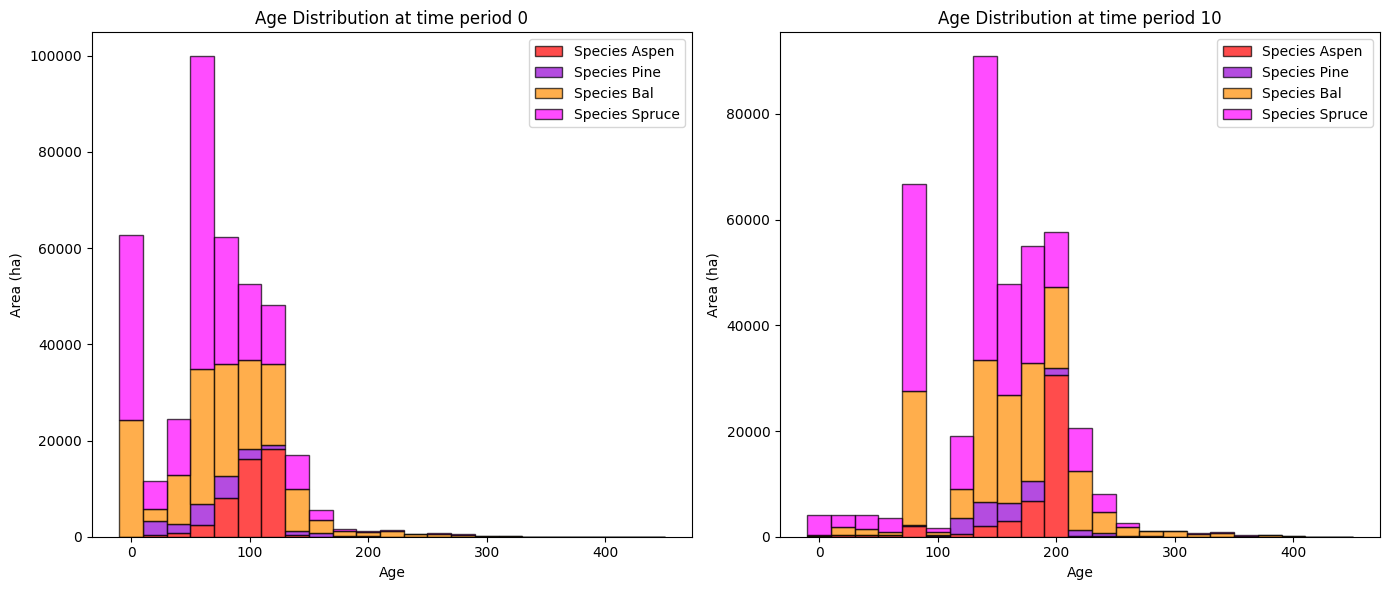

Plot saved to ./outputs/fig/redchris/redchris_min_ha_redchrs_AAC_40%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  41418.073187  40472.759499
Pine     602.782616   9389.986273   8787.203656
Bal     4315.588546  50022.184016  45706.595470
Spruce  1072.814408  32914.639926  31841.825519

Overall diversity has **increased** by 126808.38 hectares from time period 0 to time period 10.


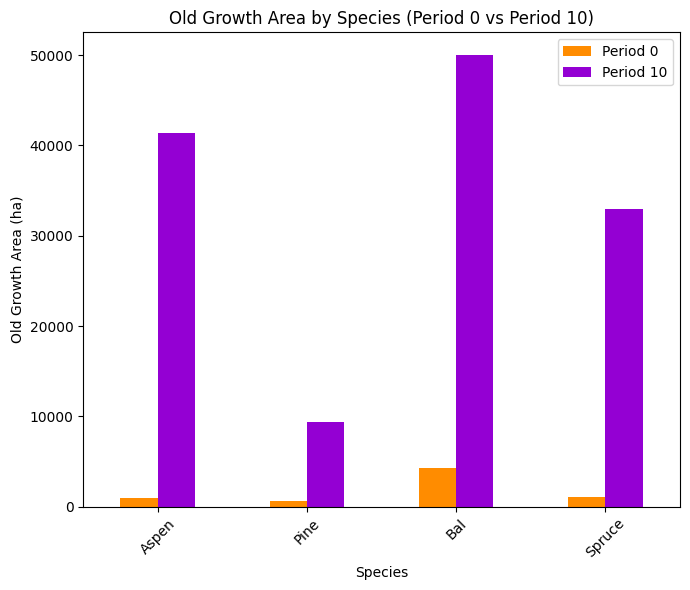

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_ha_redchrs_AAC_40%_old_growth_comparison.pdf

Portion for time period 0:
Aspen: 0.2198
Pine: 0.0581
Bal: 0.4123
Spruce: 0.3099

Portion for time period 10:
Aspen: 0.1112
Pine: 0.0590
Bal: 0.4203
Spruce: 0.4096

Shannon Evennes Index for time period 0: 0.8848
Shannon Evennes Index for time period 10: 0.8231

Diversity has **decreased** by 6.17% from time 0 to time 10.


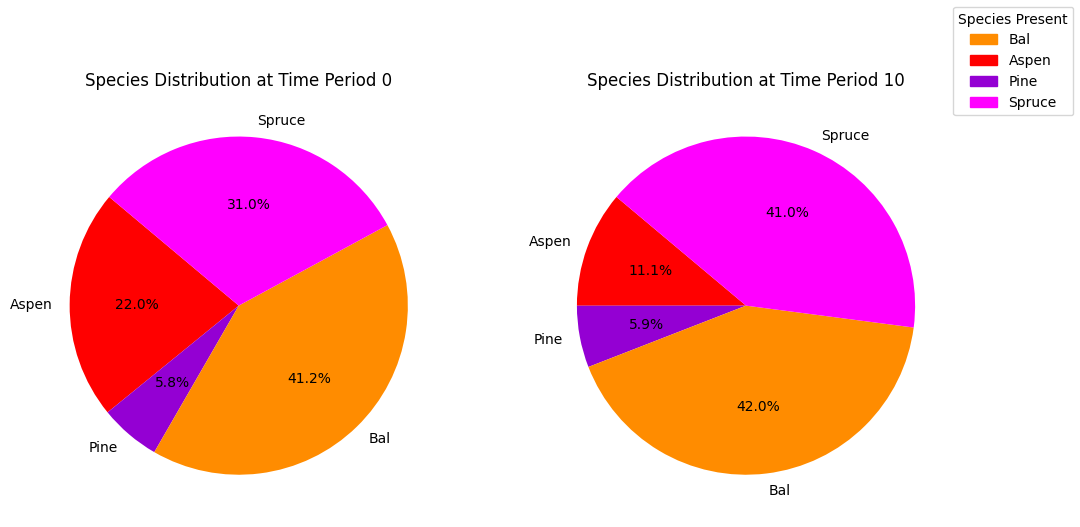

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_ha_redchrs_AAC_40%_species_pie.pdf
running business as usual scenario for the Red Chris mining site,
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x97ce50eb
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-01, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.16s
Presolved: 1699 rows, 30866 columns, 420629 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time:

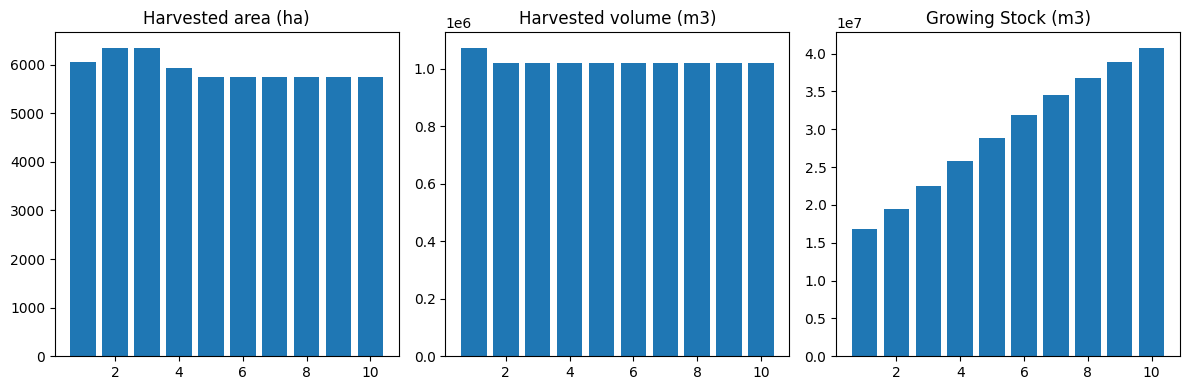

Plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  10831
The economic indicator (the provincial government revenues) is:  369393
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


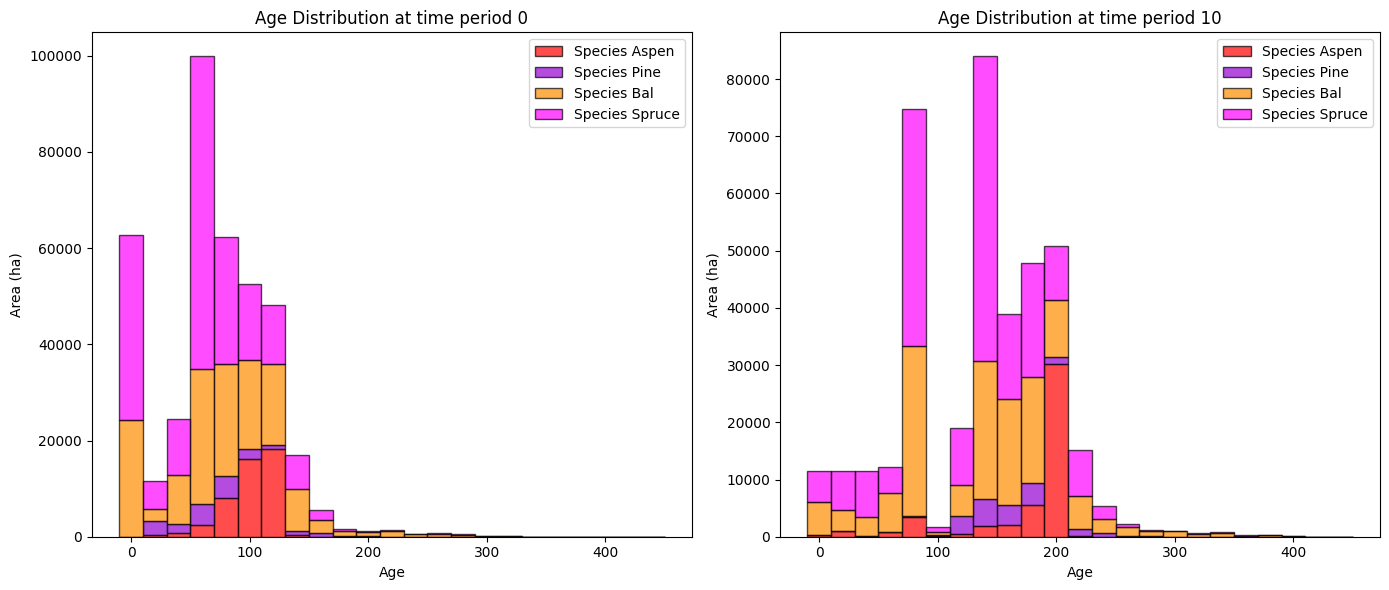

Plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  38766.465357  37821.151669
Pine     602.782616   9274.249263   8671.466647
Bal     4315.588546  35732.277284  31416.688738
Spruce  1072.814408  27525.137232  26452.322824

Overall diversity has **increased** by 104361.63 hectares from time period 0 to time period 10.


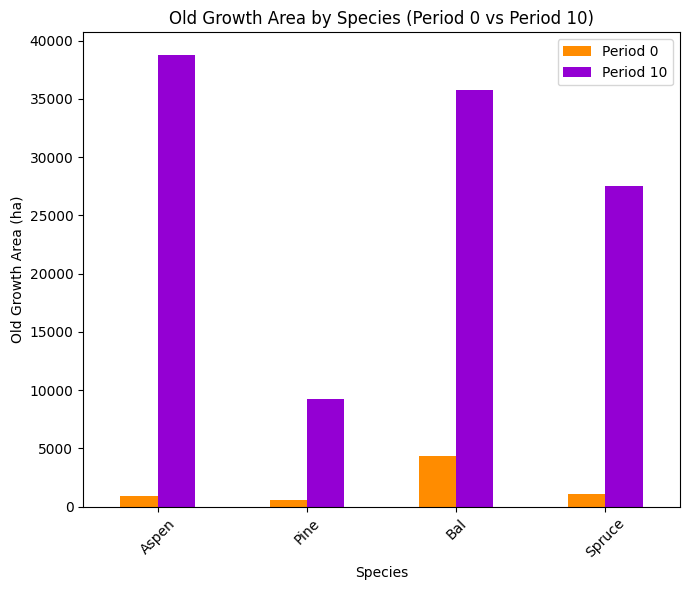

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_old_growth_comparison.pdf

Portion for time period 0:
Aspen: 0.2198
Pine: 0.0581
Bal: 0.4123
Spruce: 0.3099

Portion for time period 10:
Aspen: 0.1252
Pine: 0.0703
Bal: 0.4000
Spruce: 0.4045

Shannon Evennes Index for time period 0: 0.8848
Shannon Evennes Index for time period 10: 0.8507

Diversity has **decreased** by 3.41% from time 0 to time 10.


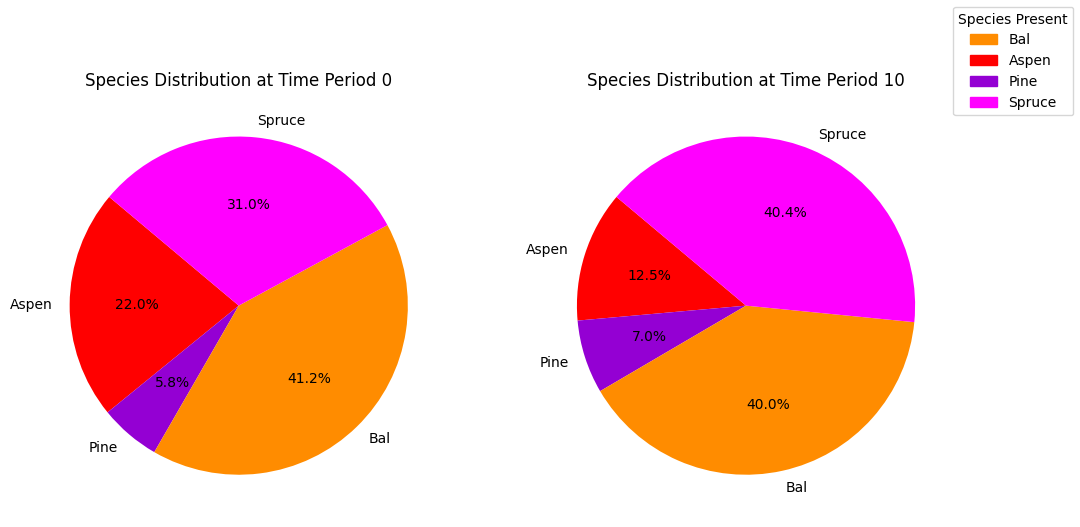

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_species_pie.pdf


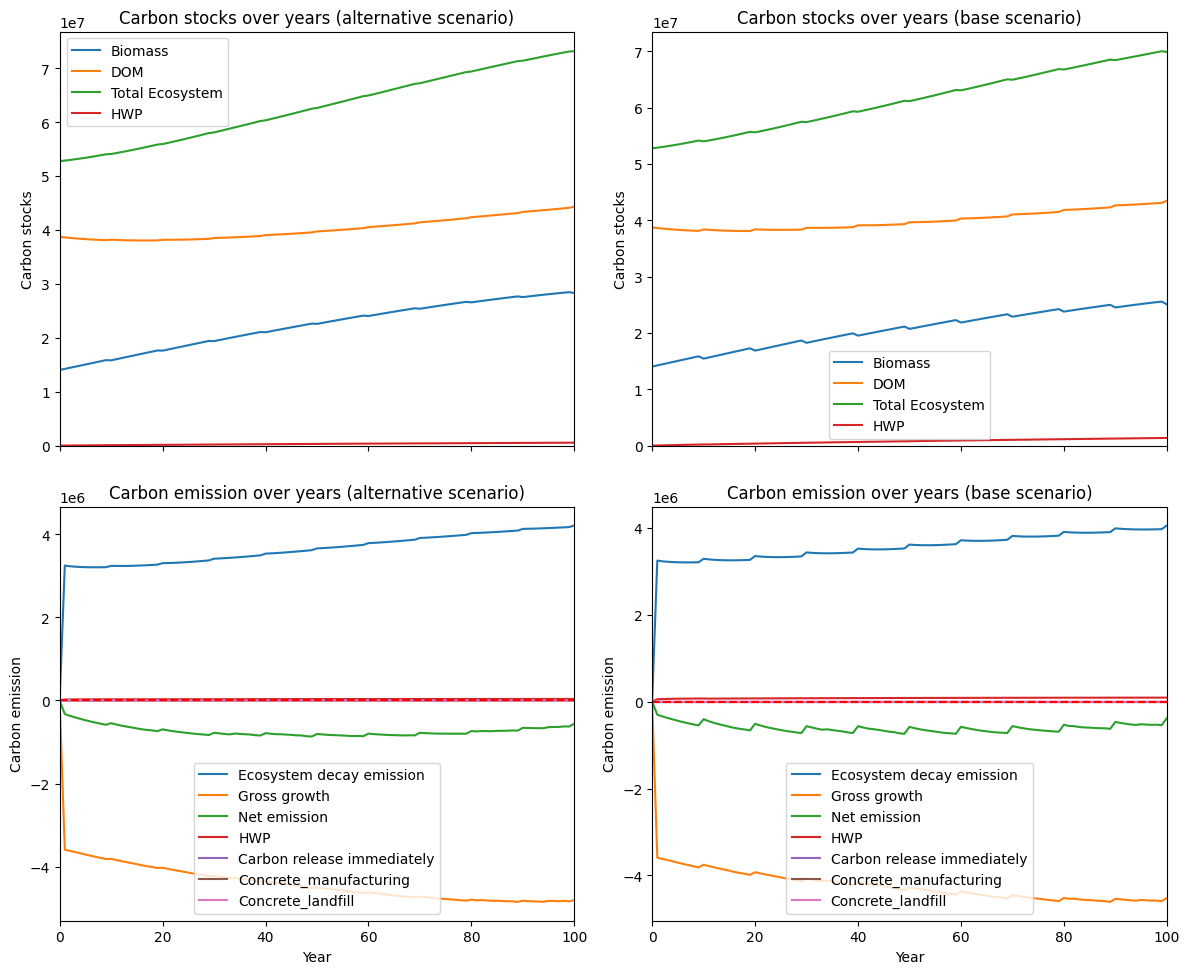

---------------------------------------------------------------------------------------
Net emission difference -2112102.440282755
Net emission base scenario -14418968.397411384
Net emission alternative scenario -12306865.95712863
dollar_per_ton is:  4.734618837266844
Comparison of Old Growth Areas (Alternative - Base)
          0            10    Difference
Aspen   0.0   2651.607830   2651.607830
Pine    0.0    115.737010    115.737010
Bal     0.0  14289.906732  14289.906732
Spruce  0.0   5389.502694   5389.502694

Overall, the old growth area has **increased** by 22446.75 hectares in the alternative scenario compared to the base scenario.


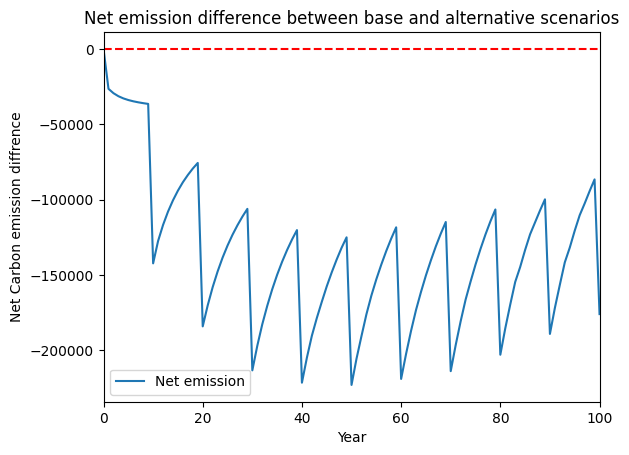

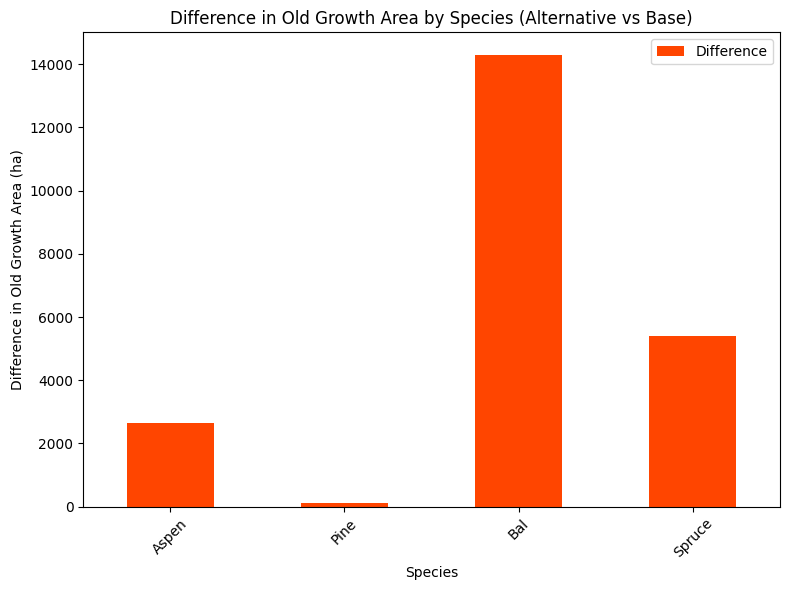

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/redchris/redchris_min_ha_kpi_age_difference.pdf


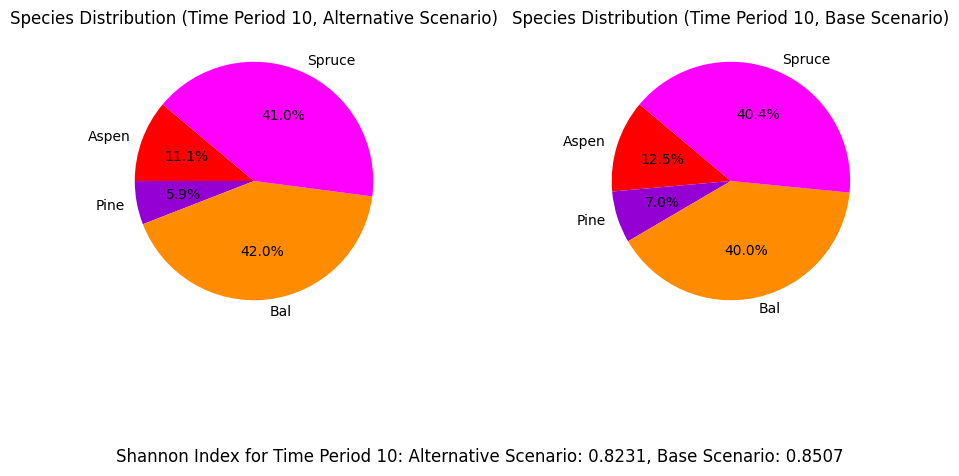

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_ha_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for redchris_min_ha_redchrs_AAC_30%...
running the scenario for the Red Chris mining site (30%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0xbb906287
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-01, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.17s
Presolved: 1699 rows, 30867 column

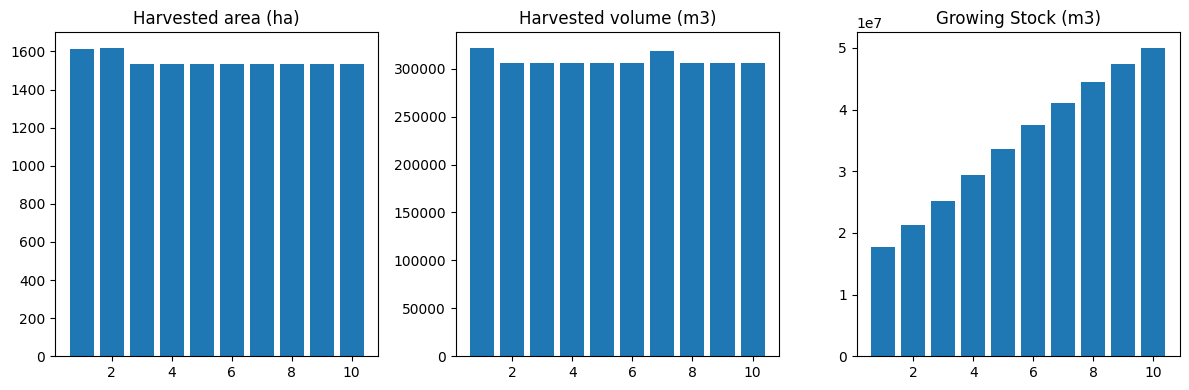

Plot saved to ./outputs/fig/redchris/redchris_min_ha_redchrs_AAC_30%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  3262
The economic indicator (the provincial government revenues) is:  111260
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


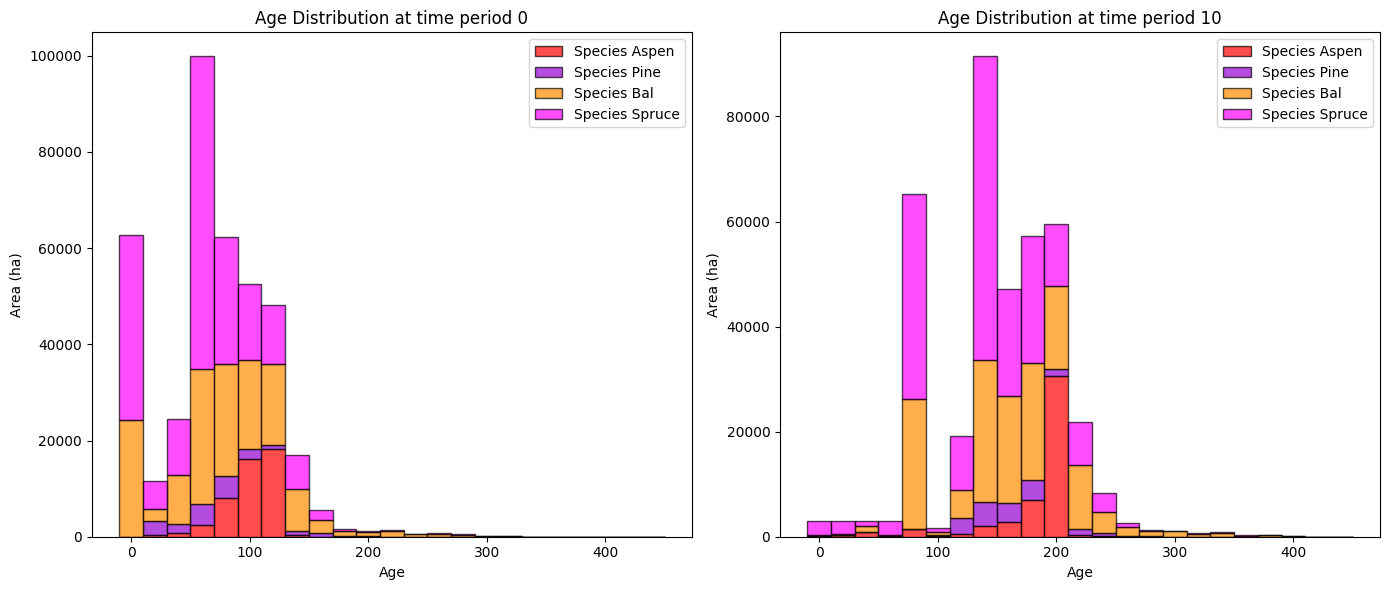

Plot saved to ./outputs/fig/redchris/redchris_min_ha_redchrs_AAC_30%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  41659.331785  40714.018097
Pine     602.782616   9389.986273   8787.203656
Bal     4315.588546  51876.804763  47561.216217
Spruce  1072.814408  35720.524491  34647.710083

Overall diversity has **increased** by 131710.15 hectares from time period 0 to time period 10.


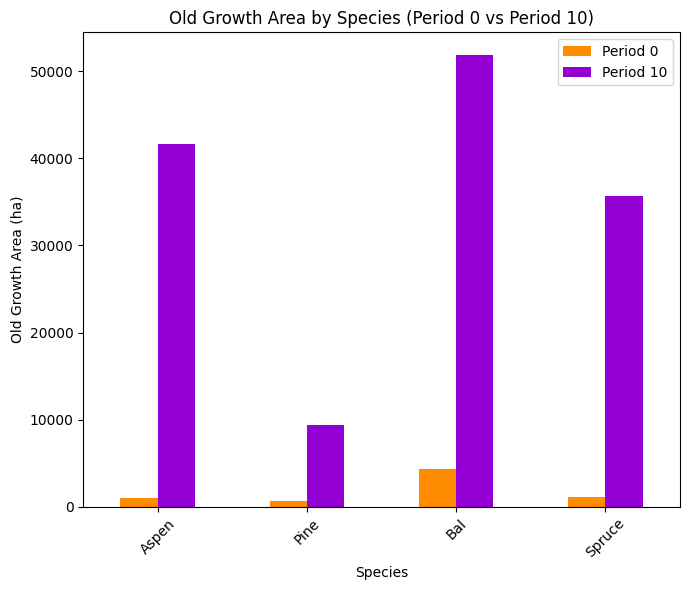

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_ha_redchrs_AAC_30%_old_growth_comparison.pdf

Portion for time period 0:
Aspen: 0.2198
Pine: 0.0581
Bal: 0.4123
Spruce: 0.3099

Portion for time period 10:
Aspen: 0.1079
Pine: 0.0575
Bal: 0.4187
Spruce: 0.4159

Shannon Evennes Index for time period 0: 0.8848
Shannon Evennes Index for time period 10: 0.8179

Diversity has **decreased** by 6.69% from time 0 to time 10.


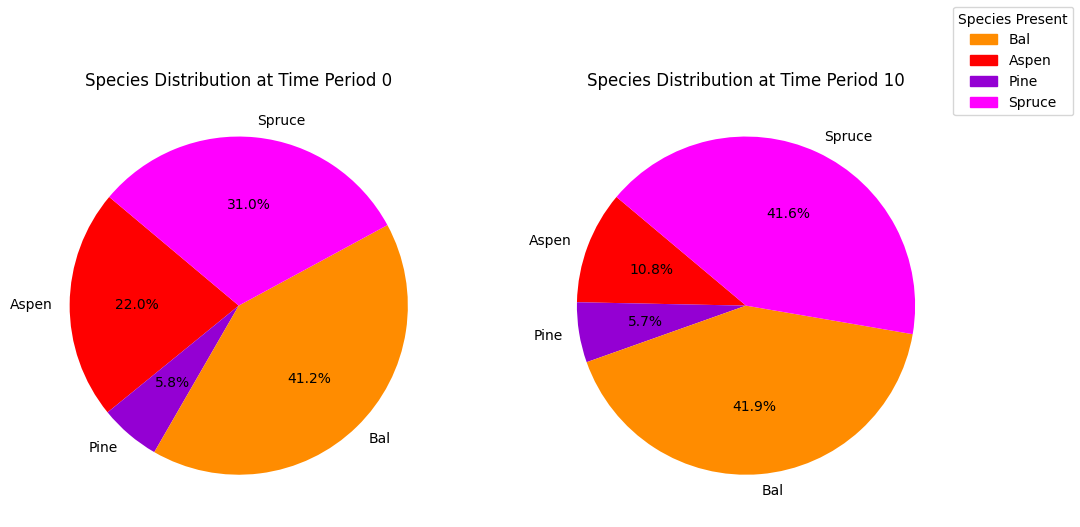

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_ha_redchrs_AAC_30%_species_pie.pdf
running business as usual scenario for the Red Chris mining site,
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x97ce50eb
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-01, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.16s
Presolved: 1699 rows, 30866 columns, 420629 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time:

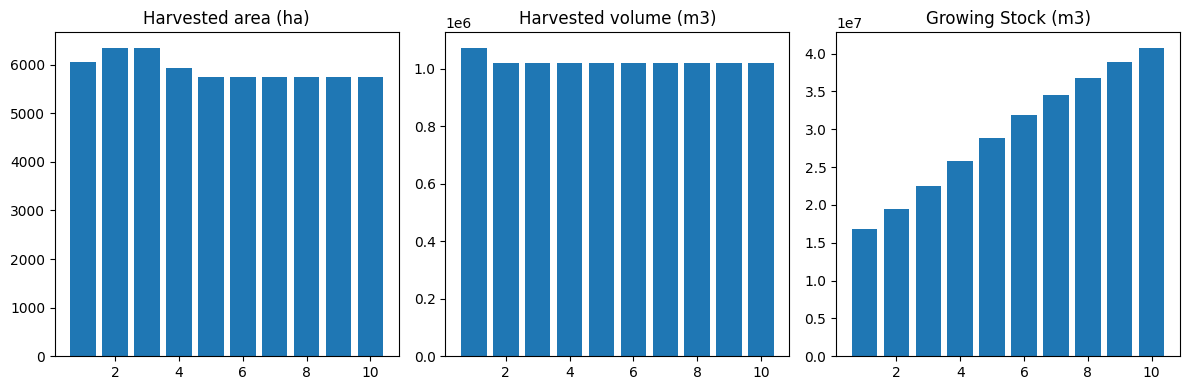

Plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  10831
The economic indicator (the provincial government revenues) is:  369393
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


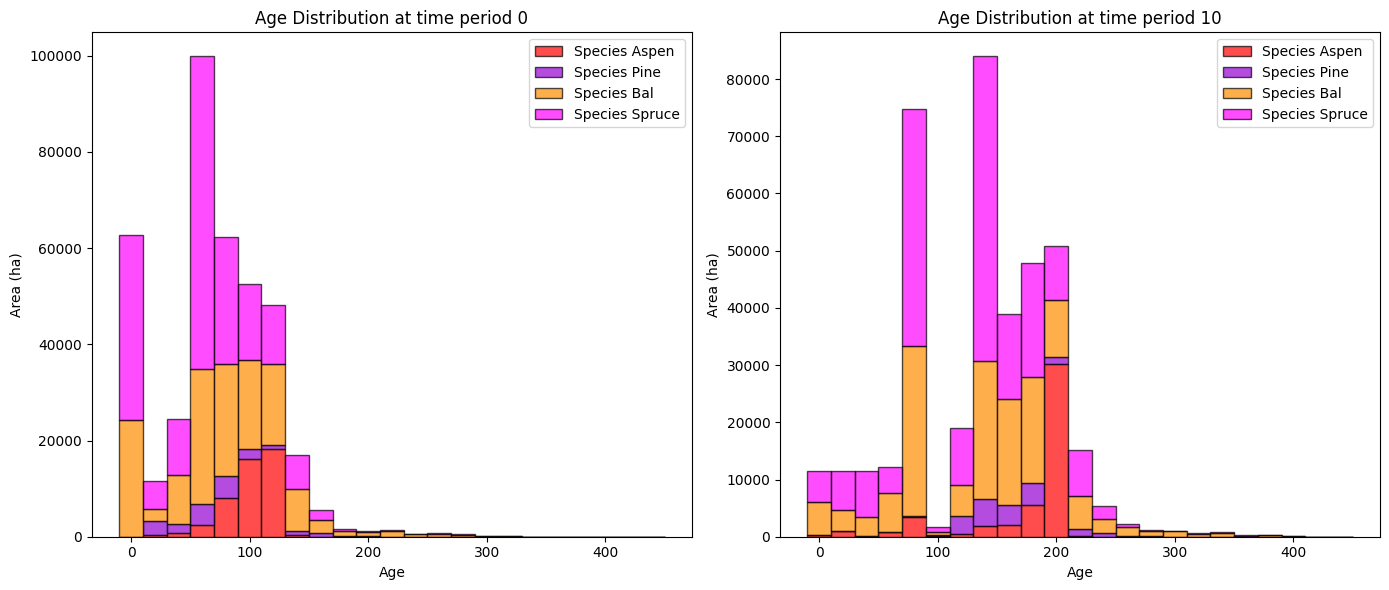

Plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  38766.465357  37821.151669
Pine     602.782616   9274.249263   8671.466647
Bal     4315.588546  35732.277284  31416.688738
Spruce  1072.814408  27525.137232  26452.322824

Overall diversity has **increased** by 104361.63 hectares from time period 0 to time period 10.


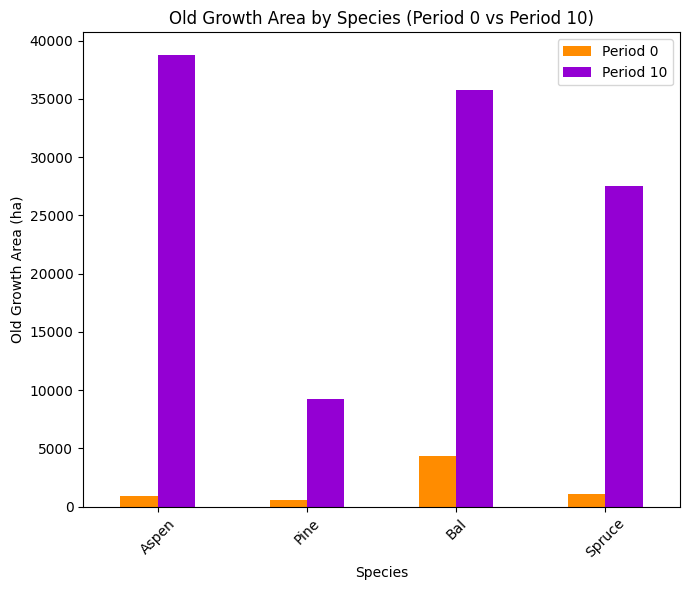

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_old_growth_comparison.pdf

Portion for time period 0:
Aspen: 0.2198
Pine: 0.0581
Bal: 0.4123
Spruce: 0.3099

Portion for time period 10:
Aspen: 0.1252
Pine: 0.0703
Bal: 0.4000
Spruce: 0.4045

Shannon Evennes Index for time period 0: 0.8848
Shannon Evennes Index for time period 10: 0.8507

Diversity has **decreased** by 3.41% from time 0 to time 10.


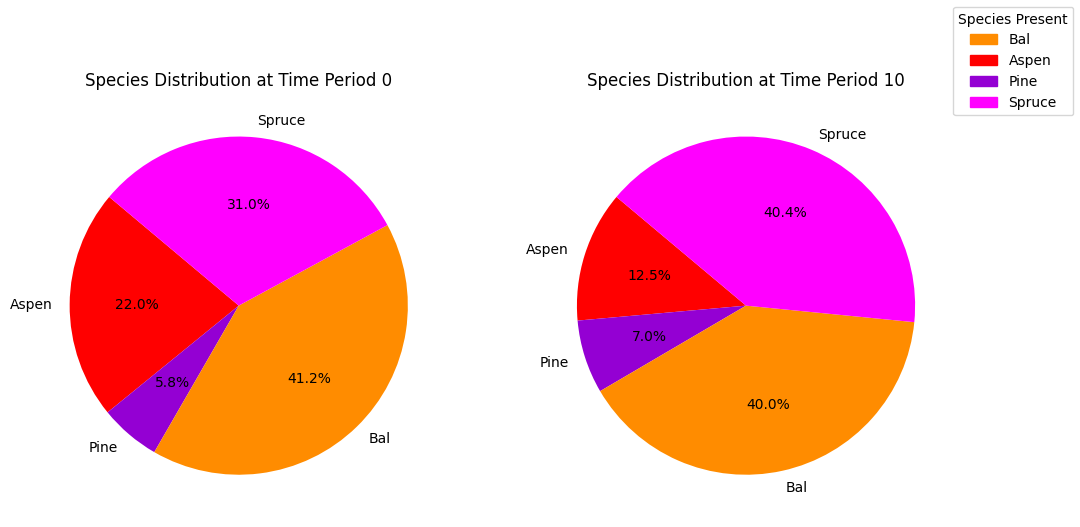

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_species_pie.pdf


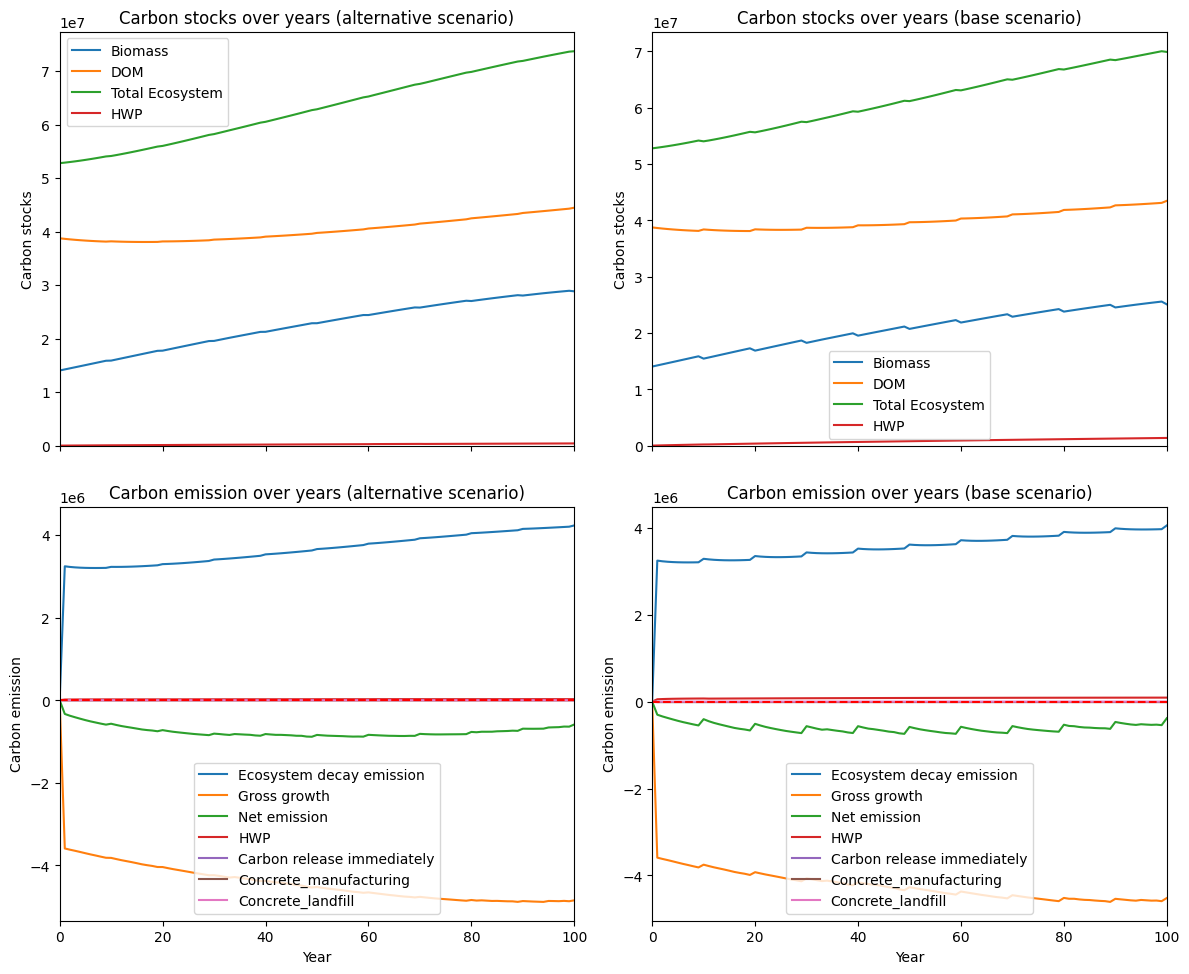

---------------------------------------------------------------------------------------
Net emission difference -2442695.7014319627
Net emission base scenario -14749561.658560593
Net emission alternative scenario -12306865.95712863
dollar_per_ton is:  4.093837801465724
Comparison of Old Growth Areas (Alternative - Base)
          0            10    Difference
Aspen   0.0   2892.866428   2892.866428
Pine    0.0    115.737010    115.737010
Bal     0.0  16144.527479  16144.527479
Spruce  0.0   8195.387259   8195.387259

Overall, the old growth area has **increased** by 27348.52 hectares in the alternative scenario compared to the base scenario.


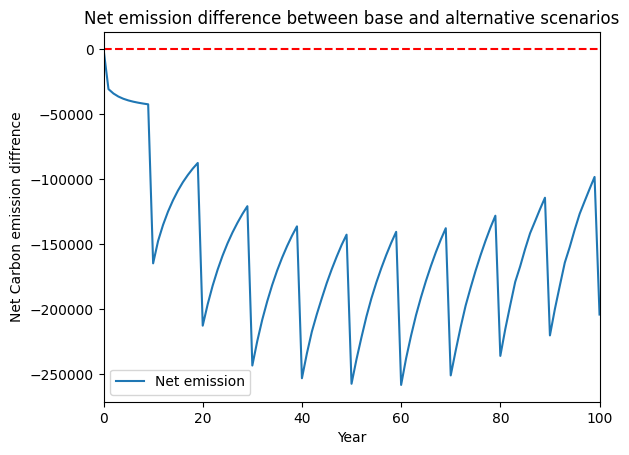

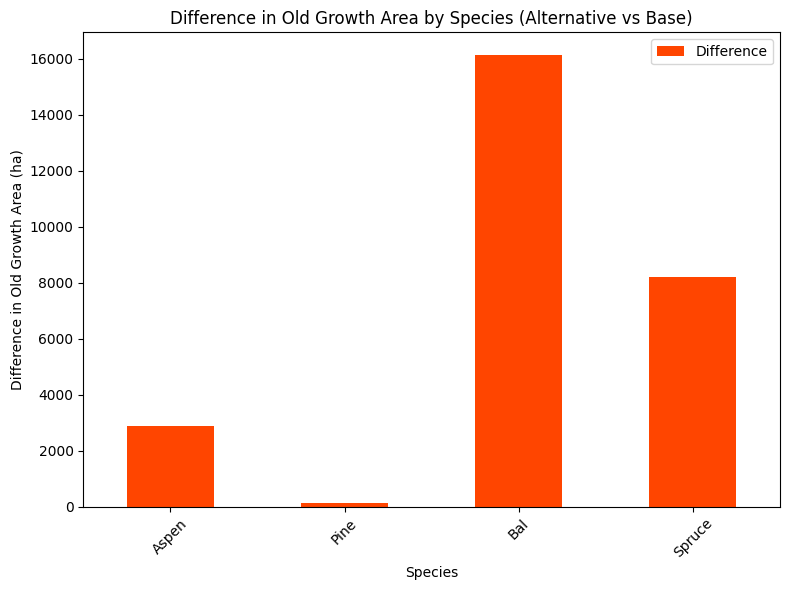

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/redchris/redchris_min_ha_kpi_age_difference.pdf


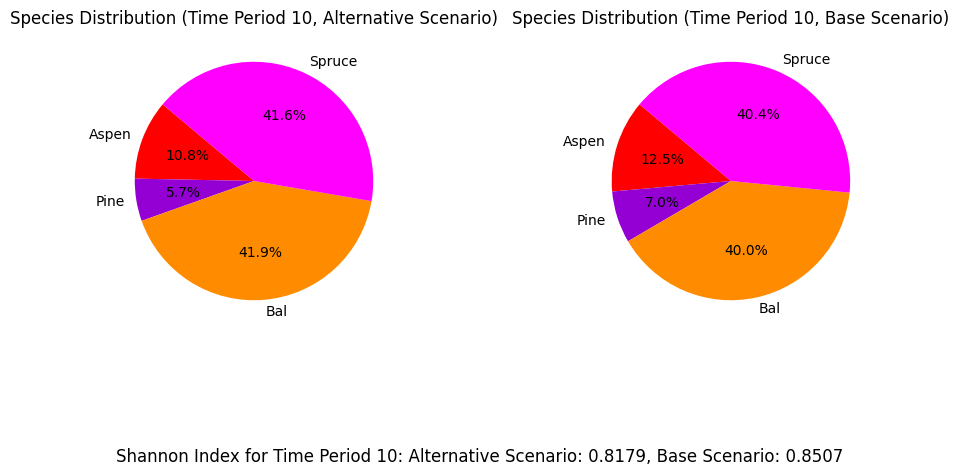

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_ha_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for redchris_min_ha_redchrs_AAC_20%...
running the scenario for the Red Chris mining site (20%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x36e6e419
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-01, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.17s
Presolved: 1699 rows, 30867 column

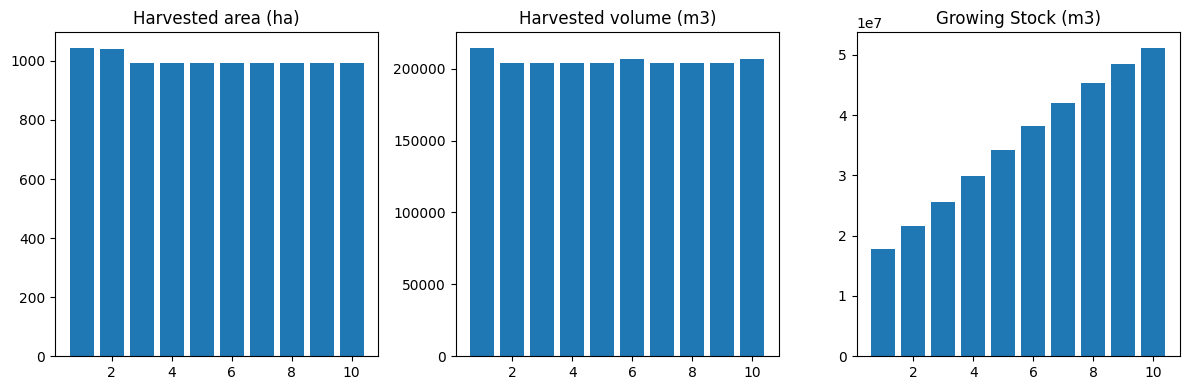

Plot saved to ./outputs/fig/redchris/redchris_min_ha_redchrs_AAC_20%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  2172
The economic indicator (the provincial government revenues) is:  74096
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


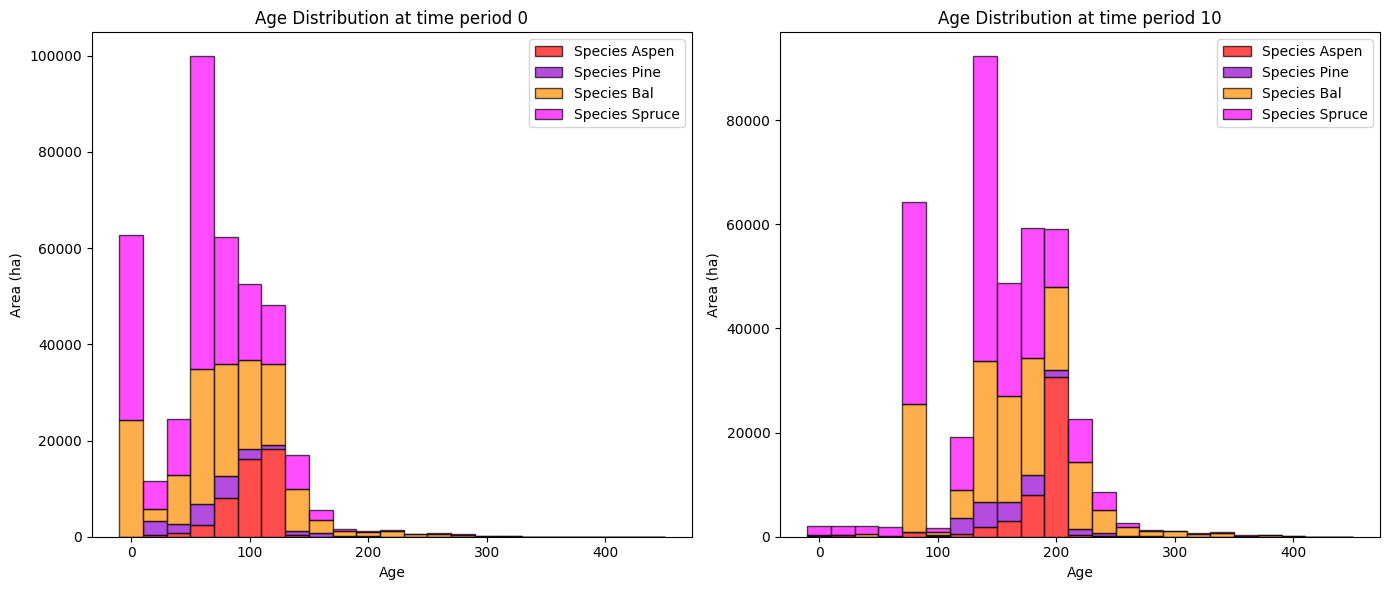

Plot saved to ./outputs/fig/redchris/redchris_min_ha_redchrs_AAC_20%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  43140.625587  42195.311899
Pine     602.782616   9389.986273   8787.203656
Bal     4315.588546  53230.224803  48914.636257
Spruce  1072.814408  36249.913173  35177.098766

Overall diversity has **increased** by 135074.25 hectares from time period 0 to time period 10.


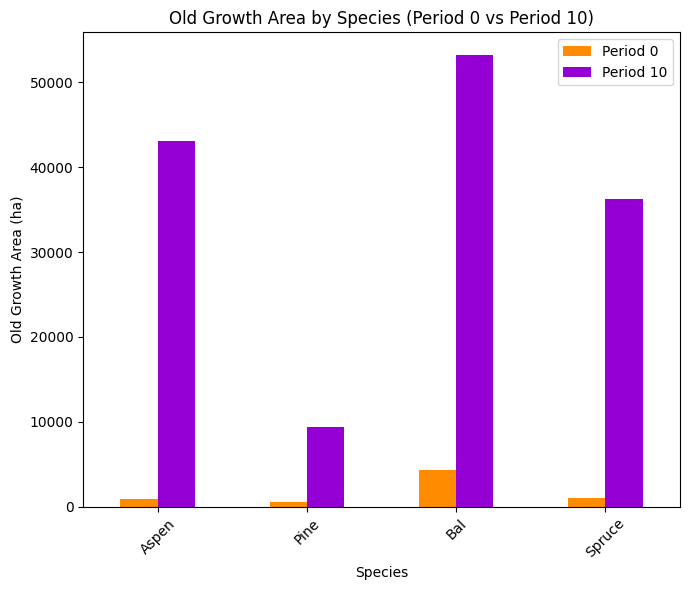

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_ha_redchrs_AAC_20%_old_growth_comparison.pdf

Portion for time period 0:
Aspen: 0.2198
Pine: 0.0581
Bal: 0.4123
Spruce: 0.3099

Portion for time period 10:
Aspen: 0.1097
Pine: 0.0562
Bal: 0.4154
Spruce: 0.4187

Shannon Evennes Index for time period 0: 0.8848
Shannon Evennes Index for time period 10: 0.8178

Diversity has **decreased** by 6.70% from time 0 to time 10.


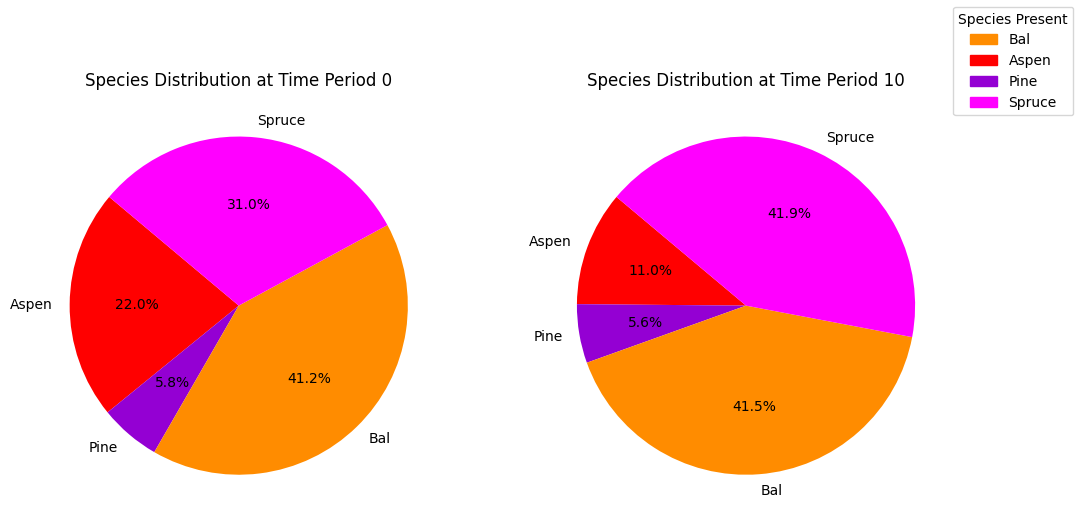

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_ha_redchrs_AAC_20%_species_pie.pdf
running business as usual scenario for the Red Chris mining site,
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x97ce50eb
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-01, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.22s
Presolved: 1699 rows, 30866 columns, 420629 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time:

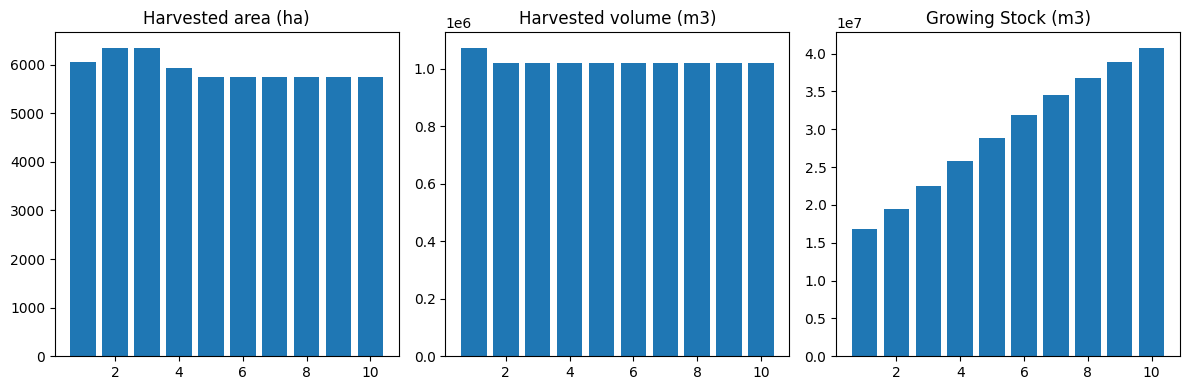

Plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  10831
The economic indicator (the provincial government revenues) is:  369393
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


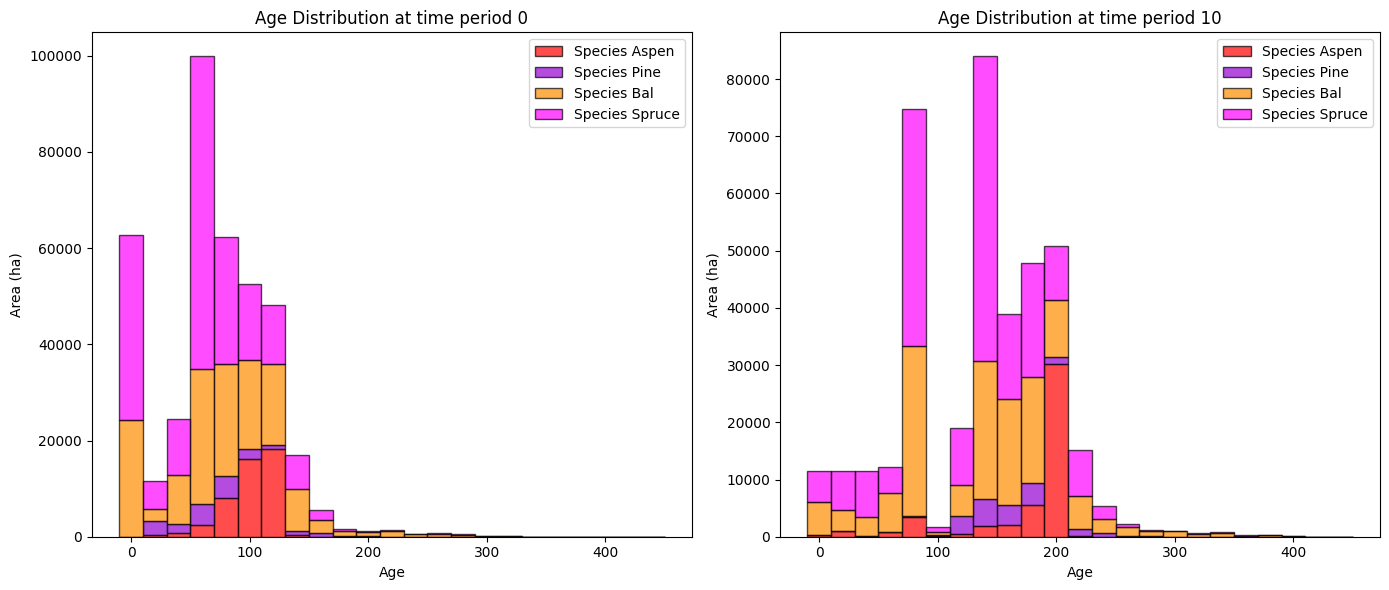

Plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  38766.465357  37821.151669
Pine     602.782616   9274.249263   8671.466647
Bal     4315.588546  35732.277284  31416.688738
Spruce  1072.814408  27525.137232  26452.322824

Overall diversity has **increased** by 104361.63 hectares from time period 0 to time period 10.


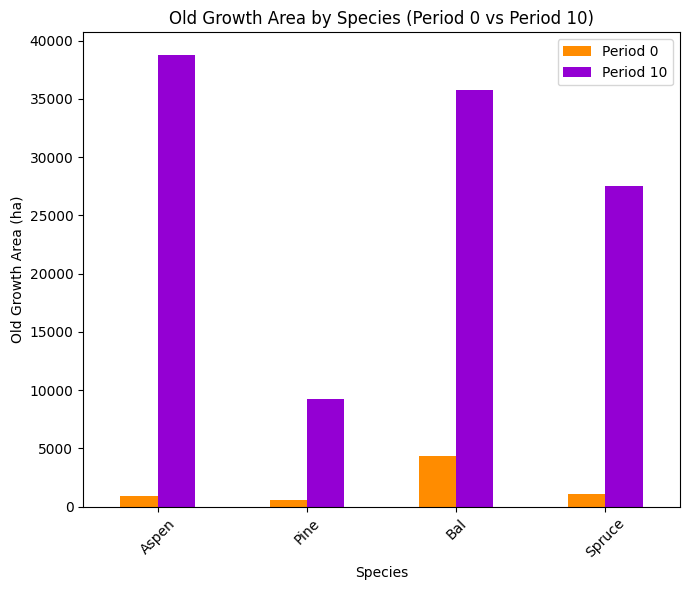

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_old_growth_comparison.pdf

Portion for time period 0:
Aspen: 0.2198
Pine: 0.0581
Bal: 0.4123
Spruce: 0.3099

Portion for time period 10:
Aspen: 0.1252
Pine: 0.0703
Bal: 0.4000
Spruce: 0.4045

Shannon Evennes Index for time period 0: 0.8848
Shannon Evennes Index for time period 10: 0.8507

Diversity has **decreased** by 3.41% from time 0 to time 10.


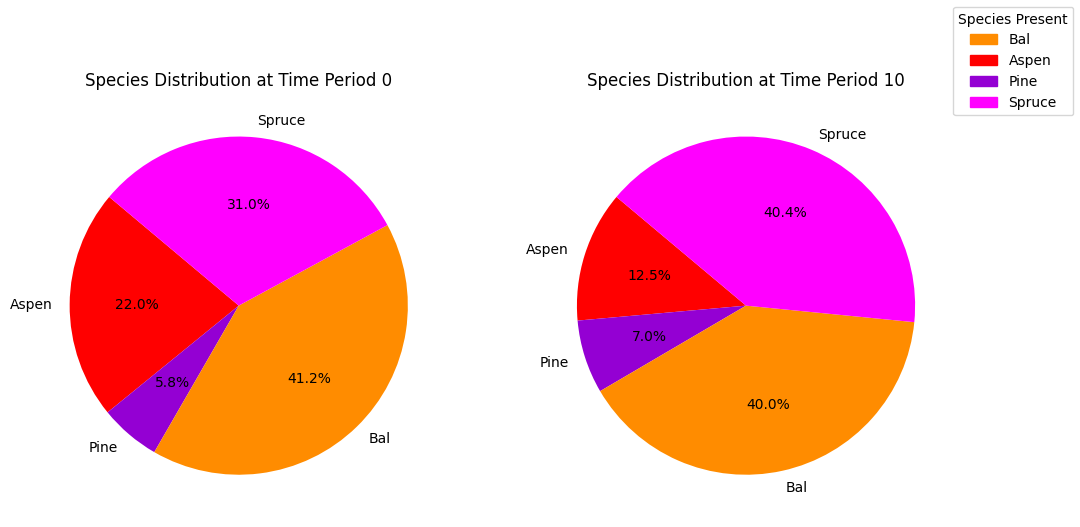

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_species_pie.pdf


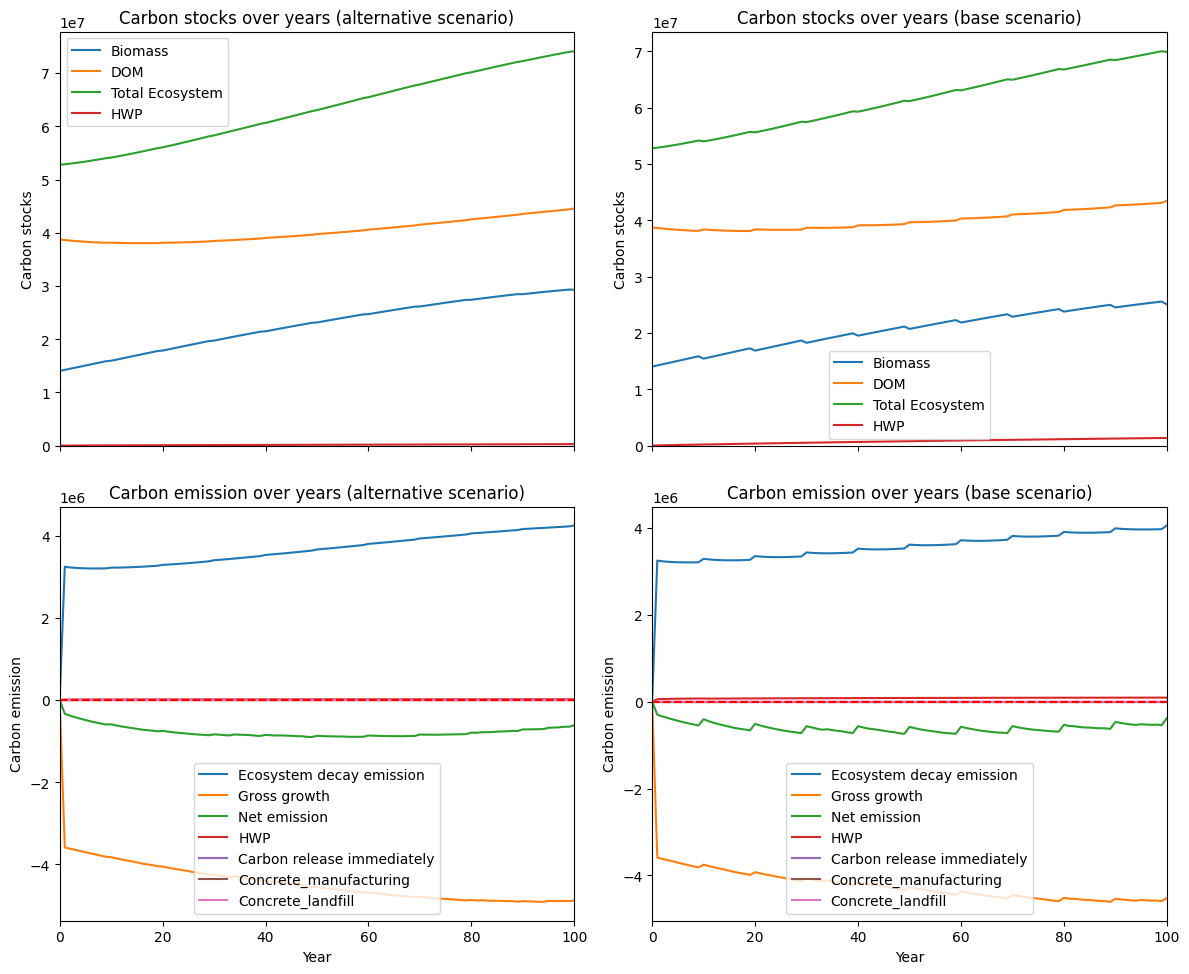

---------------------------------------------------------------------------------------
Net emission difference -2755309.306283684
Net emission base scenario -15062175.263412312
Net emission alternative scenario -12306865.95712863
dollar_per_ton is:  3.6293565942648507
Comparison of Old Growth Areas (Alternative - Base)
          0            10    Difference
Aspen   0.0   4374.160230   4374.160230
Pine    0.0    115.737010    115.737010
Bal     0.0  17497.947519  17497.947519
Spruce  0.0   8724.775941   8724.775941

Overall, the old growth area has **increased** by 30712.62 hectares in the alternative scenario compared to the base scenario.


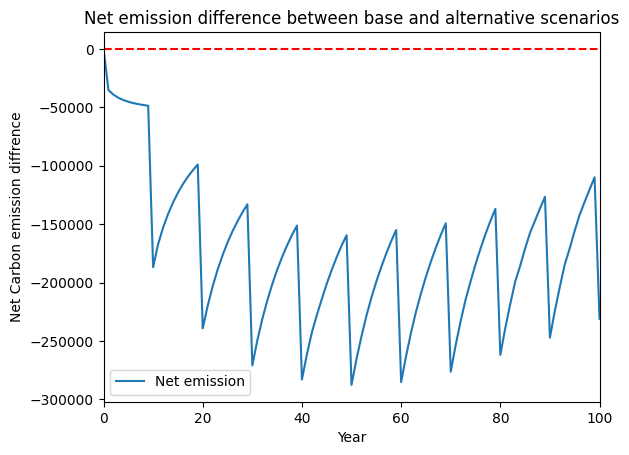

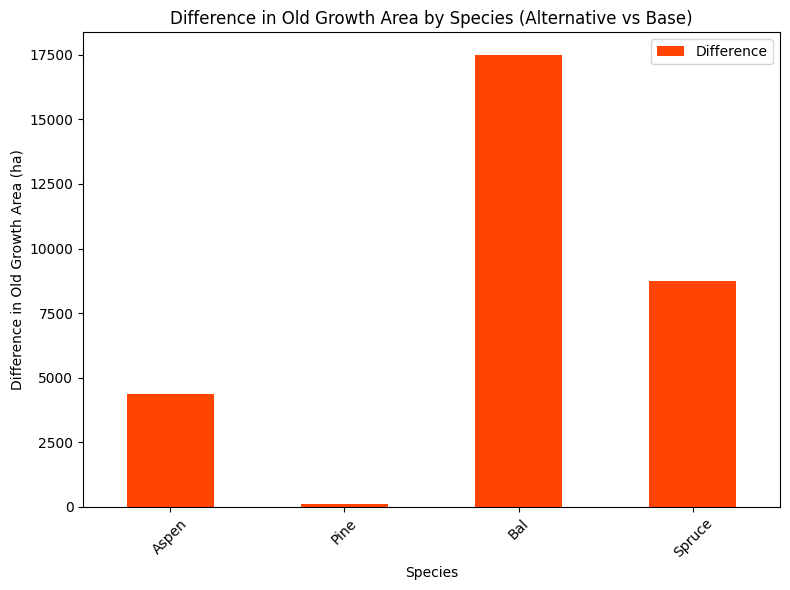

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/redchris/redchris_min_ha_kpi_age_difference.pdf


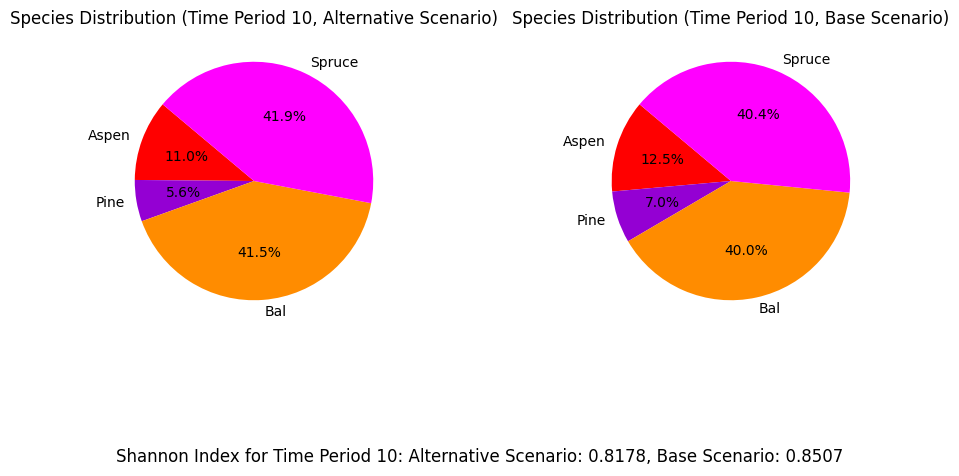

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_ha_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for redchris_min_ha_redchrs_AAC_10%...
running the scenario for the Red Chris mining site (10%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0xab5f201c
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-01, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.22s
Presolved: 1699 rows, 30867 column

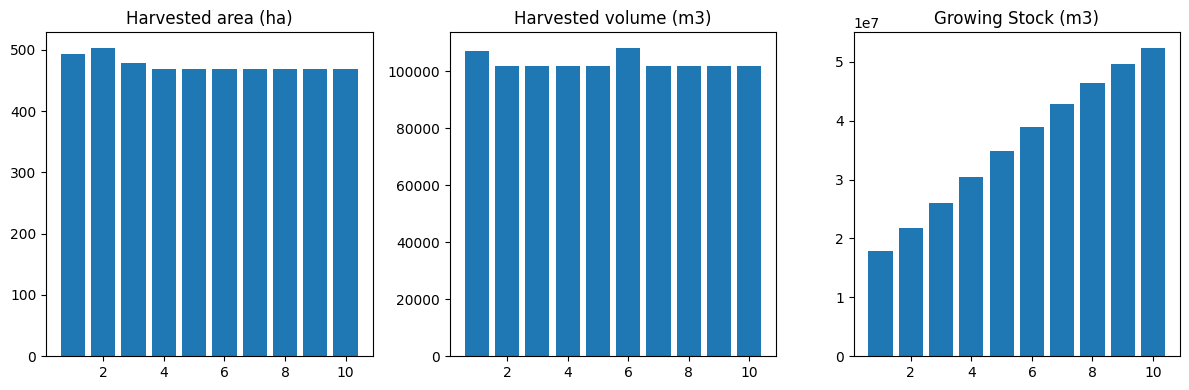

Plot saved to ./outputs/fig/redchris/redchris_min_ha_redchrs_AAC_10%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  1089
The economic indicator (the provincial government revenues) is:  37169
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


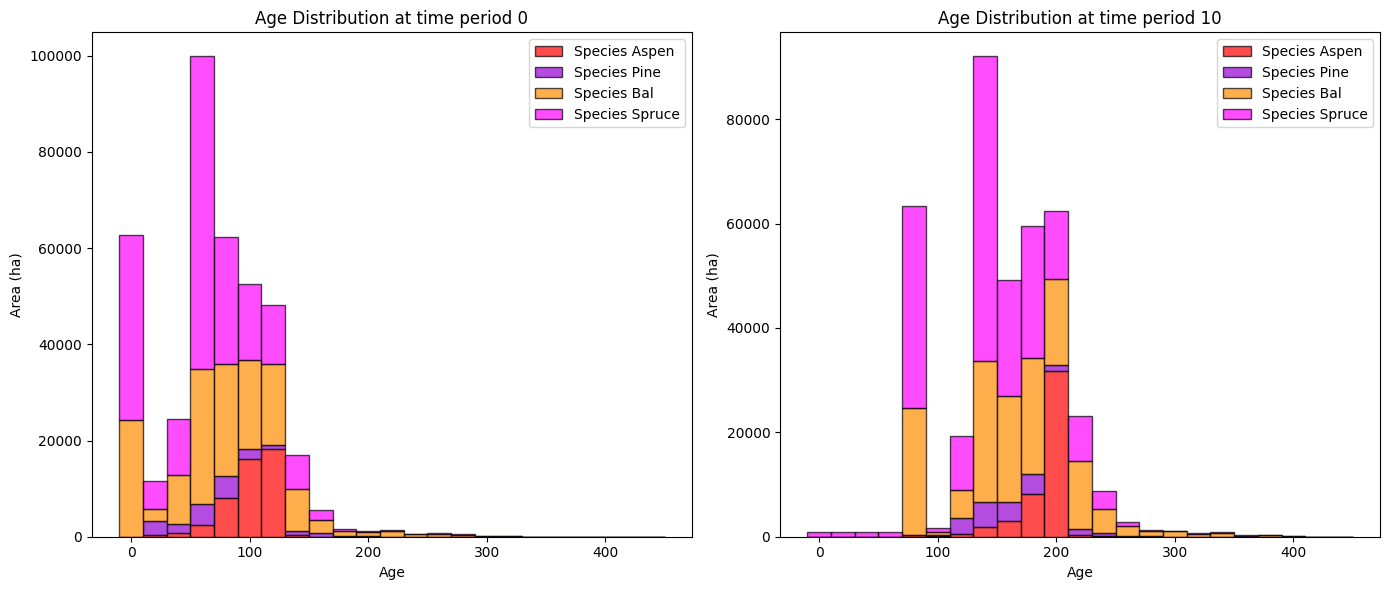

Plot saved to ./outputs/fig/redchris/redchris_min_ha_redchrs_AAC_10%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  44108.689219  43163.375531
Pine     602.782616   9389.986273   8787.203656
Bal     4315.588546  54152.053987  49836.465441
Spruce  1072.814408  39037.960356  37965.145948

Overall diversity has **increased** by 139752.19 hectares from time period 0 to time period 10.


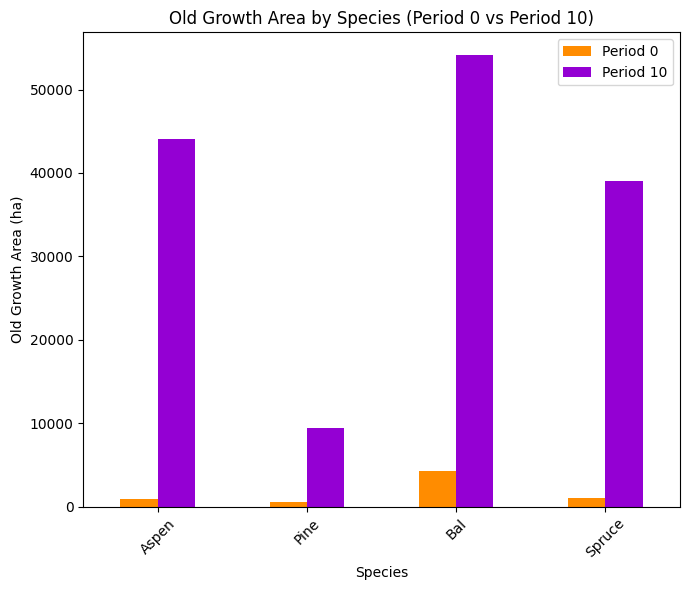

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_ha_redchrs_AAC_10%_old_growth_comparison.pdf

Portion for time period 0:
Aspen: 0.2198
Pine: 0.0581
Bal: 0.4123
Spruce: 0.3099

Portion for time period 10:
Aspen: 0.1098
Pine: 0.0549
Bal: 0.4099
Spruce: 0.4254

Shannon Evennes Index for time period 0: 0.8848
Shannon Evennes Index for time period 10: 0.8159

Diversity has **decreased** by 6.89% from time 0 to time 10.


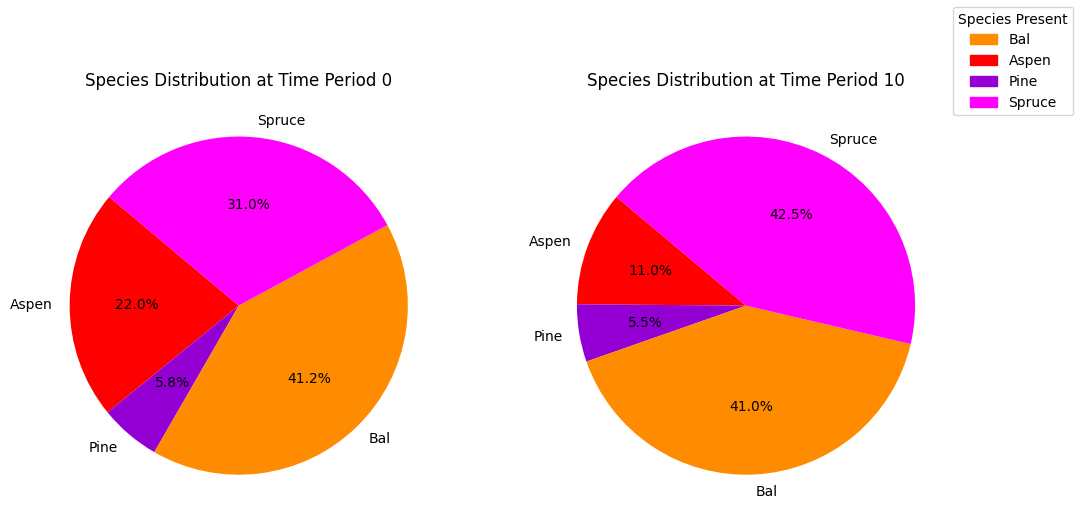

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_ha_redchrs_AAC_10%_species_pie.pdf
running business as usual scenario for the Red Chris mining site,
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x97ce50eb
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-01, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.19s
Presolved: 1699 rows, 30866 columns, 420629 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time:

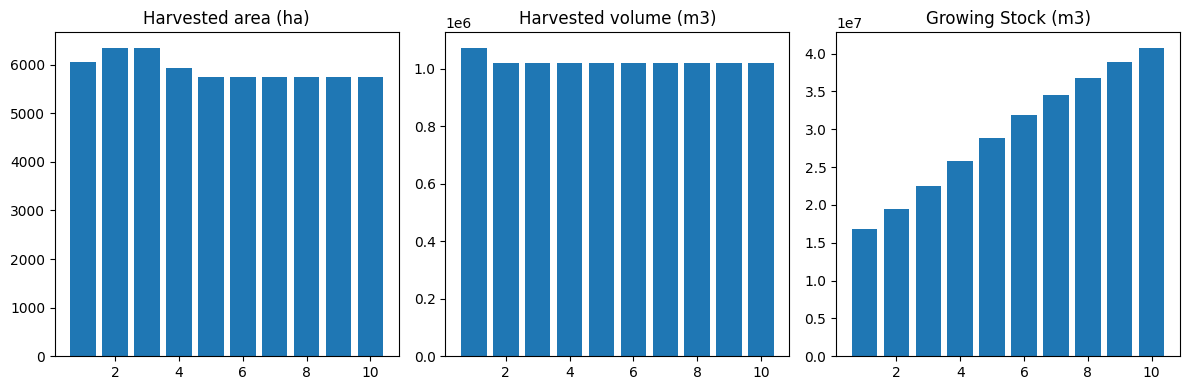

Plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  10831
The economic indicator (the provincial government revenues) is:  369393
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


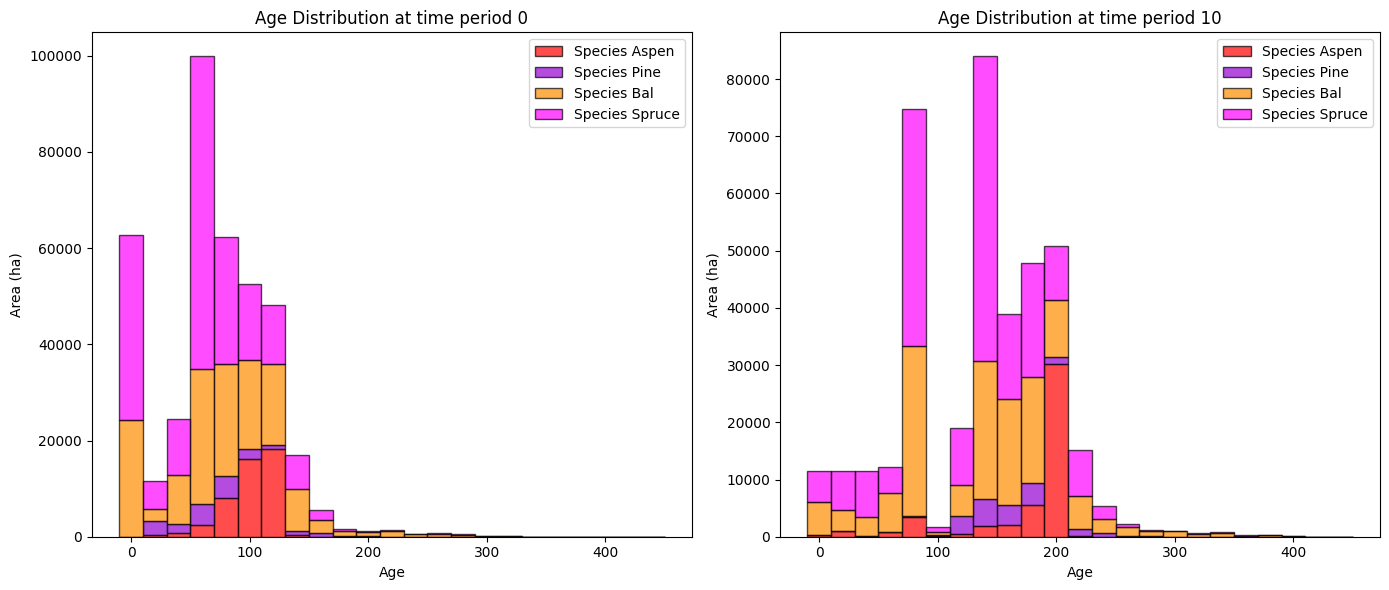

Plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  38766.465357  37821.151669
Pine     602.782616   9274.249263   8671.466647
Bal     4315.588546  35732.277284  31416.688738
Spruce  1072.814408  27525.137232  26452.322824

Overall diversity has **increased** by 104361.63 hectares from time period 0 to time period 10.


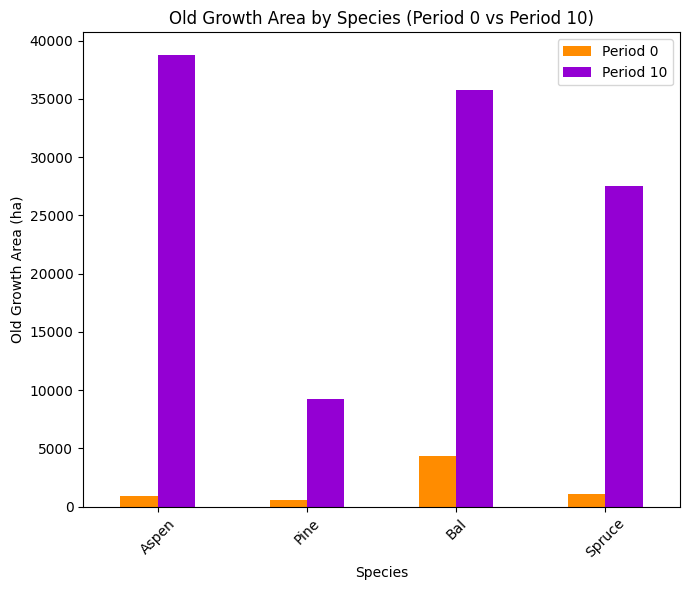

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_old_growth_comparison.pdf

Portion for time period 0:
Aspen: 0.2198
Pine: 0.0581
Bal: 0.4123
Spruce: 0.3099

Portion for time period 10:
Aspen: 0.1252
Pine: 0.0703
Bal: 0.4000
Spruce: 0.4045

Shannon Evennes Index for time period 0: 0.8848
Shannon Evennes Index for time period 10: 0.8507

Diversity has **decreased** by 3.41% from time 0 to time 10.


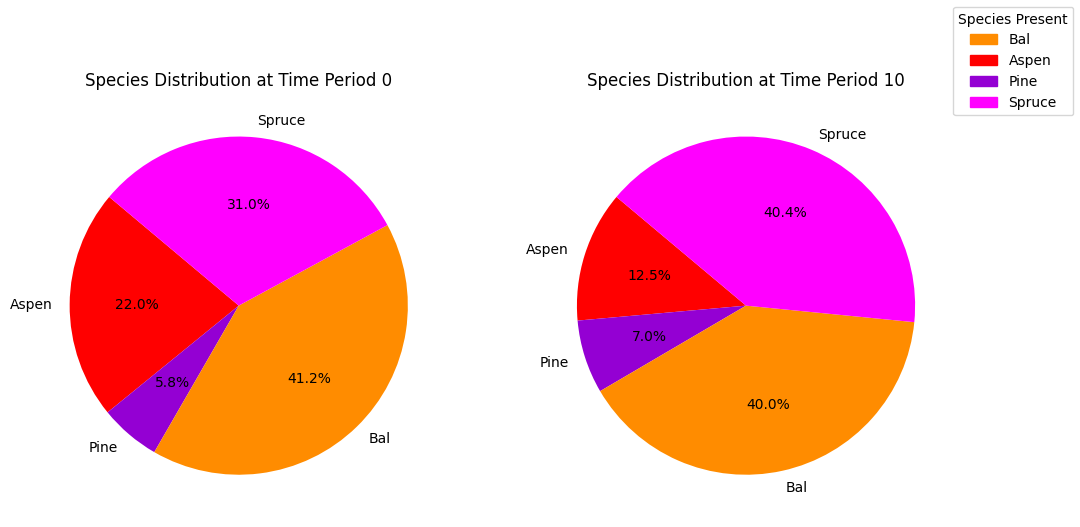

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_species_pie.pdf


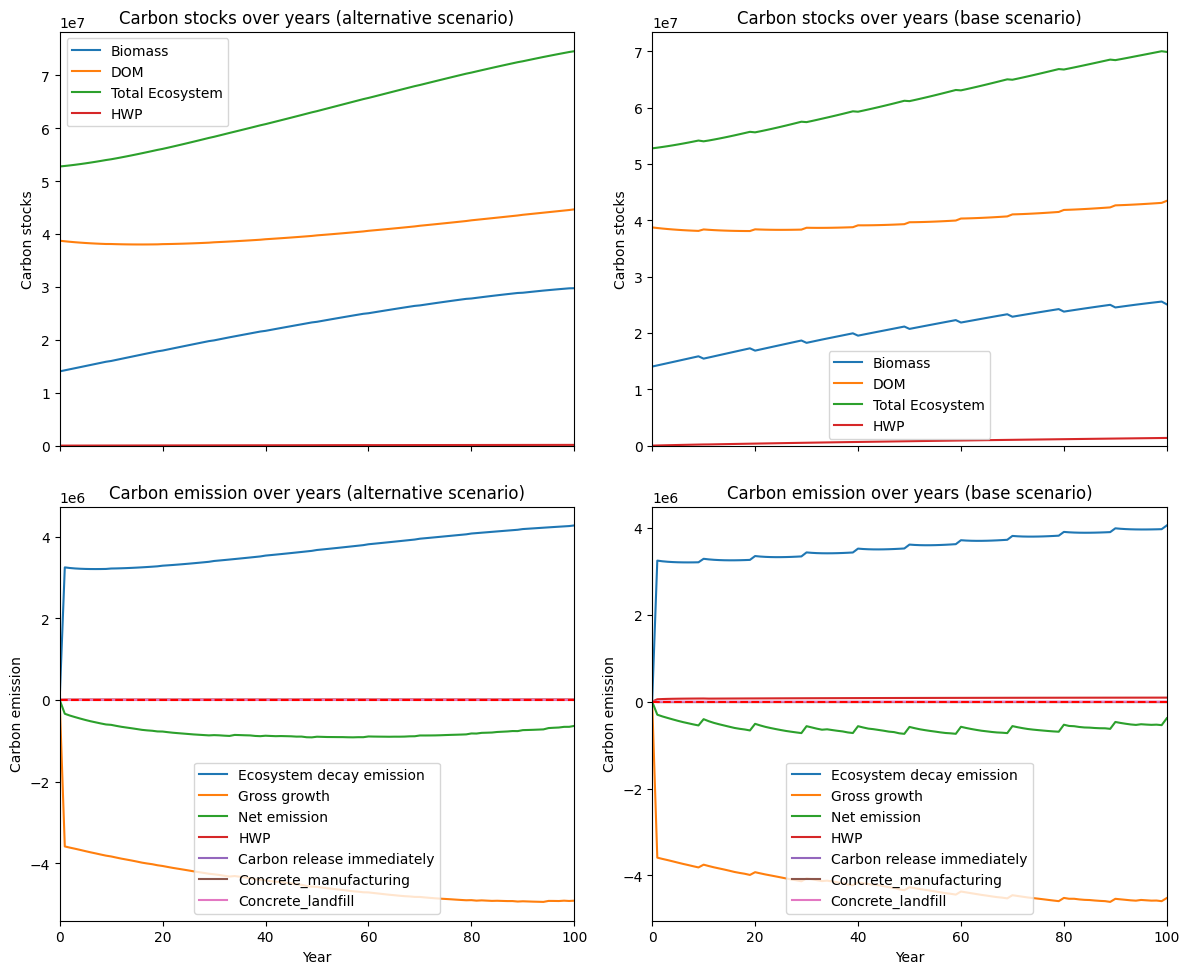

---------------------------------------------------------------------------------------
Net emission difference -3063320.678171819
Net emission base scenario -15370186.635300448
Net emission alternative scenario -12306865.95712863
dollar_per_ton is:  3.2644313314164584
Comparison of Old Growth Areas (Alternative - Base)
          0            10    Difference
Aspen   0.0   5342.223862   5342.223862
Pine    0.0    115.737010    115.737010
Bal     0.0  18419.776703  18419.776703
Spruce  0.0  11512.823124  11512.823124

Overall, the old growth area has **increased** by 35390.56 hectares in the alternative scenario compared to the base scenario.


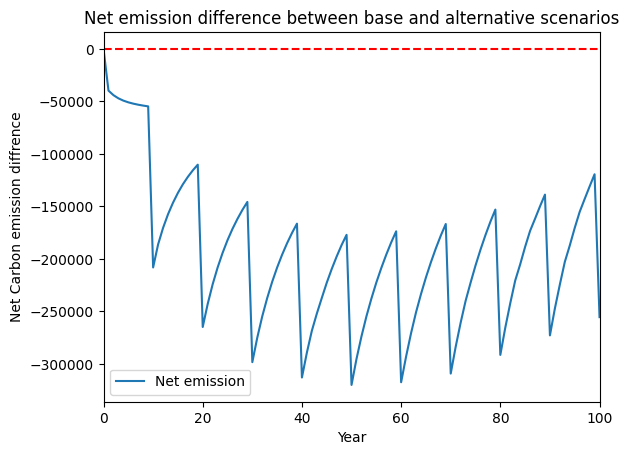

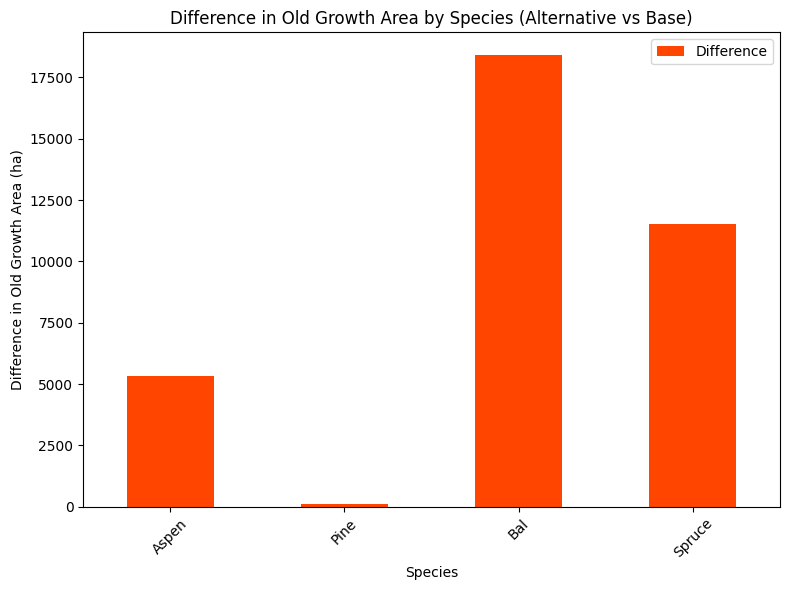

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/redchris/redchris_min_ha_kpi_age_difference.pdf


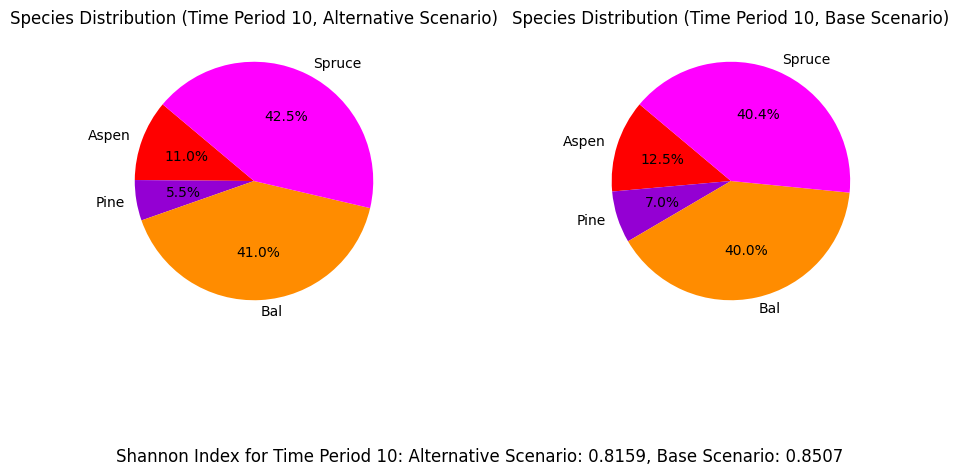

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_ha_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
It took 66.8 minutes to run all scenarios.


In [12]:
Start = time.time()
scenario_names = scenario_options.get(case_study, [])
for scenario_name in scenario_names:
    print(f"Running for {case_study}_{obj_mode}_{scenario_name}...")
    results_scenarios(fm, 
                      clt_percentage, 
                      credibility, 
                      budget_input, 
                      n_steps, 
                      max_harvest, 
                      scenario_name, 
                      displacement_effect, 
                      hwp_pool_effect_value, 
                      release_immediately_value, 
                      case_study, 
                      obj_mode,                   
                      pickle_output_base=True, 
                      pickle_output_alter=False)
print('It took', round((time.time() - Start) / 60, 1), "minutes to run all scenarios.")

Running for redchris_min_ha_redchrs_AAC_40%...
running the scenario for the Red Chris mining site (40%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x018e1aa3
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-01, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.16s
Presolved: 1699 rows, 30867 columns, 420630 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.066e+04
 Factor NZ  : 8.155e+0

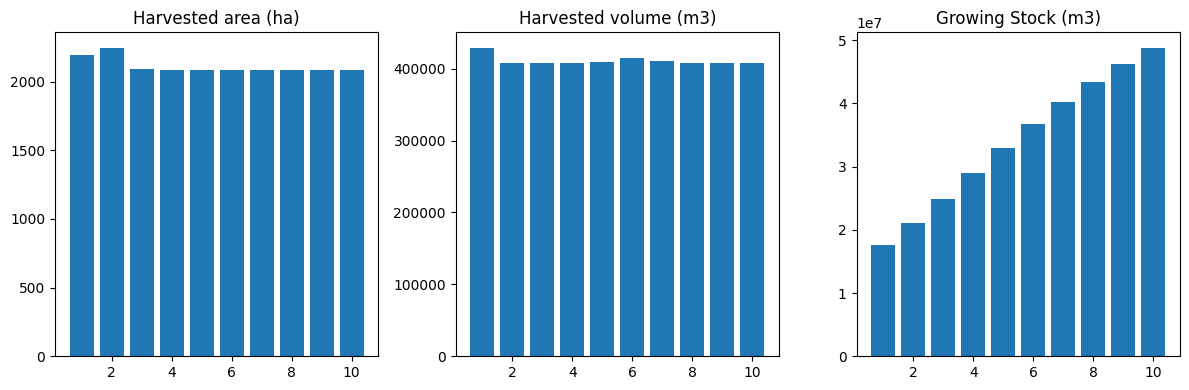

Plot saved to ./outputs/fig/redchris/redchris_min_ha_redchrs_AAC_40%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  4345
The economic indicator (the provincial government revenues) is:  148189
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


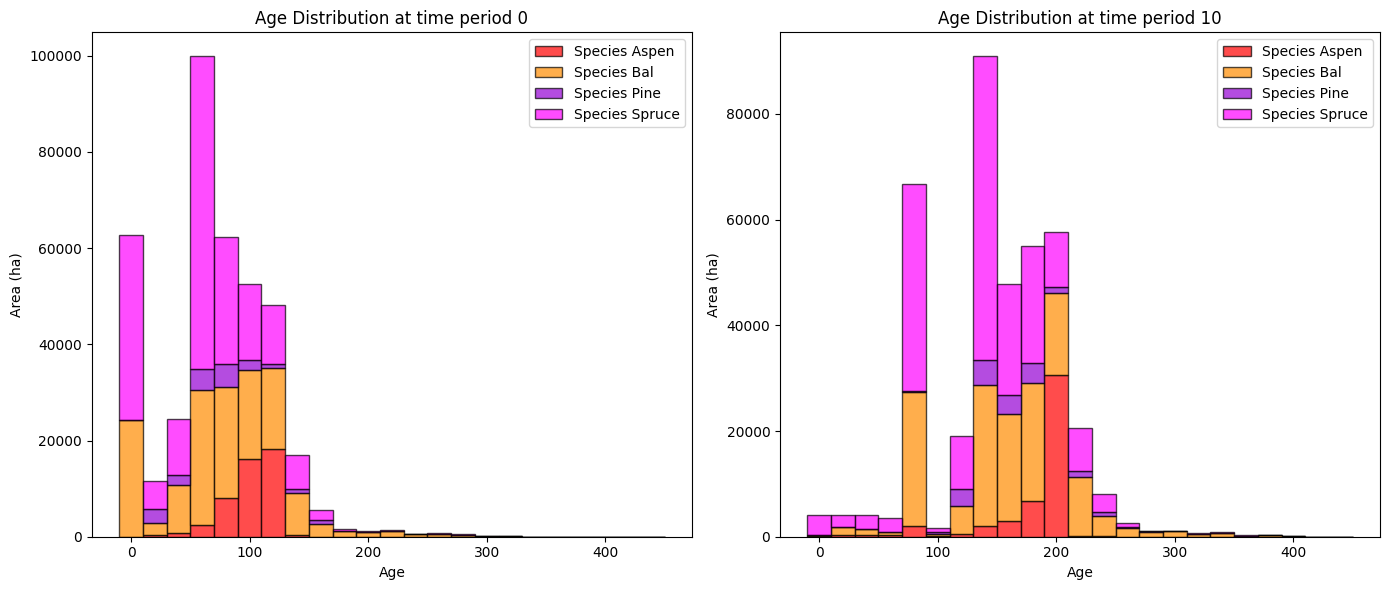

Plot saved to ./outputs/fig/redchris/redchris_min_ha_redchrs_AAC_40%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  41418.073187  40472.759499
Pine     602.782616   9389.986273   8787.203656
Bal     4315.588546  50022.184016  45706.595470
Spruce  1072.814408  32914.639926  31841.825519

Old growth has **increased** by 126808.38 hectares from time period 0 to time period 10.


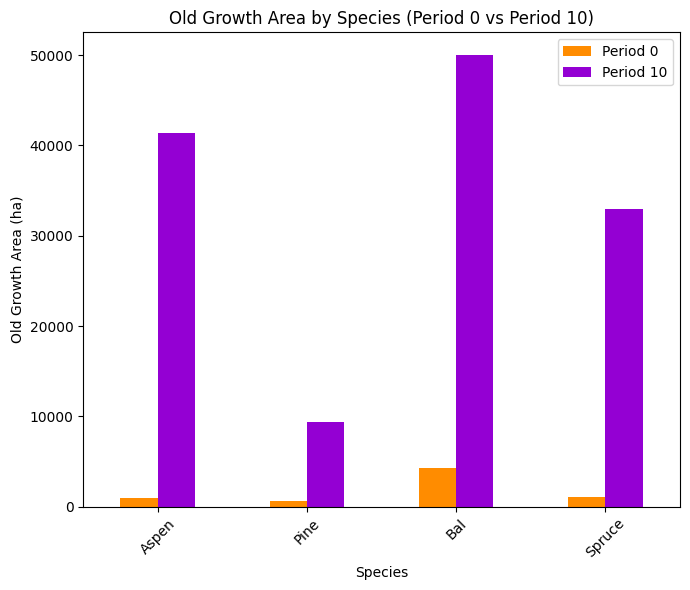

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_ha_redchrs_AAC_40%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.8231

Diversity has **decreased** by 6.17% from time 0 to time 10.


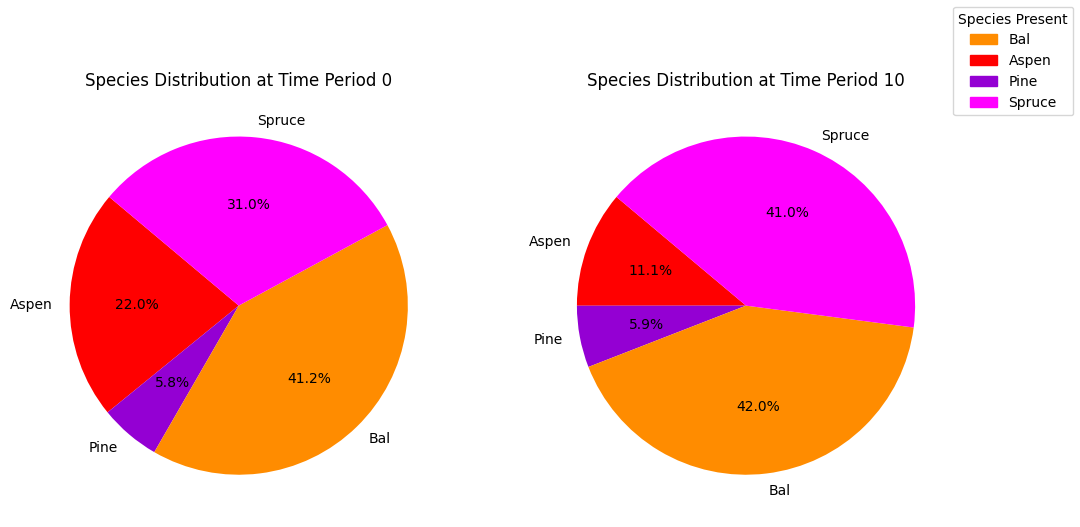

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_ha_redchrs_AAC_40%_species_pie.pdf
running business as usual scenario for the Red Chris mining site,
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x97ce50eb
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-01, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.16s
Presolved: 1699 rows, 30866 columns, 420629 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time:

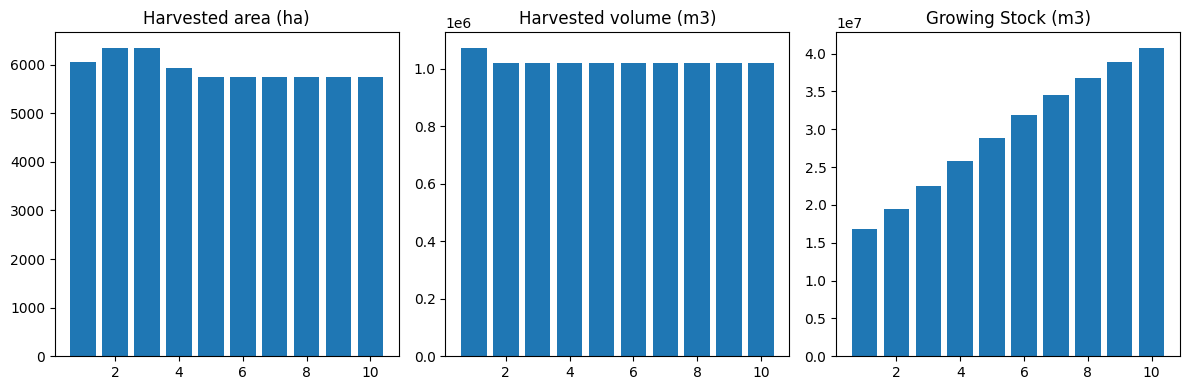

Plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  10831
The economic indicator (the provincial government revenues) is:  369393
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


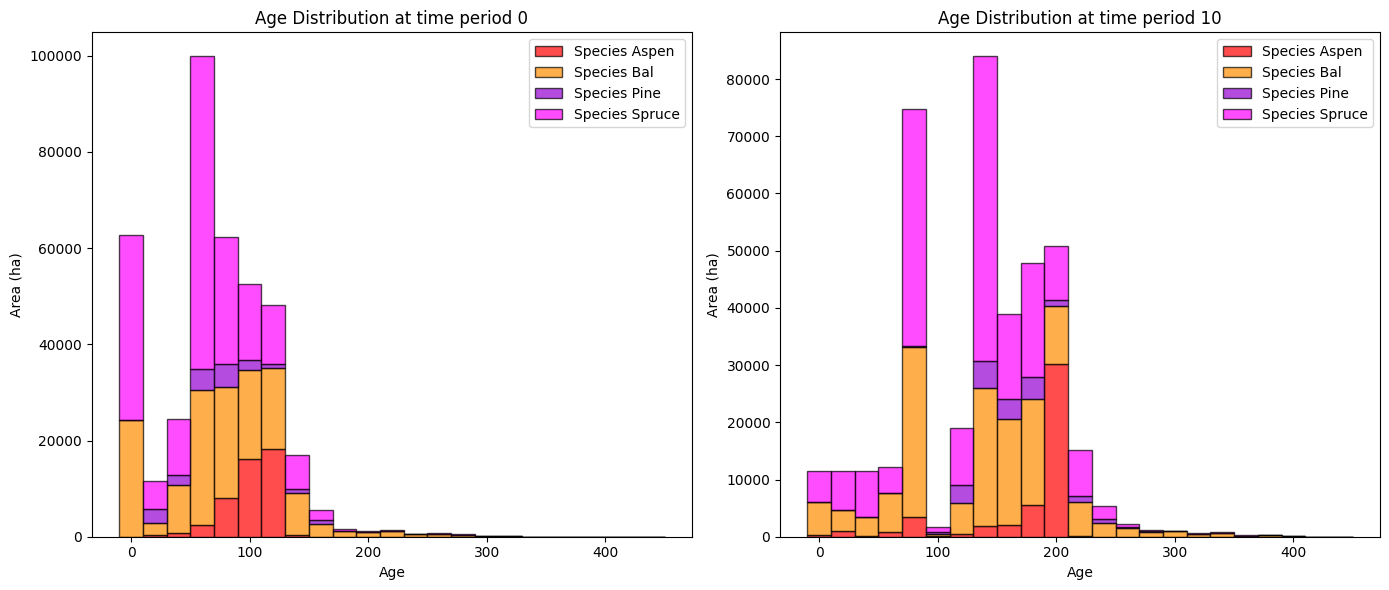

Plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  38766.465357  37821.151669
Pine     602.782616   9274.249263   8671.466647
Bal     4315.588546  35732.277284  31416.688738
Spruce  1072.814408  27525.137232  26452.322824

Old growth has **increased** by 104361.63 hectares from time period 0 to time period 10.


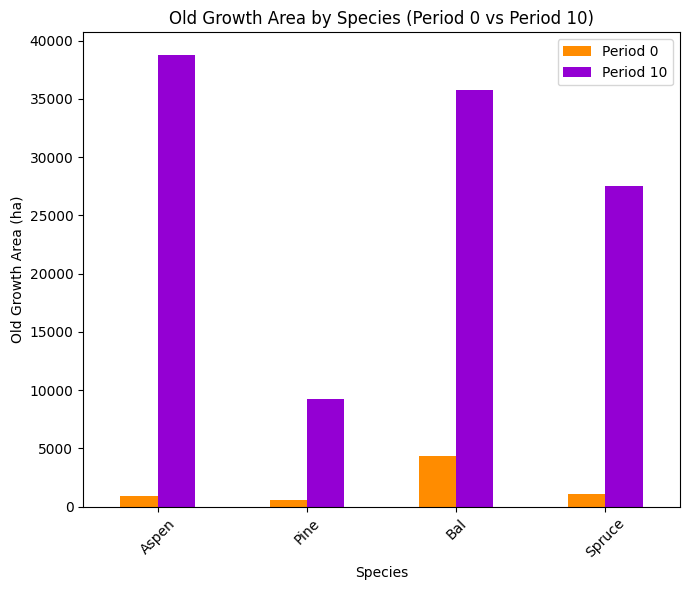

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.8507

Diversity has **decreased** by 3.41% from time 0 to time 10.


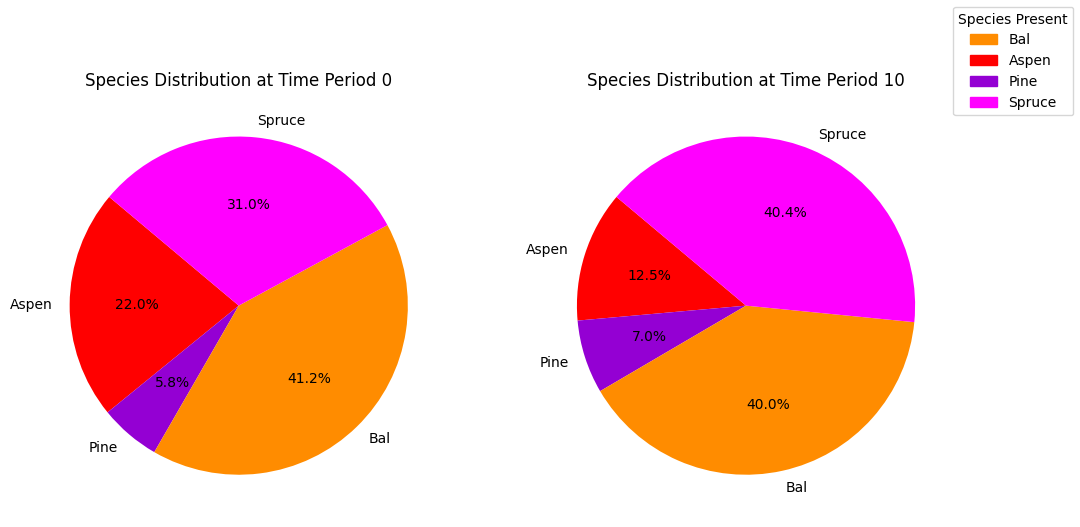

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_ha_bau_redchrs_species_pie.pdf


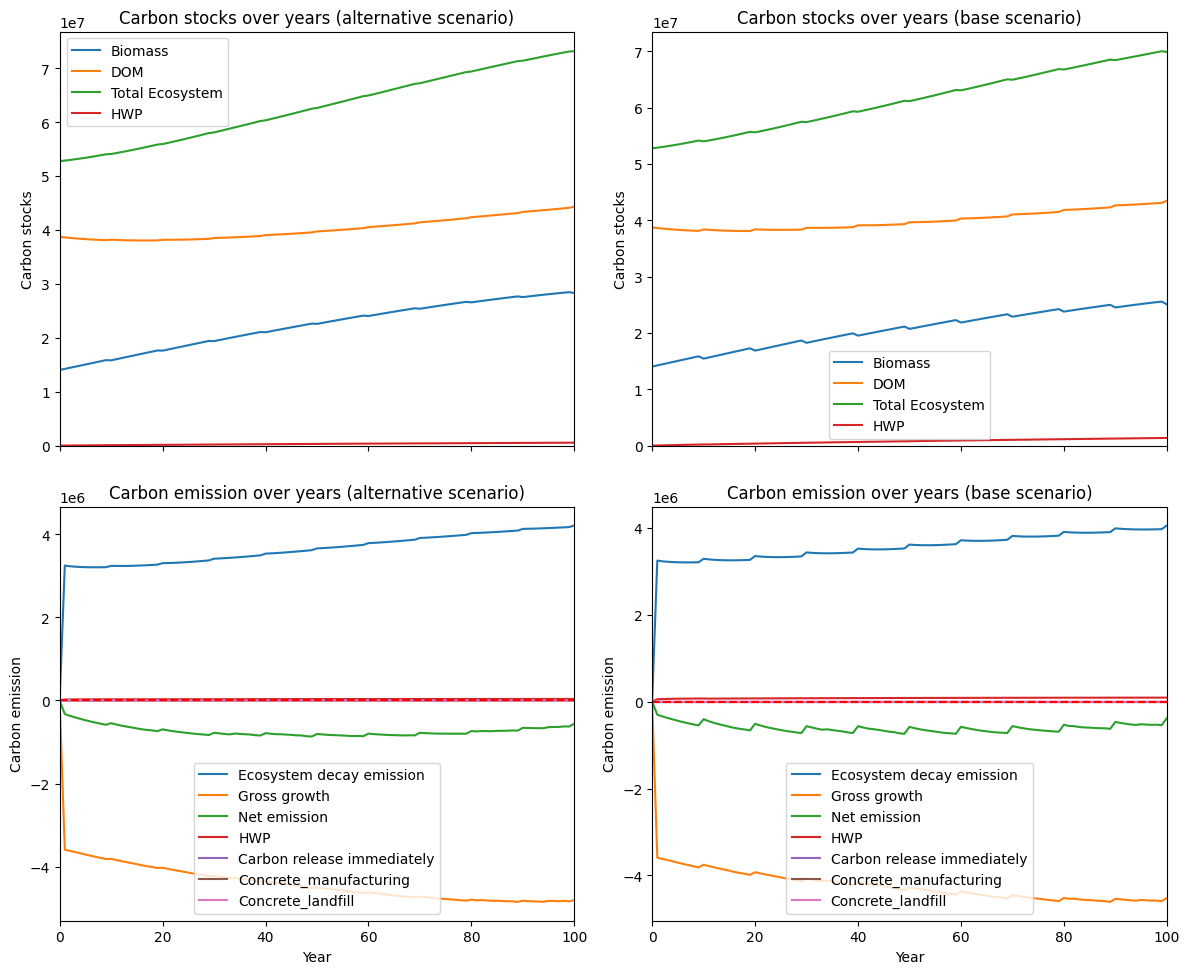

---------------------------------------------------------------------------------------
Net emission difference -13648236.710094066
Net emission base scenario -60129917.95418959
Net emission alternative scenario -73778154.66428365
dollar_per_ton is:  0.7326953812725218
Comparison of Old Growth Areas (Alternative - Base)
          0            10    Difference
Aspen   0.0   2651.607830   2651.607830
Pine    0.0    115.737010    115.737010
Bal     0.0  14289.906732  14289.906732
Spruce  0.0   5389.502694   5389.502694

Overall, the old growth area has **increased** by 22446.75 hectares in the alternative scenario compared to the base scenario.


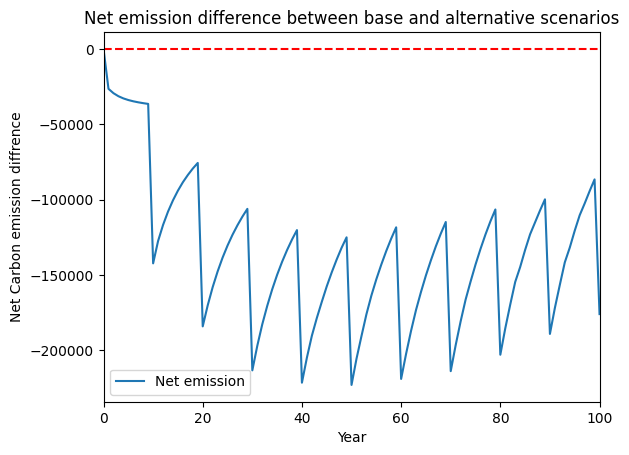

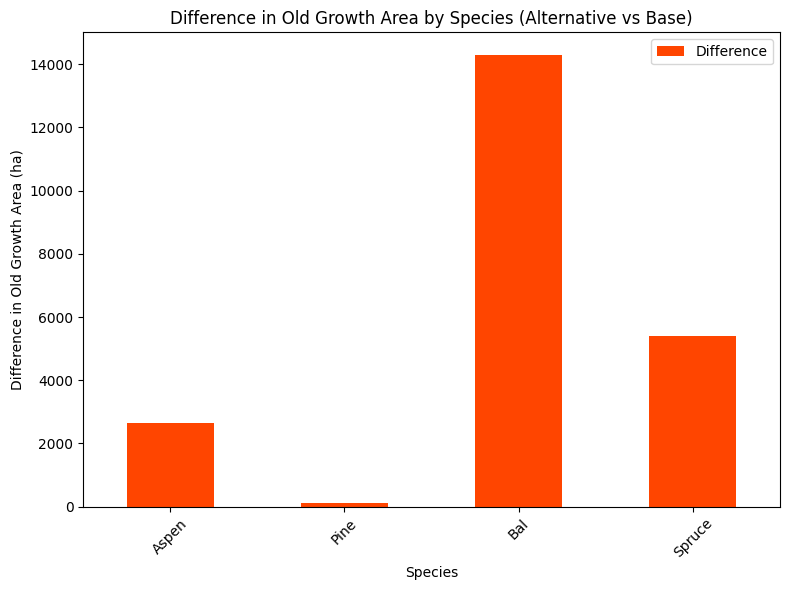

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/redchris/redchris_min_ha_kpi_age_difference.pdf


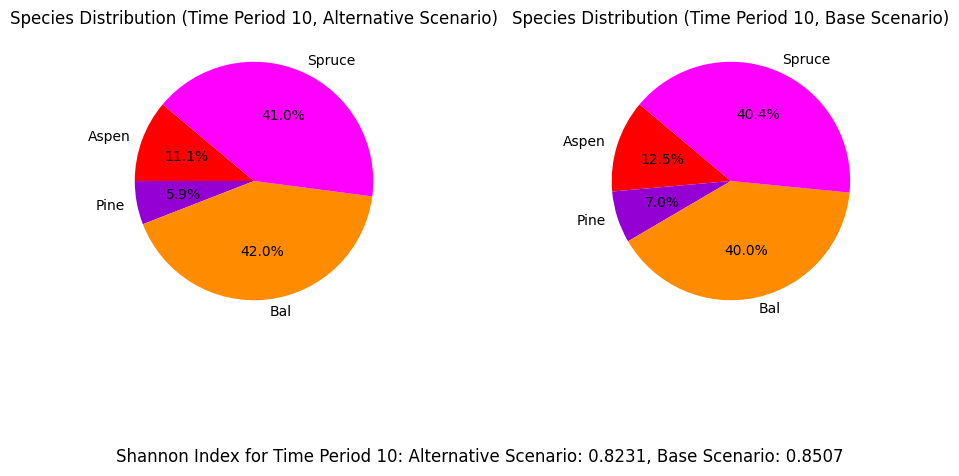

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_ha_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
It took 5.3 minutes to run all scenarios.


In [14]:
Start = time.time()
scenario_names = ['redchrs_AAC_40%']
for scenario_name in scenario_names:
    print(f"Running for {case_study}_{obj_mode}_{scenario_name}...")
    results_scenarios(fm, 
                      clt_percentage, 
                      credibility, 
                      budget_input, 
                      n_steps, 
                      max_harvest, 
                      scenario_name, 
                      displacement_effect, 
                      hwp_pool_effect_value, 
                      release_immediately_value, 
                      case_study, 
                      obj_mode,                   
                      pickle_output_base=False, 
                      pickle_output_alter=False)
print('It took', round((time.time() - Start) / 60, 1), "minutes to run all scenarios.")

In [13]:
print('It took', round((time.time() - Start) / 60, 1), "minutes to run this script.")

It took 66.8 minutes to run this script.
